In [1]:
import requests
from pprint import pprint
from geopy.distance import great_circle
import ast
from elasticsearch import Elasticsearch, helpers
import regex as re
from subprocess import Popen, PIPE, STDOUT
import os
import codecs
import numpy as np
from spacy import displacy
import spacy
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sn

%matplotlib inline

plt.style.use('ggplot')

tqdm.pandas(desc="Progress")


# ElasticSearch

In [2]:
es_server = Elasticsearch(
    hosts=["http://localhost:9200"], timeout=60, retry_on_timeout=True)

<ipython-input-2-09391bbada40>:1: DeprecationWarning: The 'timeout' parameter is deprecated in favor of 'request_timeout'
  es_server = Elasticsearch(


In [3]:
es_server.ping()


True

In [4]:
def get_coordinates_es(loc_name, exact_matching=True):
    txt = loc_name.lower()
    if exact_matching: 
        query = {
            "bool": {
                "should": [
                    { "term": { "name2": txt }},
                    { "term": { "asciiname2": txt }},
                    { "term": { "alternatenames2": txt}}
                ]
            }
        }
    else:
        query = {
            "bool": {
                "must": {
                    "multi_match": {
                        "query": txt,
                        "fields": ['name', 'asciiname', 'alternatenames'],
                        "operator":   "and"
                    }
                }
            }
        }
    result = []
    for query_result in es_server.search(index="geonames", query=query, size=10000)["hits"]["hits"]:
        source = query_result["_source"]
        result.append((source["latitude"], source["longitude"], source.get("population", 0), source.get("feature_code", "W"), source["geonameid"]))
    result.sort(key=lambda candidate: candidate[2], reverse=True)
    return result

In [5]:
get_coordinates_es("Brazil")

[(-10.0, -55.0, 209469333, 'PCLI', 3469034),
 (39.52365, -87.12501999999999, 8109, 'PPLA2', 4254884),
 (1.63414, -75.5719, 0, 'PPL', 8185502),
 (34.0265, -90.28065, 0, 'PPL', 4419335),
 (35.91757, -89.06257, 0, 'PPL', 4608373),
 (14.32438, 120.9784, 0, 'ST', 8610469),
 (10.55471, -61.275690000000004, 0, 'PPL', 3574931),
 (40.758070000000004, -92.95437, 0, 'W', 4849262),
 (40.758070000000004, -92.95437, 0, 'PPL', 4849263),
 (37.524809999999995, -84.04159, 0, 'PPL', 4285421),
 (37.84616, -91.06347, 0, 'PPL', 4378282),
 (-27.96667, 30.066670000000002, 0, 'FRM', 1015800),
 (-29.816670000000002, 17.133329999999997, 0, 'LCTY', 3369351),
 (-29.84057, 17.12048, 0, 'FRM', 3369352),
 (12.64933, -86.2379, 0, 'PPL', 3615895),
 (12.26063, -85.92436, 0, 'PPL', 3617945),
 (33.522659999999995, 36.2819, 0, 'DIP', 8373522)]

# Common

In [6]:
def ner_equal(pred, gt, exact_match=False):
    if exact_match:
        return gt[2] == pred[2]
    else:
        if (int(pred[0]) >= int(gt[0]) and int(pred[0]) <= int(gt[1])) or (int(pred[1]) >= int(gt[0]) and int(pred[1]) <= int(gt[1])):
            return True
        return False

In [7]:
from geopy.distance import great_circle


def metrics(predictions, ground_truth, exact_match=False, min_dist=30):
    truth = ground_truth.copy()
    TP = 0
    FP = len(predictions)
    FN = len(truth)
    distances = []
    within_dist = 0
    for pred in predictions:
        for i, gt in enumerate(truth[:]):
            if ner_equal(pred, gt, exact_match):
                TP = TP + 1
                FN = FN - 1
                FP = FP - 1
                if pred[4] is not None:
                    distances.append(great_circle(
                        (float(gt[7]), float(gt[8])), (pred[4][2], pred[4][3])).km)
                    if distances[-1] < min_dist:
                        within_dist = within_dist + 1
                del truth[i]
                break
    pre = TP / (TP + FP) if (TP + FP) else np.nan
    rec = TP / (TP + FN) if (TP + FN) else np.nan
    f1 = (2 * (pre * rec) / (pre + rec)) if (pre + rec) else np.nan
    md = np.mean(distances) if len(distances) > 0 else np.nan
    wd = within_dist / len(distances) if len(distances) > 0 else np.nan
    lgdistances = np.log(np.array(distances) + 1)
    k = np.log(161)
    wd_lg = sum([1.0 for dist in lgdistances if dist < k]) / \
        len(lgdistances) if len(lgdistances) > 0 else np.nan
    auc = np.trapz(lgdistances) / (np.log(20039) * (len(lgdistances) - 1)
                                   ) if len(lgdistances) - 1 != 0 else np.nan
    pct = len(distances)/len(ground_truth) if len(ground_truth) > 0 else np.nan

    return (pre, rec, f1, md, wd, wd_lg, auc, pct)

In [8]:
def get_prediction_errors(predictions, ground_truth, exact_match=False):
    truth = ground_truth.copy()
    distances = []
    for pred in predictions:
        for i, gt in enumerate(truth[:]):
            if ner_equal(pred, gt, exact_match):
                if pred[4] is not None:
                    distances.append(great_circle(
                        (float(gt[7]), float(gt[8])), (pred[4][2], pred[4][3])).km)
                del truth[i]
                break
    return distances

In [9]:
from pprint import pprint


def metrics_gritta(unified, unified_geocoded):
    errors = []
    for g, p in zip(unified, unified_geocoded):
        if p[4] is not None:
            errors.append(great_circle(
                (p[4][2], p[4][3]), (float(g[7]), float(g[8]))).km)
    print(len(errors))

    print(u"Median error:", np.median(sorted(errors)))
    print(u"Mean error:", np.mean(errors))
    print(u"Std error:", np.std(errors))
    errors = np.log(np.array(errors) + 1)
    k = np.log(161)
    print("Accuracy to 161 km: ", sum(
        [1.0 for dist in errors if dist < k]) / len(errors))
    print("AUC = ", np.trapz(errors) / (np.log(20039) * (len(errors) - 1)))
    pprint(metrics(unified_geocoded, unified, False, 161))


In [10]:
import plotly.express as px
import plotly.graph_objects as go


def plot_toponyms_predictions(toponyms, predictions, fig, filename="", visible=True):
    truth = toponyms.copy()
    result = []
    first = True
    for pred in predictions:
        for i, gt in enumerate(truth[:]):
            if ner_equal(pred, gt, False):
                if pred[4] is not None:
                    distance = great_circle(
                        (float(gt[7]), float(gt[8])), (pred[4][2], pred[4][3])).km
                    result.append([
                        [gt[2], pred[2]],
                        [gt[3], pred[4][1]],
                        [gt[6], pred[4][0]],
                        [float(gt[7]), float(pred[4][2])],
                        [float(gt[8]), float(pred[4][3])],
                        [gt[4], gt[4]],
                        ['red', 'green'],
                        'green',
                        [distance, distance]
                    ])
                    fig.add_trace(go.Scattermapbox(
                        mode="markers+lines",
                        lat=[gt[7], pred[4][2]],
                        lon=[gt[8], pred[4][3]],
                        marker=dict(size=[12, 10], color=['red', 'green']),
                        line=dict(color='steelblue'),
                        text=[gt[2], pred[2]],
                        customdata=[
                            [gt[2], gt[3], gt[6], gt[4], distance],
                            [pred[2], pred[4][1], pred[4][0], gt[4], distance]
                        ],
                        hovertemplate="<b>%{text}</b><br><br>extractedName=%{customdata[0]}<br>geonamesName=%{customdata[1]}<br>geonamesID=%{customdata[2]}<br>lat=%{lat}<br>lon=%{lon}<br>type=%{customdata[3]}<br>distance=%{customdata[4]}",
                        legendgroup=(filename),
                        showlegend=first,
                        name=(filename),
                        visible=visible
                    ))
                else:
                    result.append([
                        [gt[2]],
                        [gt[3]],
                        [gt[6]],
                        [float(gt[7])],
                        [float(gt[8])],
                        [gt[4]],
                        ['purple'],
                        ''
                    ])
                    fig.add_trace(go.Scattermapbox(
                        mode="markers",
                        lat=[gt[7]],
                        lon=[gt[8]],
                        marker={'size': 11, 'color': ['purple']},
                        text=[gt[2]],
                        customdata=[
                            [gt[2], gt[3], gt[6], gt[4]]
                        ],
                        hovertemplate="<b>%{text}</b><br><br>extractedName=%{customdata[0]}<br>geonamesName=%{customdata[1]}<br>geonamesID=%{customdata[2]}<br>lat=%{lat}<br>lon=%{lon}<br>type=%{customdata[3]}",
                        legendgroup=(filename),
                        showlegend=first,
                        name=(filename),
                        visible=visible
                    ))
                first = False
                del truth[i]
                break

    return result


In [11]:
def count_errors(predictions, ground_truth, exact_match, classes=["Literal", "Non_Literal_Modifier", "Embedded_Non_Lit", "Mixed", "Literal_Modifier", "Metonymic", "Coercion", "Embedded_Literal"]):
    errors = {k: [] for k in classes}
    truth = ground_truth.copy()
    for p in predictions:
        for i, g in enumerate(truth[:]):
            if ner_equal(p, g, exact_match):
                if p[4] is not None:
                    errors[g[4]].append(great_circle(
                        (g[7], g[8]), (p[4][2], p[4][3])).km)
                else:
                    errors[g[4]].append(-1)
                del truth[i]
                break
    if len(truth):
        for g in truth:
            errors[g[4]].append(-2)
    return errors


def count_errors_by_type(df, exact_match=False, classes=["Literal", "Non_Literal_Modifier", "Embedded_Non_Lit", "Mixed", "Literal_Modifier", "Metonymic", "Coercion", "Embedded_Literal"]):
    counts_errors = df.apply(lambda row: count_errors(
        row.geocoded, row.toponyms, False, classes), axis=1)
    errors_by_type = {k: [] for k in classes}
    for d in counts_errors:
        for k, v in d.items():
            errors_by_type[k].extend(v)
    return errors_by_type

def count_errors_by_type_intersection(df, exact_match=False, classes=["Literal", "Non_Literal_Modifier", "Embedded_Non_Lit", "Mixed", "Literal_Modifier", "Metonymic", "Coercion", "Embedded_Literal"]):
    counts_errors = df.apply(lambda row: count_errors(
        row.geocoded, row.toponyms_in, False, classes), axis=1)
    errors_by_type = {k: [] for k in classes}
    for d in counts_errors:
        for k, v in d.items():
            errors_by_type[k].extend(v)
    return errors_by_type


In [12]:
def align_labels(labels):
    for text in labels:
        x, y = text.get_position()
        h_align = 'left' if x > 0 else 'right'
        v_align = 'bottom' if y > 0 else 'top'
        text.set(ha=h_align, va=v_align)


def plot_pies(df):
    plt.style.use('ggplot')
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color'] + ["crimson", "indigo", "DarkOrchid"]
    for ax, col in zip(axes.flat, df.columns):
        if not df[col].any():
            break
        artists = ax.pie(df[col], autopct=lambda p: '{:.2f}%({:.0f})'.format(
            p, (p/100)*df[col].sum()), pctdistance=1.05, colors=colors)
        ax.set(ylabel='', title=col, aspect='equal')
        align_labels(artists[-1])

    fig.legend(artists[0], df.index, loc='right')

    plt.show()


In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrices(df):
    plt.style.use('ggplot')
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    for ax, col in zip(axes.flat, df.columns):
        if not df[col].dropna().count():
            break
        cf_matrix = confusion_matrix([0] + [1 for i in range(df[col].count())], [0] + [
                                     1 if i <= 161 else 0 for i in df[col].dropna().tolist()])
        cf_matrix[0][0] -= 1
        group_names = ['True Neg', 'False Pos', '> 161km', '<= 161km']
        group_counts = ["{0:0.0f}".format(value)
                        for value in cf_matrix.flatten()]
        group_percentages = ["{0:.2%}".format(
            value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(
            group_names, group_counts, group_percentages)]
        labels = np.asarray(labels).reshape(2, 2)
        sns.heatmap(cf_matrix, annot=labels, fmt='', ax=ax,
                    cmap='Blues',  cbar_kws={"orientation": "horizontal"})
        ax.set(ylabel='', title=col, aspect='equal')

    plt.show()


In [14]:
def plot_bars(df):
    plt.style.use('ggplot')
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    handles = []
    for ax, col in zip(axes.flat, df.columns):
        if not df[col].dropna().count():
            break
        
        group_names = ['Not Detected', 'No Candidate Found', '<= 161km', '> 161km']
        categorized = df[[col]].apply(pd.cut, bins=[-3, -2, -1, 161, 20038], labels=group_names)
        counts = categorized.apply(pd.Series.value_counts).reset_index()
        
        splot = sns.barplot(x="index", y=col, data=counts, ax=ax)
        for i, p in enumerate(splot.patches):
            splot.annotate("{0:0.0f}\n{1:.2%}".format(p.get_height(), p.get_height()/counts[col].values.sum()), 
                   (p.get_x() + p.get_width() / 2., max(counts[col].values.flat) * 0.02), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
        
        ax.set_xticks([])
        ax.set(xlabel='', ylabel='', title=col)
    
    fig.legend(splot.patches, ['Not Detected', 'No Candidate Found', '<= 161km', '> 161km'], loc='right')

    plt.show()

In [15]:
def plot_bars_stacked(df):
    plt.style.use('ggplot')
    handles = []

    group_names = ['Sem Candidatos', '<= 161km', '> 161km']
    categorized = df.apply(pd.cut, bins=[-2, -1, 161, 20038], labels=group_names)
    counts = categorized.apply(pd.Series.value_counts)

    ax = counts.T.plot(kind='barh', stacked=True, figsize=(10, 10))

    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x + width/2, 
              y + height/2, 
              '{0:0.0f}'.format(width), 
              horizontalalignment='center', 
              verticalalignment='center')
        
    #plt.savefig('plot_bars_stacked.pdf', bbox_inches='tight')
    plt.show()

In [16]:
def plot_bars_stacked_diff(df1, df2):
    plt.style.use('ggplot')
    handles = []

    group_names = ['Sem Candidatos', '<= 161km', '> 161km']

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
    
    categorized1 = df1.apply(pd.cut, bins=[-2, -1, 161, 20038], labels=group_names)
    counts1 = categorized1.apply(pd.Series.value_counts)

    counts1.T.plot(kind='barh', stacked=True, ax=axes.flat[0])

    categorized2 = df2.apply(pd.cut, bins=[-2, -1, 161, 20038], labels=group_names)
    counts2 = categorized2.apply(pd.Series.value_counts)

    counts2.T.plot(kind='barh', stacked=True, ax=axes.flat[1])

    for p in axes.flat[0].patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        axes.flat[0].text(x + width/2, 
              y + height/2, 
              '{0:0.0f}'.format(width), 
              horizontalalignment='center', 
              verticalalignment='center')
      
    for p in axes.flat[1].patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        axes.flat[1].text(x + width/2, 
              y + height/2, 
              '{0:0.0f}'.format(width), 
              horizontalalignment='center', 
              verticalalignment='center')
    #axes.flat[1].set_yticks([])

    plt.show()

In [17]:
def get_error_by_feature_code(predictions, ground_truth, exact_match=False):
    truth = ground_truth.copy()
    errors_by_type = {}
    distances = []
    within_dist = 0
    for pred in predictions:
        for i, gt in enumerate(truth[:]):
            if ner_equal(pred, gt, exact_match):
                if pred[4] is not None:
                    if gt[10] not in errors_by_type:
                        errors_by_type[gt[10]] = []
                    errors_by_type[gt[10]].append(great_circle(
                        (float(gt[7]), float(gt[8])), (pred[4][2], pred[4][3])).km)
                del truth[i]
                break
    return errors_by_type

def get_mean_error_by_feature_code(df, exact_match=False):
    errors_by_code = df.apply(lambda row: get_error_by_feature_code(row.geocoded, row.toponyms, exact_match), axis=1)
    
    errors_by_code_cum = {}
    for d in errors_by_code:
        for k, v in d.items():
            if k not in errors_by_code_cum:
                errors_by_code_cum[k] = []
            errors_by_code_cum[k].extend(v)

    mean_errors_by_type = {k: np.mean(v) for (k,v) in errors_by_code_cum.items()}
    return mean_errors_by_type

In [18]:
def get_error_by_feature_class(predictions, ground_truth, exact_match=False):
    truth = ground_truth.copy()
    errors_by_type = {}
    distances = []
    within_dist = 0
    for pred in predictions:
        for i, gt in enumerate(truth[:]):
            if ner_equal(pred, gt, exact_match):
                if pred[4] is not None:
                    if gt[9] not in errors_by_type:
                        errors_by_type[gt[9]] = []
                    errors_by_type[gt[9]].append(great_circle(
                        (float(gt[7]), float(gt[8])), (pred[4][2], pred[4][3])).km)
                del truth[i]
                break
    return errors_by_type

def get_mean_error_by_feature_class(df, exact_match=False):
    errors_by_code = df.apply(lambda row: get_error_by_feature_class(row.geocoded, row.toponyms, exact_match), axis=1)
    
    errors_by_code_cum = {}
    for d in errors_by_code:
        for k, v in d.items():
            if k not in errors_by_code_cum:
                errors_by_code_cum[k] = []
            errors_by_code_cum[k].extend(v)

    mean_errors_by_type = {k: np.mean(v) for (k,v) in errors_by_code_cum.items()}
    return mean_errors_by_type

def get_mean_error_by_feature_class_intersection(df, exact_match=False):
    errors_by_code = df.apply(lambda row: get_error_by_feature_class(row.geocoded, row.toponyms_in, exact_match), axis=1)
    
    errors_by_code_cum = {}
    for d in errors_by_code:
        for k, v in d.items():
            if k not in errors_by_code_cum:
                errors_by_code_cum[k] = []
            errors_by_code_cum[k].extend(v)

    mean_errors_by_type = {k: np.mean(v) for (k,v) in errors_by_code_cum.items()}
    return mean_errors_by_type

In [19]:
def get_names_by_demonym(demonym, exact_matching=True):
    txt = demonym.lower()
    if exact_matching:
        query = {
            "bool": {
                "should": [
                    {"term": {"adjectivals_lower": txt}},
                    {"term": {"demonyms_lower": txt}}
                ]
            }
        }
    else:
        query = {
            "bool": {
                "must": {
                    "multi_match": {
                        "query": txt,
                        "fields": ['adjectivals', 'demonyms'],
                        "operator":   "and"
                    }
                }
            }
        }
    result = []
    for query_result in es_server.search(index="demonyms", query=query, size=50)["hits"]["hits"]:
        source = query_result["_source"]
        result.append((source["entity_name"], source["geonames_id"],
                      source["geonames_name"], source["adjectivals"], source["demonyms"]))
    return result


In [20]:
nlp_en = spacy.load("en_core_web_lg")

# Geoparser

In [21]:
class Geoparser:
    def __init__(self, ner_model, loc_entity_labels, es_server, index_search_configs=[]):
        self.ner_model = ner_model
        self.loc_entity_labels = loc_entity_labels
        self.es_server = es_server
        self.index_search_configs = index_search_configs
 
    def _geotag(self, text):
        entities = self.ner_model(text).ents
        loc_entities = [(entity.start_char, entity.end_char, entity.text, entity.label_) for entity in entities if (entity.label_ in self.loc_entity_labels)]
        return loc_entities

    def _get_candidates(self, loc_name, loc_type, exact_matching=False, process_demonyms=False, bounding_box=None, k=5, minimum_score=0.0, sort_by="score"):
        txt = loc_name
        if process_demonyms:
            demonym_entries = get_names_by_demonym(txt, True)
            if len(demonym_entries):
                txt = [d[2] for d in demonym_entries]
            else:
                txt = [txt]
        else:
            txt = [txt]
        candidates = []
        for index in self.index_search_configs:
            if exact_matching:
                txt = [t.lower() for t in txt]
                query = {
                    "bool": {
                        "should": [
                            { "terms": { "name2": txt }},
                            { "terms": { "asciiname2": txt }},
                            { "terms": { "alternatenames2": txt}}
                        ]
                    }
                }
            else:
                query = {
                    "bool": {
                        "should": []
                    }
                }
                for t in txt:
                    query["bool"]["should"].append({
                        "bool": {
                            "must": {
                                "multi_match": {
                                    "query": t,
                                    "fields": ['name', 'asciiname', 'alternatenames'],
                                    "operator":   "and"
                                }
                            }
                        }
                    })
            if bounding_box:
                query['bool']['filter'] = {
                    "geo_bounding_box": { 
                        "location": {
                            "top_left": {
                                "lat": bounding_box[0][0],
                                "lon": bounding_box[0][1]
                            },
                            "bottom_right": {
                                "lat": bounding_box[1][0],
                                "lon": bounding_box[1][1]
                            }
                        }
                    }
                }
            for result in self.es_server.search(index=index["name"], query=query, min_score=minimum_score, size=10000)["hits"]["hits"]:
                source = result["_source"]
                candidates.append((source["geonameid"], source["name"], source["latitude"], source["longitude"], source.get("feature_class", "W"), source.get("population", 0), result["_score"]))
            if len(candidates) > 0:
                if sort_by == "feature_class": 
                    candidates.sort(key=lambda candidate: candidate[4])
                elif sort_by == "population":
                    candidates.sort(key=lambda candidate: candidate[5], reverse=True)
                else:
                    candidates.sort(key=lambda candidate: candidate[-1], reverse=True)
                addr = [candidates[i] for i in range(0, min(k, len(candidates)))]
                return addr
            else:
                return []

    def _disambiguate(self, candidates, loc_type, geocoded=[], minimization_classes=[], minimization_strategy="mean_dist"):
        if len(candidates) == 0:
            return None
        if len(minimization_classes) > 0 and loc_type in minimization_classes:
            geocoded_not_none = [g for g in geocoded if g[4] is not None and g[3] in minimization_classes]
            if len(geocoded_not_none) > 0:
                if minimization_strategy == "pop_by_mean_dist":
                    candidates.sort(key=lambda candidate: -candidate[5] / (1 + np.mean([great_circle((candidate[2], candidate[3]), (geoc[4][2], geoc[4][3])).km for geoc in geocoded_not_none])))
                elif minimization_strategy == "mean_dist":
                    candidates.sort(key=lambda candidate: np.mean([great_circle((candidate[2], candidate[3]), (geoc[4][2], geoc[4][3])).km for geoc in geocoded_not_none]))
                else:
                    candidates.sort(key=lambda candidate: np.sum([great_circle((candidate[2], candidate[3]), (geoc[4][2], geoc[4][3])).km for geoc in geocoded_not_none]))
        return candidates[0]

    def _geocode(self, loc_name, loc_type, geocoded=[], exact_matching=False, process_demonyms=False, bounding_box=None, k=5, minimum_score=0, sort_by="score", minimization_classes=[], minimization_strategy="sum_dist"):
        candidates = self._get_candidates(loc_name, loc_type, exact_matching, process_demonyms, bounding_box, k, minimum_score, sort_by)
        addr = self._disambiguate(candidates, loc_type, geocoded, minimization_classes, minimization_strategy)
        return addr

    def _geocode_entities(self, entities, exact_matching=False, process_demonyms=False, bounding_box=None, k=5, minimum_score=0, sort_by="score", minimization_classes=[], minimization_strategy="sum_dist"):
        geocoded=[]
        for entity in entities:
            res = self._geocode(entity[2], entity[3], geocoded=geocoded, exact_matching=exact_matching, process_demonyms=process_demonyms, bounding_box=bounding_box,
                                     k=k, minimum_score=minimum_score, sort_by=sort_by, minimization_classes=minimization_classes, minimization_strategy=minimization_strategy)
            geocoded.append((entity[0], entity[1], entity[2], entity[3], res))
        return geocoded

    def geoparse(self, text, exact_matching=False, process_demonyms=False, bounding_box=None, k=5, minimum_score=0, sort_by="score", minimization_classes=[], minimization_strategy="sum_dist"):
        entities = self._geotag(text)
        geocoded = self._geocode_entities(entities=entities, exact_matching=exact_matching, process_demonyms=process_demonyms, bounding_box=bounding_box,
                                     k=k, minimum_score=minimum_score, sort_by=sort_by, minimization_classes=minimization_classes, minimization_strategy=minimization_strategy)
        return geocoded

In [22]:
geoparser = Geoparser(nlp_en, 
                      ['ORG', 'LOC', 'GPE', 'FAC', 'FACILITY'], 
                      es_server, [{"name": "geonames", "fields": ['name', 'asciiname', 'alternatenames']}])

In [23]:
print(geoparser._geocode("Chinese", '', geocoded=[], exact_matching=False, process_demonyms=False, bounding_box=None,
                                  k=5, minimum_score=0, sort_by="population", minimization_classes=[], minimization_strategy="sum_dist"))

print(geoparser._geocode("Chinese", '', geocoded=[], exact_matching=True, process_demonyms=False, bounding_box=None,
                                  k=5, minimum_score=0, sort_by="population", minimization_classes=[], minimization_strategy="sum_dist"))


print(geoparser._geocode("Chinese", '', geocoded=[], exact_matching=False, process_demonyms=True, bounding_box=None,
                                  k=5, minimum_score=0, sort_by="population", minimization_classes=[], minimization_strategy="sum_dist"))

print(geoparser._geocode("Chinese", '', geocoded=[], exact_matching=True, process_demonyms=True, bounding_box=None,
                                  k=5, minimum_score=0, sort_by="population", minimization_classes=[], minimization_strategy="sum_dist"))


print(geoparser._geocode("Chinese", 'Literal', 
                         geocoded=[(0, 13, "Chinese Garden", "Literal", (1882507, 'Chinese Garden', 1.33861, 103.73, 'L', 0, 3.0)), 
                                   (50, 67, "Chinese Embassy", "Coercion", (4138500, 'Embassy of the Peoples Republic of China', 38.91872, -77.04914000000001, 'S', 0, 2.0))], 
                         exact_matching=False, process_demonyms=False, bounding_box=None,
                         k=5, minimum_score=0, sort_by="population", minimization_classes=['Literal'], minimization_strategy="sum_dist"))

print(geoparser._geocode("Chinese", 'Coercion', 
                         geocoded=[(0, 13, "Chinese Garden", "Literal", (1882507, 'Chinese Garden', 1.33861, 103.73, 'L', 0, 3.0)), 
                                   (50, 67, "Chinese Embassy", "Coercion", (4138500, 'Embassy of the Peoples Republic of China', 38.91872, -77.04914000000001, 'S', 0, 2.0))], 
                         exact_matching=False, process_demonyms=False, bounding_box=None,
                         k=5, minimum_score=0, sort_by="population", minimization_classes=['Literal'], minimization_strategy="sum_dist"))

print(geoparser._geocode("Chinese", 'Coercion', 
                         geocoded=[(0, 13, "Chinese Garden", "Literal", (1882507, 'Chinese Garden', 1.33861, 103.73, 'L', 0, 3.0)), 
                                   (50, 67, "Chinese Embassy", "Coercion", (4138500, 'Embassy of the Peoples Republic of China', 38.91872, -77.04914000000001, 'S', 0, 2.0))], 
                         exact_matching=False, process_demonyms=False, bounding_box=None,
                         k=5, minimum_score=0, sort_by="population", minimization_classes=['Coercion'], minimization_strategy="sum_dist"))


print(geoparser._geocode("Chinese", 'Literal', 
                         geocoded=[(0, 13, "Chinese Garden", "Literal", (1882507, 'Chinese Garden', 1.33861, 103.73, 'L', 0, 3.0)), 
                                   (50, 67, "Chinese Embassy", "Coercion", (4138500, 'Embassy of the Peoples Republic of China', 38.91872, -77.04914000000001, 'S', 0, 2.0))], 
                         exact_matching=False, process_demonyms=True, bounding_box=None,
                         k=5, minimum_score=0, sort_by="population", minimization_classes=['Literal'], minimization_strategy="sum_dist"))

print(geoparser._geocode("Chinese", 'Coercion', 
                         geocoded=[(0, 13, "Chinese Garden", "Literal", (1882507, 'Chinese Garden', 1.33861, 103.73, 'L', 0, 3.0)), 
                                   (50, 67, "Chinese Embassy", "Coercion", (4138500, 'Embassy of the Peoples Republic of China', 38.91872, -77.04914000000001, 'S', 0, 2.0))], 
                         exact_matching=False, process_demonyms=True, bounding_box=None,
                         k=5, minimum_score=0, sort_by="population", minimization_classes=['Literal'], minimization_strategy="sum_dist"))

print(geoparser._geocode("Chinese", 'Coercion', 
                         geocoded=[(0, 13, "Chinese Garden", "Literal", (1882507, 'Chinese Garden', 1.33861, 103.73, 'L', 0, 3.0)), 
                                   (50, 67, "Chinese Embassy", "Coercion", (4138500, 'Embassy of the Peoples Republic of China', 38.91872, -77.04914000000001, 'S', 0, 2.0))], 
                         exact_matching=False, process_demonyms=True, bounding_box=None,
                         k=5, minimum_score=0, sort_by="population", minimization_classes=['Coercion'], minimization_strategy="sum_dist"))

(1799355, 'Ningxia Huizu Zizhiqu', 37.25, 106.0, 'A', 6180000, 4.3937798)
None
(1814991, 'People’s Republic of China', 35.0, 105.0, 'A', 1392730000, 6.289756)
(1814991, 'People’s Republic of China', 35.0, 105.0, 'A', 1392730000, 1.0)
(1882507, 'Chinese Garden', 1.33861, 103.73, 'L', 0, 16.081512)
(1799355, 'Ningxia Huizu Zizhiqu', 37.25, 106.0, 'A', 6180000, 4.3937798)
(5336487, 'Chinese Camp', 37.87104, -120.43325, 'P', 126, 13.43905)
(1821275, 'Macau Special Administrative Region', 22.15778, 113.55972, 'A', 631636, 3.3660793)
(1814991, 'People’s Republic of China', 35.0, 105.0, 'A', 1392730000, 6.289756)
(1814991, 'People’s Republic of China', 35.0, 105.0, 'A', 1392730000, 6.289756)


# CLAVIN Geoparser

In [24]:
class ClavinGeoparser:
    def __init__(self):
        self.url = URL = "http://localhost:9090/api/v1/geotag"

    def geoparse(self, text):
        r = requests.post(url=self.url, data=text.encode('utf-8'))
        data = r.json()
        result = []
        for loc in data["resolvedLocations"]:
            result.append((loc["location"]["position"], loc["location"]["position"] + len(loc["location"]["text"]), loc["location"]["text"], "",
                           (loc["geoname"]["geonameID"], loc["geoname"]["name"], loc["geoname"]["latitude"], loc["geoname"]["longitude"], loc["geoname"]["featureClass"], loc["geoname"]["population"], loc["confidence"])))
        return result


In [25]:
clavin_geoparser = ClavinGeoparser()

# Experimentos

In [26]:
def geocode_toponyms(geoparser, toponyms, exact_matching=False, process_demonyms=False, bounding_box=None, k=5, minimum_score=0, sort_by="score", minimization_classes=[], minimization_strategy="sum_dist"):
    loc_entities = [(t[0], t[1], t[2], t[4]) for t in toponyms]
    loc_entities.sort(key=lambda entity: int(entity[0]))
    geocoded = geoparser._geocode_entities(loc_entities, exact_matching=exact_matching, process_demonyms=process_demonyms, bounding_box=bounding_box, k=k, minimum_score=minimum_score, sort_by=sort_by, minimization_classes=minimization_classes, minimization_strategy=minimization_strategy)
    return geocoded

In [27]:
def geocode_clavin_results(geoparsed, geoparser, toponyms, exact_matching=False, process_demonyms=False, bounding_box=None, k=5, minimum_score=0, sort_by="score", minimization_classes=[], minimization_strategy="sum_dist"):
    truth = toponyms.copy()
    truth.sort(key=lambda entity: int(entity[0]))
    loc_entities = []
    for p in geoparsed:
        for i, g in enumerate(truth[:]):
            if ner_equal(p, g):
                loc_entities.append((p[0], p[1], p[2], g[4]))
                del truth[i]
                break
    geocoded = geoparser._geocode_entities(loc_entities, exact_matching=exact_matching, process_demonyms=process_demonyms, bounding_box=bounding_box, k=k, minimum_score=minimum_score, sort_by=sort_by, minimization_classes=minimization_classes, minimization_strategy=minimization_strategy)
    return geocoded

In [28]:
def filter_clavin_results(geocoded, gt):
    truth = gt.copy()
    truth.sort(key=lambda entity: int(entity[0]))
    filtered_geocoded = []
    for p in geocoded:
        for i, g in enumerate(truth[:]):
            if ner_equal(p, g):
                filtered_geocoded.append(p)
                del truth[i]
                break
    return filtered_geocoded

## GeoWebNews

In [29]:
#df_geowebnews = pd.read_csv('../EUPEG-datasets/GWN_locational_only.csv')

df_geowebnews = pd.read_csv('../EUPEG-datasets/GeoWebNews_with_featurecodes.csv')
df_geowebnews['toponyms'] = df_geowebnews.apply(
    lambda row: ast.literal_eval(row.toponyms), axis=1)

df_geowebnews['toponyms'] = df_geowebnews['toponyms'].apply(
    lambda x: [t for t in x if t[6] is not None])

df_geowebnews

file                                               link  \
0       0  http://www.nola.com/mardi_gras_nola/2018/01/ta...   
1       1  http://www.eastoregonian.com/turkey-shells-syr...   
2      10  https://www.washingtonpost.com/realestate/a-ta...   
3     100  http://bangordailynews.com/2018/03/31/news/nat...   
4     101  http://www.thisdaylive.com/index.php/2018/03/3...   
..    ...                                                ...   
195   313  https://www.maltatoday.com.mt/news/national/85...   
196   314  http://www.adnkronos.com/immediapress/pr-newsw...   
197   318  http://www.watoday.com.au/world/a-question-of-...   
198   319  https://www.derryjournal.com/news/altnagelvin-...   
199    32  https://foreignaffairs.co.nz/2018/03/30/mil-os...   

                                                 title  \
0    Krewe du Vieux 2018: Take a virtual tour of th...   
1    Turkey shells Syrian city as it pushes into Ku...   
2    A new development in Gainesville, Va., provide...   
3    Laura Ingraham takes an Easter break amid Davi...   
4    Perm Secretary Launches Book for Africa’s Deve...   
..                                                 ...   
195  Incoming MFSA chairman accuses Deutsche Bank o...   
196  EW Nutrition and ICON Form a Strategic Partner...   
197  A question of diversity: how fashion is ditchi...   
198  Altnagelvin’s new health and well-being hub opens   
199  MIL-OSI USA: Diaz-Balart Speaks at Immokalee T...   

                                                  text  \
0    This area formed the heart of the plantation o...   
1    BEIRUT (AP) � A Kurdish militia spokesman says...   
2    Southern design Buy Photo : Exteriors are vary...   
3    Cleve R. Wootson Jr., The Washington Post Marc...   
4    Former Permanent Secretary, Federal Ministry o...   
..                                                 ...   
195  Incoming Malta Financial Services Authority ch...   
196  EW Nutrition acquires 51% of the shares in ICO...   
197  "We want to be held accountable," she said in ...   
198  A new Health and Wellbeing Campus has opened a...   
199  Source: United States House of Representatives...   

                                              toponyms  
0    [(3691, 3716, Third Presbyterian Church, Third...  
1    [(612, 617, Afrin, Afrin District, Literal, No...  
2    [(2817, 2841, Vienna/Fairfax-GMU Metro, Vienna...  
3    [(3394, 3401, America, United States, Metonymi...  
4    [(4302, 4309, African, Africa, Embedded_Non_Li...  
..                                                 ...  
195  [(606, 613, Germany, Federal Republic of Germa...  
196  [(2183, 2189, Brazil, Federative Republic of B...  
197  [(2101, 2113, South Africa, Republic of South ...  
198  [(555, 563, Republic, Ireland, Literal, None, ...  
199  [(725, 732, Florida, Florida, Literal, None, 4...  

[200 rows x 5 columns]

### CLAVIN

In [30]:
df_geocoded_clavin = df_geowebnews[['file', 'text', 'toponyms']].copy()
df_geocoded_clavin['geocoded'] = df_geocoded_clavin.progress_apply(
    lambda row: filter_clavin_results(clavin_geoparser.geoparse(row.text), row.toponyms), axis=1)

unified_geocoded =  df_geocoded_clavin['geocoded'].apply(lambda x: [t for t in x if t[4] is not None]).tolist()
unified_geocoded = [i for j in unified_geocoded for i in j]
print(len(unified_geocoded))

df_metrics_geocoded = pd.DataFrame(df_geocoded_clavin.apply(lambda row: metrics(row.geocoded, row.toponyms, False, 161), axis=1).tolist(), index=df_geocoded_clavin.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe().apply(lambda s: s.apply('{0:.6f}'.format))

Progress:   0%|          | 0/200 [00:00<?, ?it/s]

976


Geotag Precision Geotag Recall Geotag F1-Score Geocode Mean Distance  \
count       164.000000    199.000000      164.000000            164.000000   
mean          1.000000      0.379099        0.598179            790.182865   
std           0.000000      0.270675        0.210288           1585.180927   
min           1.000000      0.000000        0.076923              0.000000   
25%           1.000000      0.166667        0.444444              0.000000   
50%           1.000000      0.375000        0.600000              0.000000   
75%           1.000000      0.554094        0.736842            695.832481   
max           1.000000      1.000000        1.000000           7914.618825   

       Geocode Within Min Distance     @161 km         AUC Pct predicted  
count                   164.000000  164.000000  175.000000    199.000000  
mean                      0.810020    0.810020    0.126768      0.379099  
std                       0.310121    0.310121    0.215262      0.270675  
min                       0.000000    0.000000   -0.000000      0.000000  
25%                       0.729167    0.729167    0.000000      0.166667  
50%                       1.000000    1.000000    0.000000      0.375000  
75%                       1.000000    1.000000    0.153296      0.554094  
max                       1.000000    1.000000    0.906229      1.000000

In [31]:
errors_by_type = count_errors_by_type(df_geocoded_clavin)
df_errors_by_type_clavin = pd.DataFrame(
    {key: pd.Series(value) for key, value in errors_by_type.items()})

#### Erro por Feature Code

{'PRK': 1267.290626361357, 'PCLI': 1107.021456444639, 'ADM2': 308.5204512556873, 'PPLA': 198.27844482191412, 'PPL': 245.07362617371797, 'ADM1': 489.8294541072, 'CONT': 423.89271070503753, 'PPLX': 0.0, 'SCH': 213.54740022261845, 'CH': 1124.1376141932856, 'PPLC': 173.11529980833296, 'SEA': 759.2320849145984, 'PPLA2': 306.0965751527394, 'PCLD': 1735.7701696192742, 'RGN': 4109.7111826486025, 'PPLA3': 0.0, 'AIRP': 0.8299295916792887, 'AREA': 0.0, 'BAY': 0.0, 'OCN': 4968.977771776934, 'RECR': 2.086199502081888, 'CSTL': 7474.23456395642, 'STM': 0.0, 'STDM': 6537.725876208122, 'GULF': 12161.276953432285, None: 11469.506286630376, 'CAPE': 780.8613354537064, 'MALL': 3661.1385451740703}


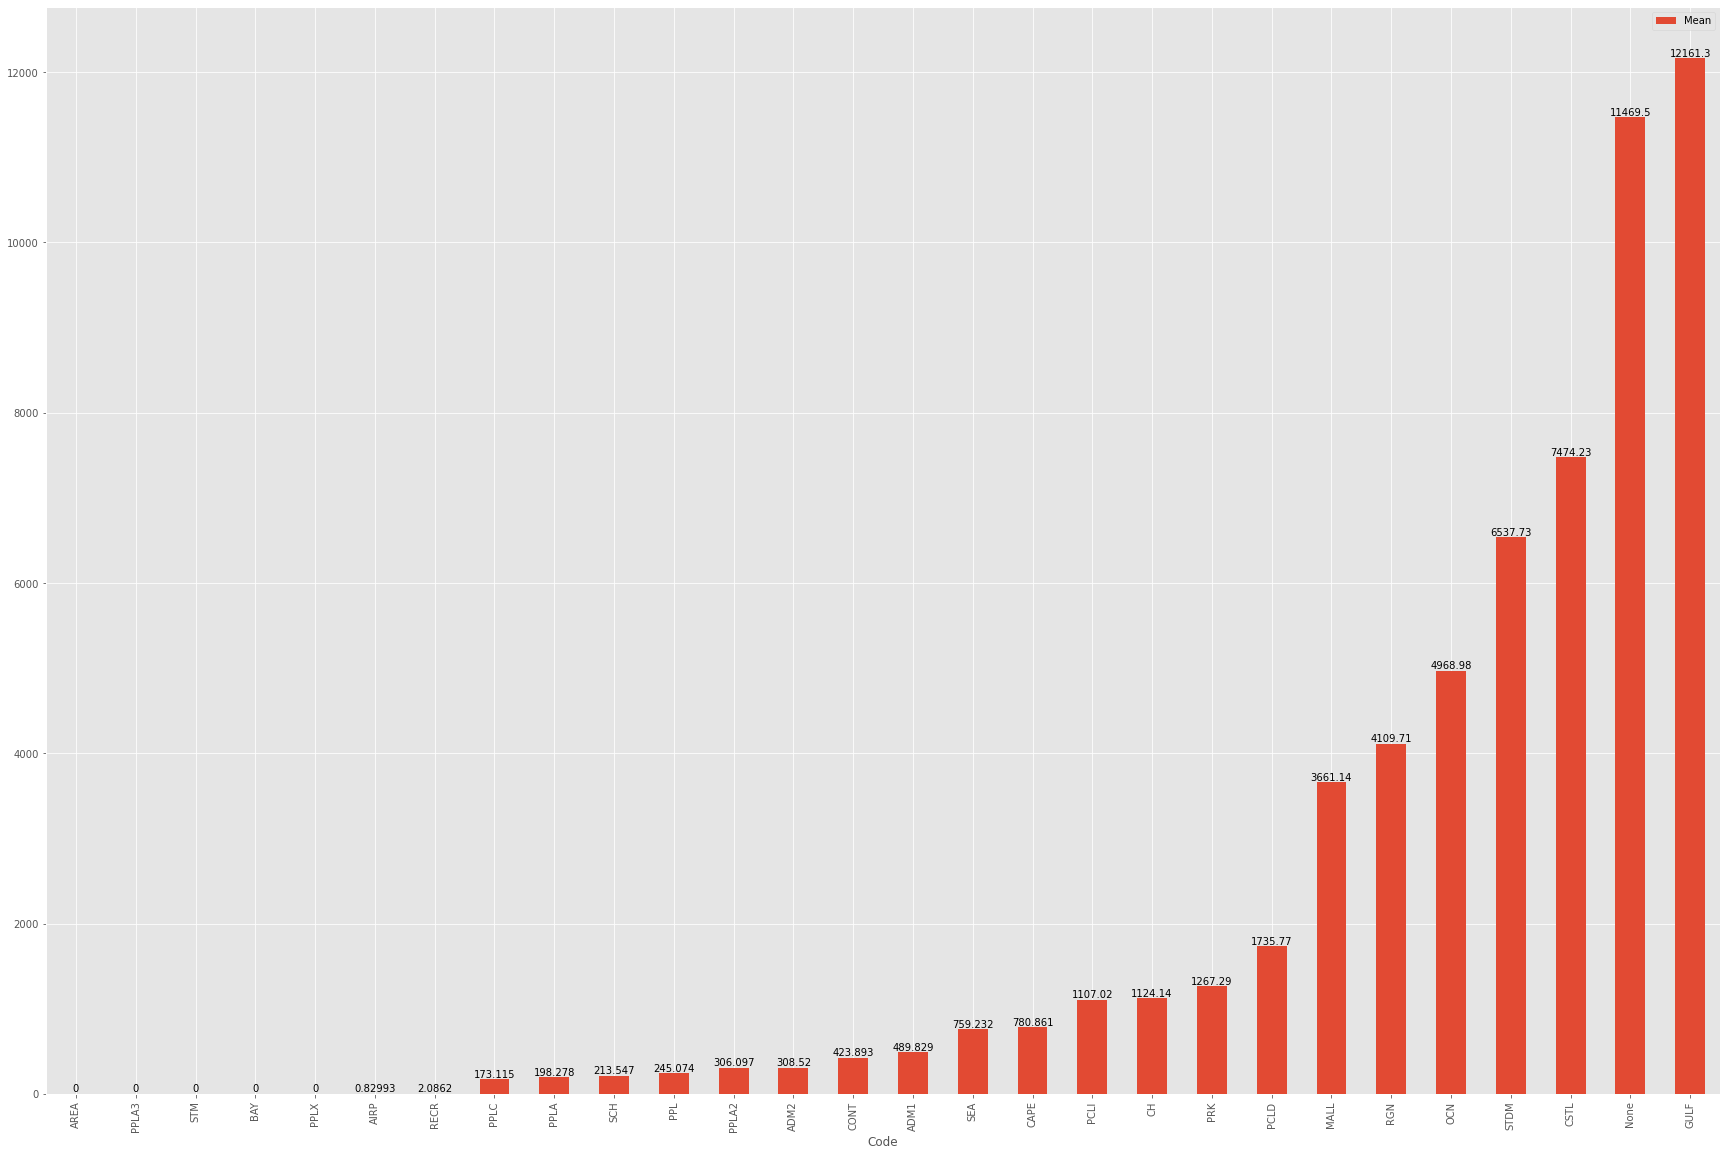

In [32]:
mean_errors_by_code = get_mean_error_by_feature_code(df_geocoded_clavin, False)
ax = pd.DataFrame(mean_errors_by_code.items(), columns=['Code', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Code", y="Mean", figsize=(30,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_code)

#### Erro por Feature Class

{'L': 1084.307723513505, 'A': 928.6454411840075, 'P': 221.3399392637866, 'S': 1788.9026890655862, 'H': 4224.634589402054, None: 11469.506286630376, 'T': 780.8613354537064}


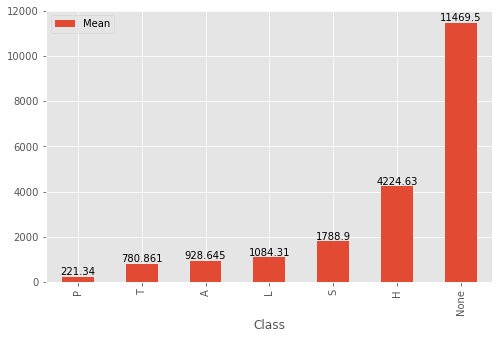

In [33]:
mean_errors_by_class = get_mean_error_by_feature_class(df_geocoded_clavin, False)
ax = pd.DataFrame(mean_errors_by_class.items(), columns=['Class', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Class", y="Mean", figsize=(8,5))
ax.bar_label(ax.containers[0])
print(mean_errors_by_class)

### HG

In [34]:
df_geocoded_hg = df_geowebnews[['file', 'text', 'toponyms']].copy()
df_geocoded_hg['geocoded'] = df_geocoded_clavin.progress_apply(lambda row: geocode_clavin_results(row.geocoded, geoparser, row.toponyms, exact_matching=True, process_demonyms=False, bounding_box=None, k=1, minimum_score=0, sort_by="population", minimization_classes=[], minimization_strategy="sum_dist"), axis=1)

unified_geocoded =  df_geocoded_hg['geocoded'].apply(lambda x: [t for t in x if t[4] is not None]).tolist()
unified_geocoded = [i for j in unified_geocoded for i in j]
print(len(unified_geocoded))

df_metrics_geocoded = pd.DataFrame(df_geocoded_hg.apply(lambda row: metrics(row.geocoded, row.toponyms, False, 161), axis=1).tolist(), index=df_geocoded_hg.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe().apply(lambda s: s.apply('{0:.6f}'.format))

Progress:   0%|          | 0/200 [00:00<?, ?it/s]

959


Geotag Precision Geotag Recall Geotag F1-Score Geocode Mean Distance  \
count       164.000000    199.000000      164.000000            164.000000   
mean          1.000000      0.379099        0.598179            392.850569   
std           0.000000      0.270675        0.210288           1105.984496   
min           1.000000      0.000000        0.076923              0.000000   
25%           1.000000      0.166667        0.444444              0.000000   
50%           1.000000      0.375000        0.600000              1.481109   
75%           1.000000      0.554094        0.736842            144.238401   
max           1.000000      1.000000        1.000000           7474.234564   

       Geocode Within Min Distance     @161 km         AUC Pct predicted  
count                   164.000000  164.000000  172.000000    199.000000  
mean                      0.843183    0.843183    0.108625      0.370443  
std                       0.291370    0.291370    0.173859      0.270004  
min                       0.000000    0.000000   -0.000000      0.000000  
25%                       0.813636    0.813636    0.000000      0.142857  
50%                       1.000000    1.000000    0.013542      0.350000  
75%                       1.000000    1.000000    0.140768      0.541958  
max                       1.000000    1.000000    0.762271      1.000000

#### Erro por Feature Code

{'PRK': 1900.9359395420356, 'PCLI': 100.83805720056287, 'ADM2': 124.71324389791265, 'PPLA': 20.092672018963675, 'PPL': 754.7797003937727, 'ADM1': 158.75230235885522, 'CONT': 16.777829437417573, 'PPLX': 2.3428740401539363e-12, 'SCH': 76.62807622363269, 'CH': 1124.1376141932856, 'PPLC': 687.8244006959659, 'SEA': 759.2320849145984, 'PPLA2': 184.3314858062137, 'PCLD': 17.90742246993344, 'RGN': 1296.6632126308448, 'PPLA3': 1661.5759973550535, 'AIRP': 3532.433475060221, 'AREA': 0.0, 'BAY': 0.0, 'OCN': 4796.588480626311, 'RECR': 2.0861995020818895, 'CSTL': 7474.23456395642, 'STM': 0.0, 'GULF': 10799.11705745284, None: 11469.506286630376, 'CAPE': 0.0, 'MALL': 3661.1385451740703}


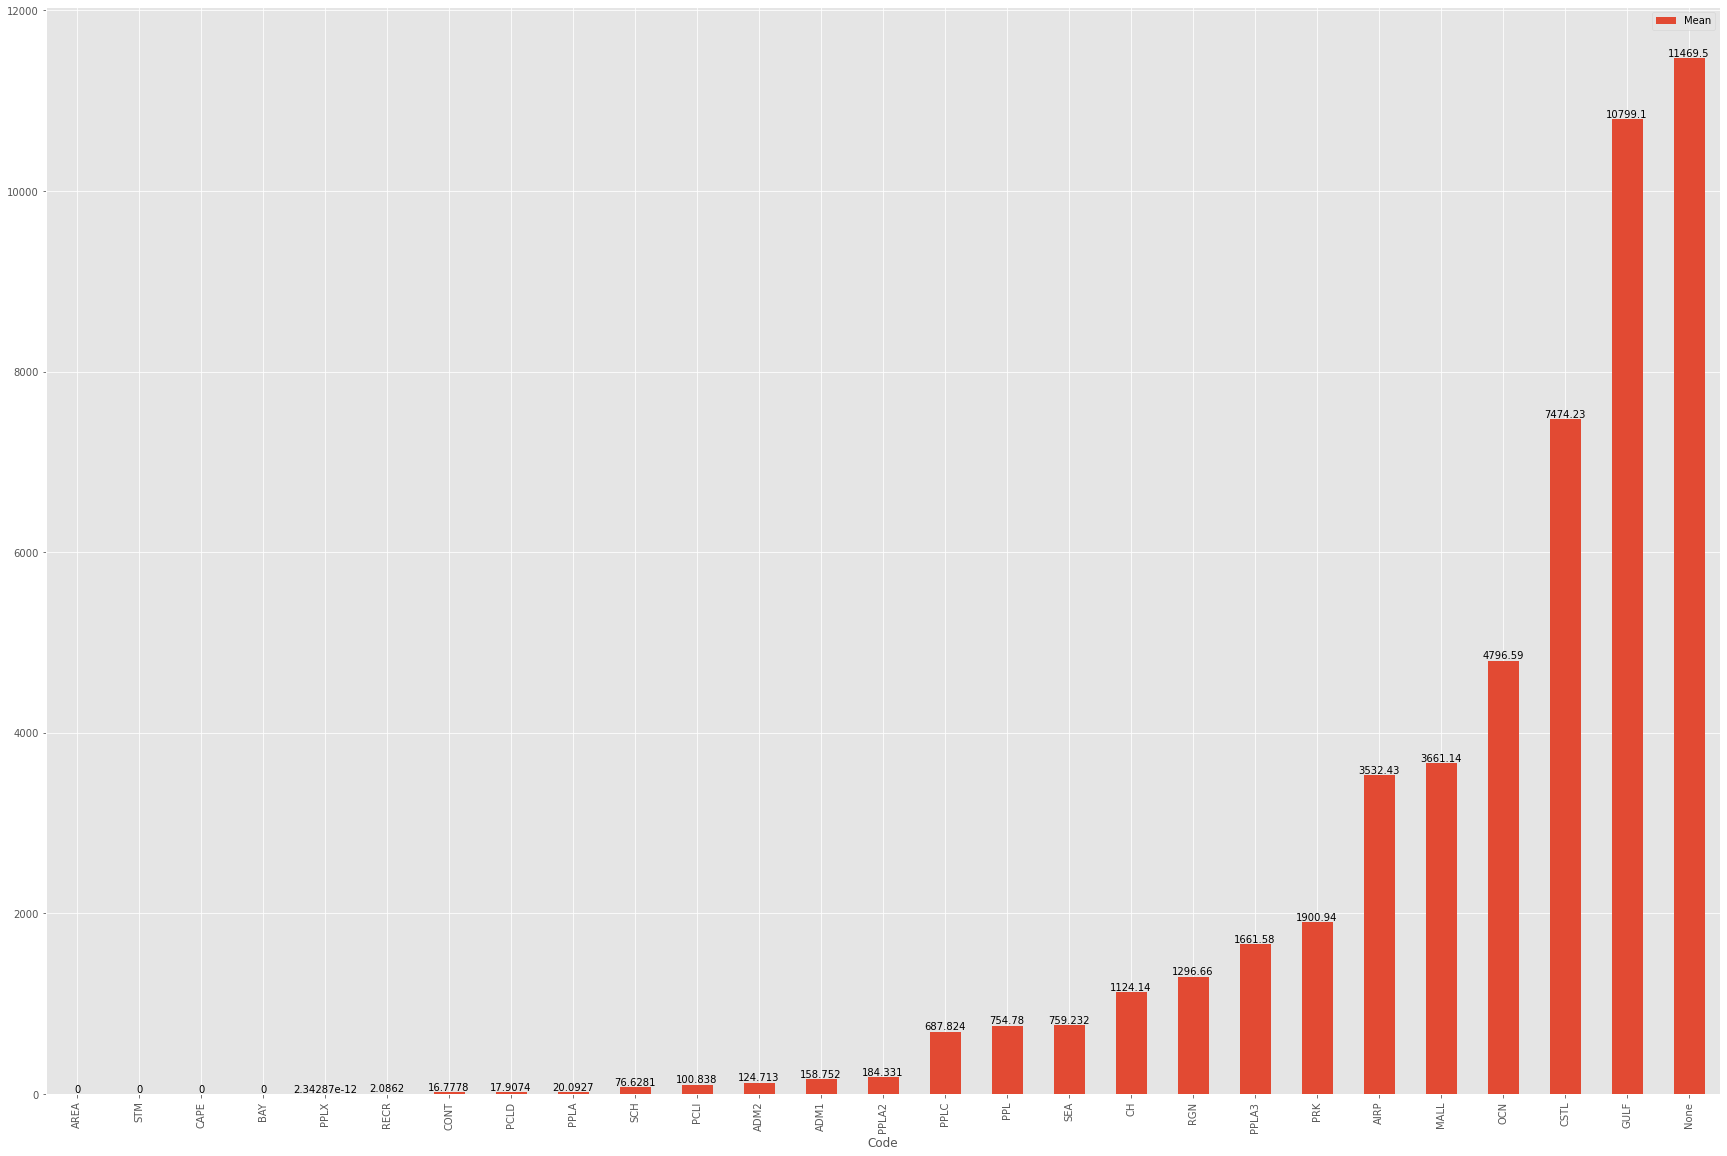

In [35]:
mean_errors_by_code = get_mean_error_by_feature_code(df_geocoded_hg, False)
ax = pd.DataFrame(mean_errors_by_code.items(), columns=['Code', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Code", y="Mean", figsize=(30,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_code)

#### Erro por Feature Class

{'L': 312.32054770002634, 'A': 114.69229905286555, 'P': 482.8958293429901, 'S': 1527.912338962441, 'H': 4018.897735569676, None: 11469.506286630376, 'T': 0.0}


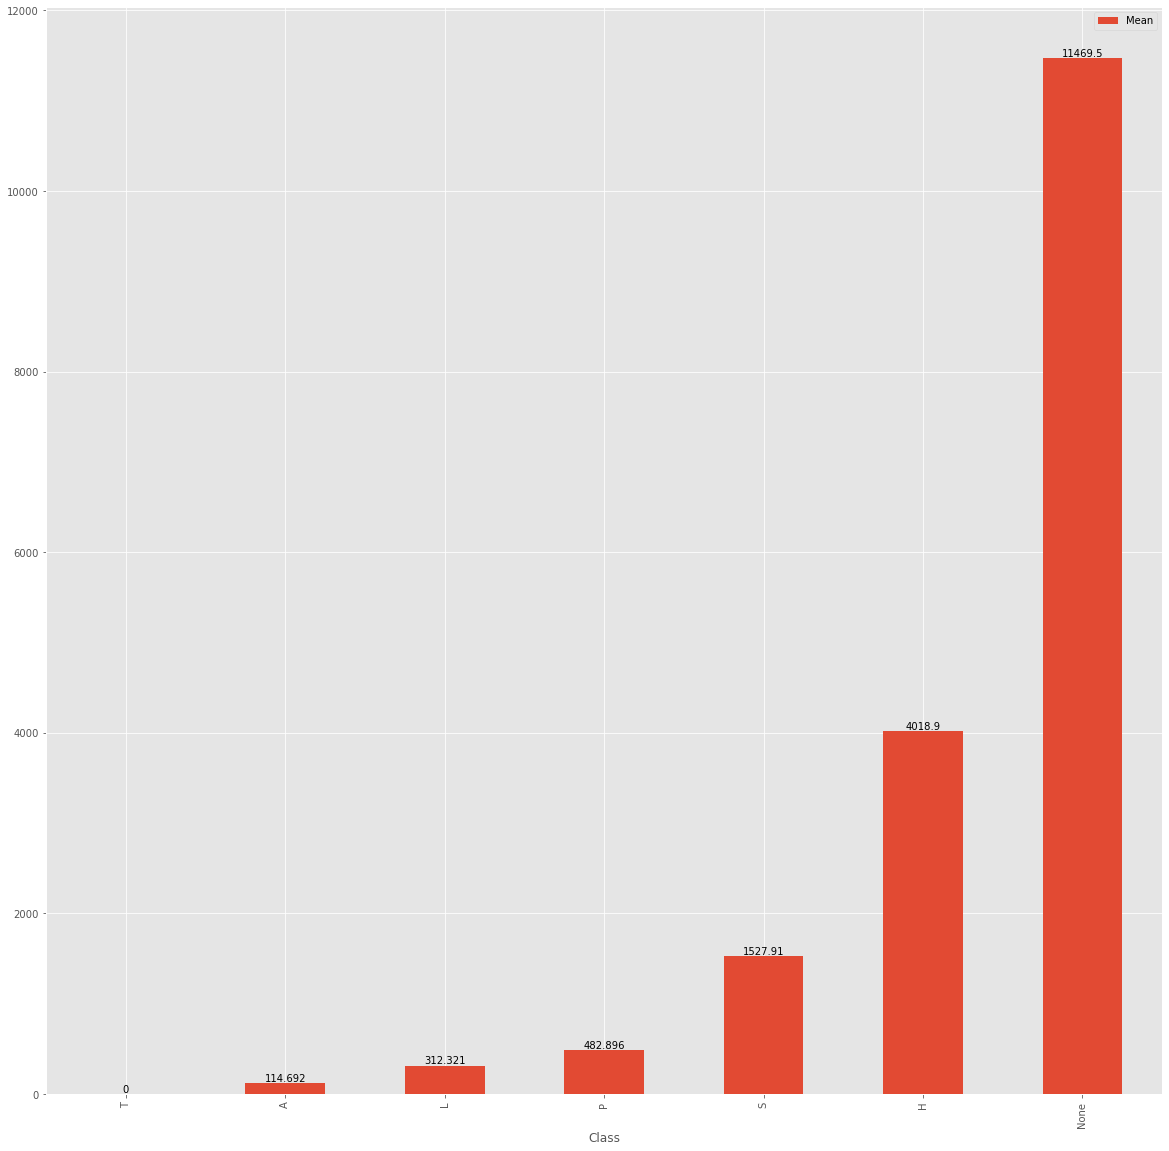

In [36]:
mean_errors_by_class = get_mean_error_by_feature_class(df_geocoded_hg, False)
ax = pd.DataFrame(mean_errors_by_class.items(), columns=['Class', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Class", y="Mean", figsize=(20,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_class)

#### CLAVIN vs HG

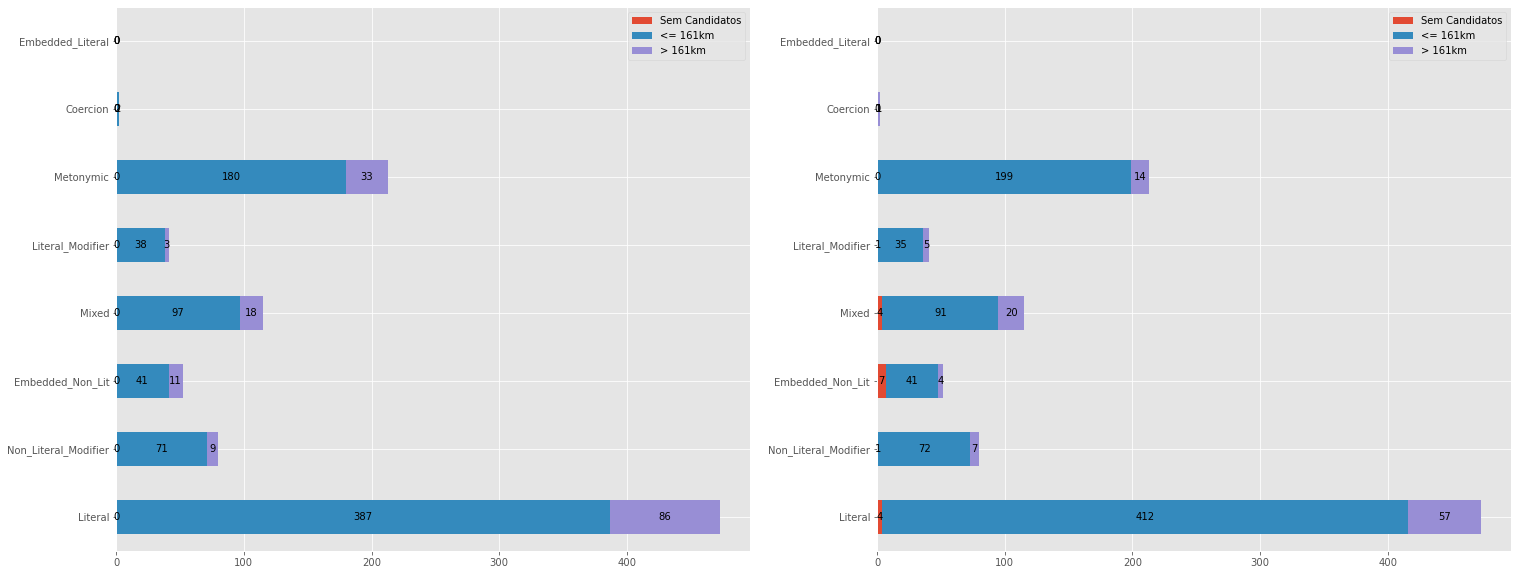

In [37]:
errors_by_type = count_errors_by_type(df_geocoded_hg)
df_errors_by_type_hg = pd.DataFrame(
    {key: pd.Series(value) for key, value in errors_by_type.items()})

plot_bars_stacked_diff(df_errors_by_type_clavin, df_errors_by_type_hg)

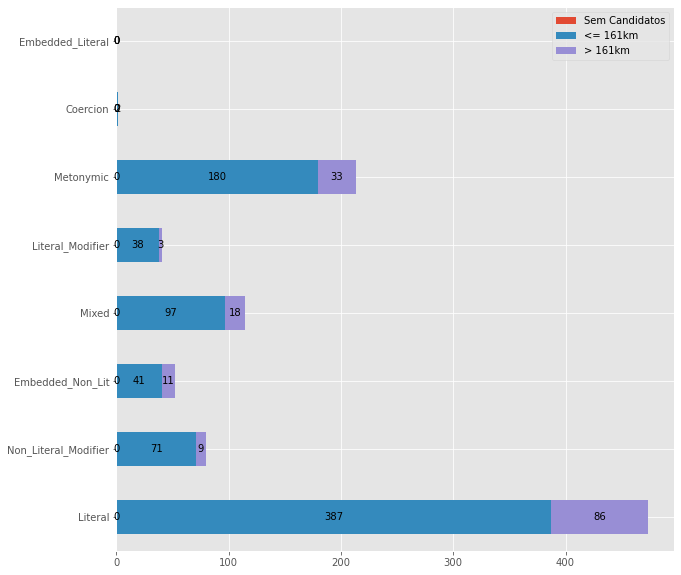

In [38]:
plot_bars_stacked(df_errors_by_type_clavin)

### HG-A

In [39]:
df_geocoded_hga = df_geowebnews[['file', 'text', 'toponyms']].copy()
df_geocoded_hga['geocoded'] = df_geocoded_clavin.progress_apply(lambda row: geocode_clavin_results(row.geocoded, geoparser, row.toponyms, exact_matching=True, process_demonyms=True, bounding_box=None, k=1, minimum_score=0, sort_by="population", minimization_classes=[], minimization_strategy="sum_dist"), axis=1)

unified_geocoded =  df_geocoded_hga['geocoded'].apply(lambda x: [t for t in x if t[4] is not None]).tolist()
unified_geocoded = [i for j in unified_geocoded for i in j]
print(len(unified_geocoded))

df_metrics_geocoded = pd.DataFrame(df_geocoded_hga.apply(lambda row: metrics(row.geocoded, row.toponyms, False, 161), axis=1).tolist(), index=df_geocoded_hga.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe().apply(lambda s: s.apply('{0:.6f}'.format))

Progress:   0%|          | 0/200 [00:00<?, ?it/s]

959


Geotag Precision Geotag Recall Geotag F1-Score Geocode Mean Distance  \
count       164.000000    199.000000      164.000000            164.000000   
mean          1.000000      0.379099        0.598179            392.850569   
std           0.000000      0.270675        0.210288           1105.984496   
min           1.000000      0.000000        0.076923              0.000000   
25%           1.000000      0.166667        0.444444              0.000000   
50%           1.000000      0.375000        0.600000              1.481109   
75%           1.000000      0.554094        0.736842            144.238401   
max           1.000000      1.000000        1.000000           7474.234564   

       Geocode Within Min Distance     @161 km         AUC Pct predicted  
count                   164.000000  164.000000  172.000000    199.000000  
mean                      0.843183    0.843183    0.108625      0.370443  
std                       0.291370    0.291370    0.173859      0.270004  
min                       0.000000    0.000000   -0.000000      0.000000  
25%                       0.813636    0.813636    0.000000      0.142857  
50%                       1.000000    1.000000    0.013542      0.350000  
75%                       1.000000    1.000000    0.140768      0.541958  
max                       1.000000    1.000000    0.762271      1.000000

#### Erro por Feature Code

{'PRK': 1900.9359395420356, 'PCLI': 100.83805720056287, 'ADM2': 124.71324389791265, 'PPLA': 20.092672018963675, 'PPL': 754.7797003937727, 'ADM1': 158.75230235885522, 'CONT': 16.777829437417573, 'PPLX': 2.3428740401539363e-12, 'SCH': 76.62807622363269, 'CH': 1124.1376141932856, 'PPLC': 687.8244006959659, 'SEA': 759.2320849145984, 'PPLA2': 184.3314858062137, 'PCLD': 17.90742246993344, 'RGN': 1296.6632126308448, 'PPLA3': 1661.5759973550535, 'AIRP': 3532.433475060221, 'AREA': 0.0, 'BAY': 0.0, 'OCN': 4796.588480626311, 'RECR': 2.0861995020818895, 'CSTL': 7474.23456395642, 'STM': 0.0, 'GULF': 10799.11705745284, None: 11469.506286630376, 'CAPE': 0.0, 'MALL': 3661.1385451740703}


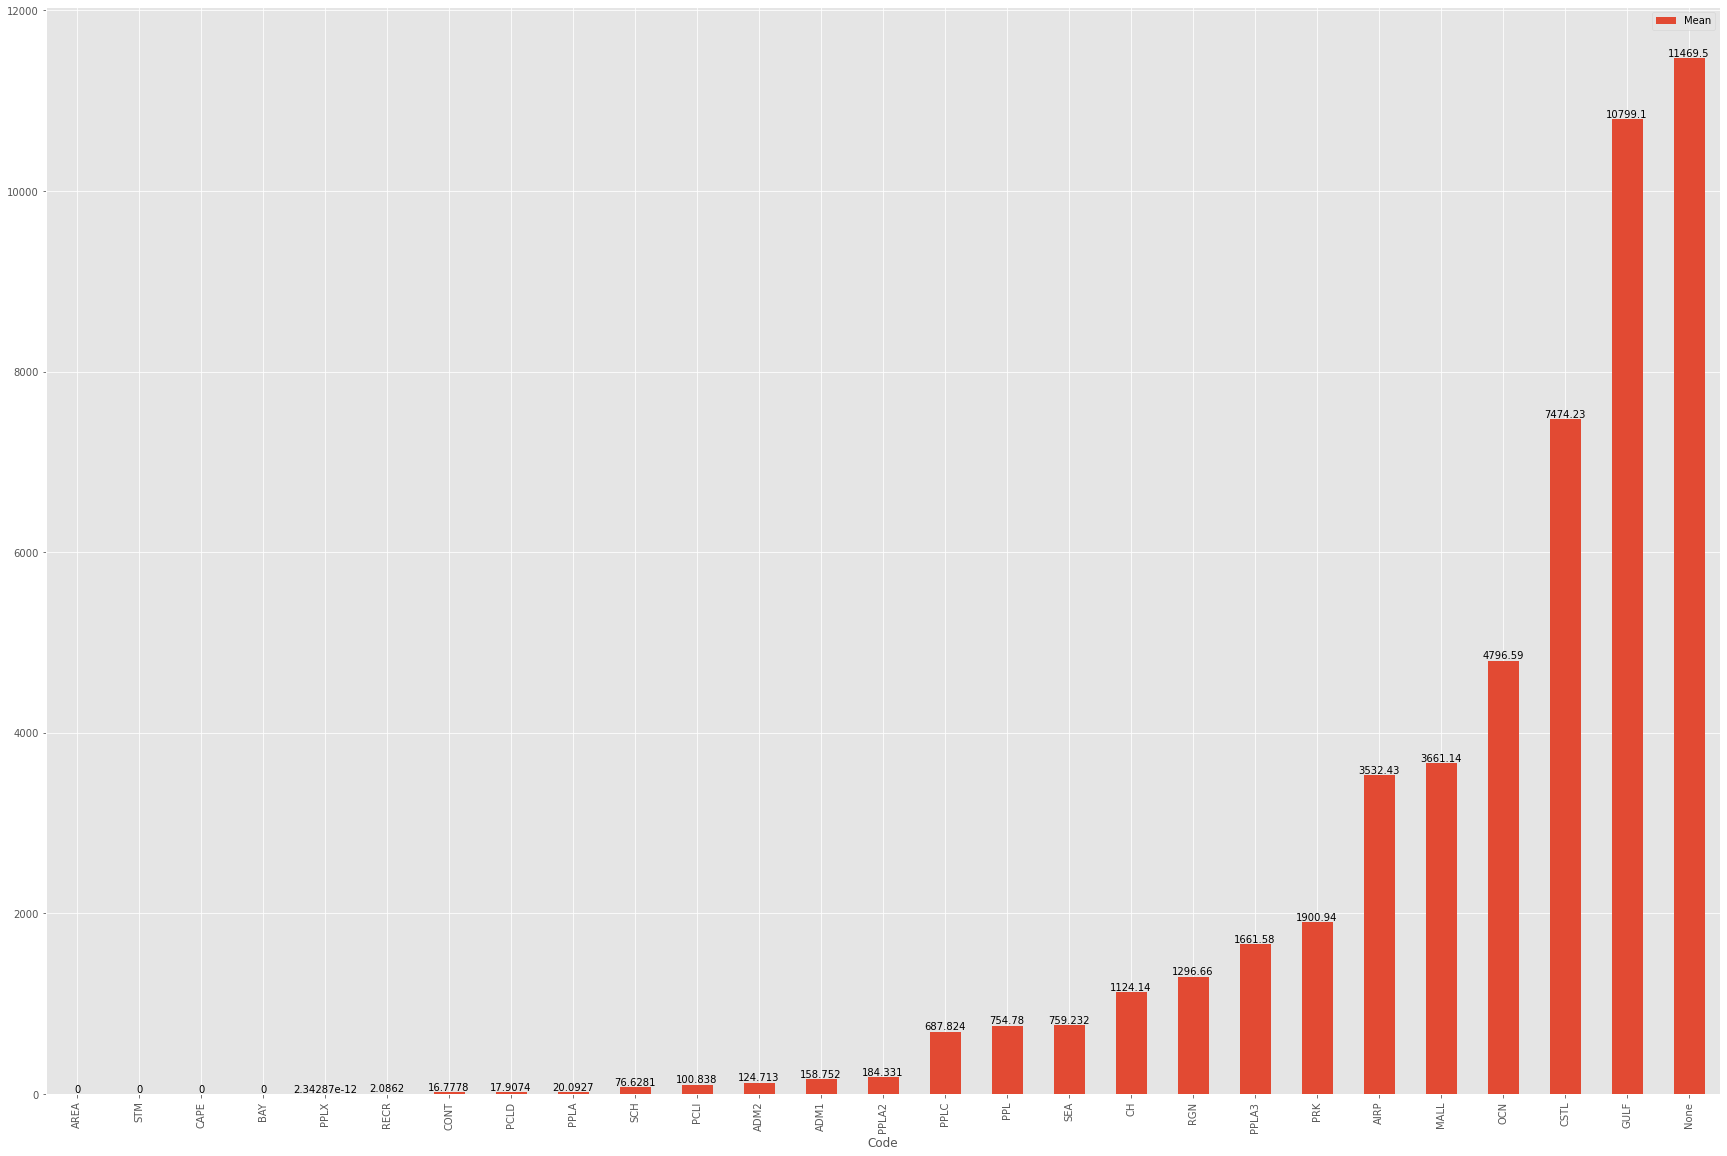

In [40]:
mean_errors_by_code = get_mean_error_by_feature_code(df_geocoded_hga, False)
ax = pd.DataFrame(mean_errors_by_code.items(), columns=['Code', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Code", y="Mean", figsize=(30,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_code)

#### Erro por Feature Class

{'L': 312.32054770002634, 'A': 114.69229905286555, 'P': 482.8958293429901, 'S': 1527.912338962441, 'H': 4018.897735569676, None: 11469.506286630376, 'T': 0.0}


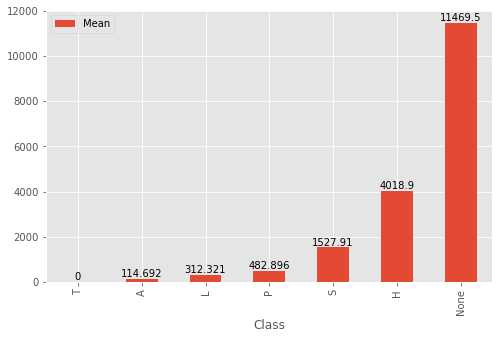

In [41]:
mean_errors_by_class = get_mean_error_by_feature_class(df_geocoded_hga, False)
ax = pd.DataFrame(mean_errors_by_class.items(), columns=['Class', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Class", y="Mean", figsize=(8,5))
ax.bar_label(ax.containers[0])
print(mean_errors_by_class)

#### CLAVIN vs HGA

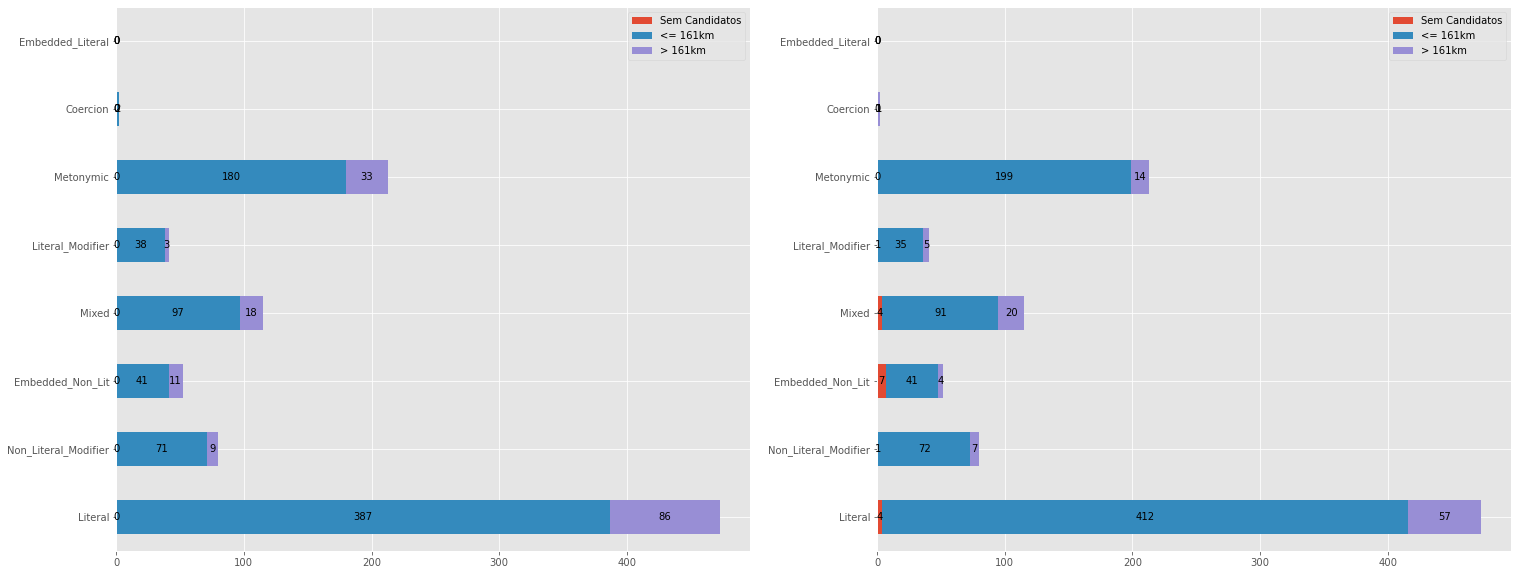

In [42]:
errors_by_type = count_errors_by_type(df_geocoded_hga)
df_errors_by_type_hga = pd.DataFrame(
    {key: pd.Series(value) for key, value in errors_by_type.items()})

plot_bars_stacked_diff(df_errors_by_type_clavin, df_errors_by_type_hga)

### HG-T

In [43]:
df_geocoded_hgt = df_geowebnews[['file', 'text', 'toponyms']].copy()
df_geocoded_hgt['geocoded'] = df_geocoded_clavin.progress_apply(lambda row: geocode_clavin_results(row.geocoded, geoparser, row.toponyms, exact_matching=True, process_demonyms=False, bounding_box=None, k=5, minimum_score=0, sort_by="population", minimization_classes=["Literal", "Mixed", "Literal_Modifier", "Coercion", "Embedded_Literal"], minimization_strategy="pop_by_mean_dist"), axis=1)

unified_geocoded =  df_geocoded_hgt['geocoded'].apply(lambda x: [t for t in x if t[4] is not None]).tolist()
unified_geocoded = [i for j in unified_geocoded for i in j]
print(len(unified_geocoded))

df_metrics_geocoded = pd.DataFrame(df_geocoded_hgt.apply(lambda row: metrics(row.geocoded, row.toponyms, False, 161), axis=1).tolist(), index=df_geocoded_hgt.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe().apply(lambda s: s.apply('{0:.6f}'.format))

Progress:   0%|          | 0/200 [00:00<?, ?it/s]

959


Geotag Precision Geotag Recall Geotag F1-Score Geocode Mean Distance  \
count       164.000000    199.000000      164.000000            164.000000   
mean          1.000000      0.379099        0.598179            391.895126   
std           0.000000      0.270675        0.210288           1106.020871   
min           1.000000      0.000000        0.076923              0.000000   
25%           1.000000      0.166667        0.444444              0.000000   
50%           1.000000      0.375000        0.600000              1.513375   
75%           1.000000      0.554094        0.736842            144.238401   
max           1.000000      1.000000        1.000000           7474.234564   

       Geocode Within Min Distance     @161 km         AUC Pct predicted  
count                   164.000000  164.000000  172.000000    199.000000  
mean                      0.844054    0.844054    0.108444      0.370443  
std                       0.291196    0.291196    0.173798      0.270004  
min                       0.000000    0.000000   -0.000000      0.000000  
25%                       0.820617    0.820617    0.000000      0.142857  
50%                       1.000000    1.000000    0.012802      0.350000  
75%                       1.000000    1.000000    0.140768      0.541958  
max                       1.000000    1.000000    0.762271      1.000000

#### Erro por Feature Code

{'PRK': 1900.9359395420356, 'PCLI': 101.05732865438333, 'ADM2': 100.18280764930927, 'PPLA': 20.092672018963675, 'PPL': 754.7797003937727, 'ADM1': 158.75230235885522, 'CONT': 16.777829437417573, 'PPLX': 2.3428740401539363e-12, 'SCH': 76.62807622363269, 'CH': 1124.1376141932856, 'PPLC': 687.7822144660324, 'SEA': 759.2320849145984, 'PPLA2': 182.1594730187299, 'PCLD': 17.90742246993344, 'RGN': 1296.6632126308448, 'PPLA3': 1661.5759973550535, 'AIRP': 3532.433475060221, 'AREA': 0.0, 'BAY': 0.0, 'OCN': 4796.588480626311, 'RECR': 2.0861995020818895, 'CSTL': 7474.23456395642, 'STM': 0.0, 'GULF': 10799.11705745284, None: 11469.506286630376, 'CAPE': 0.0, 'MALL': 3661.1385451740703}


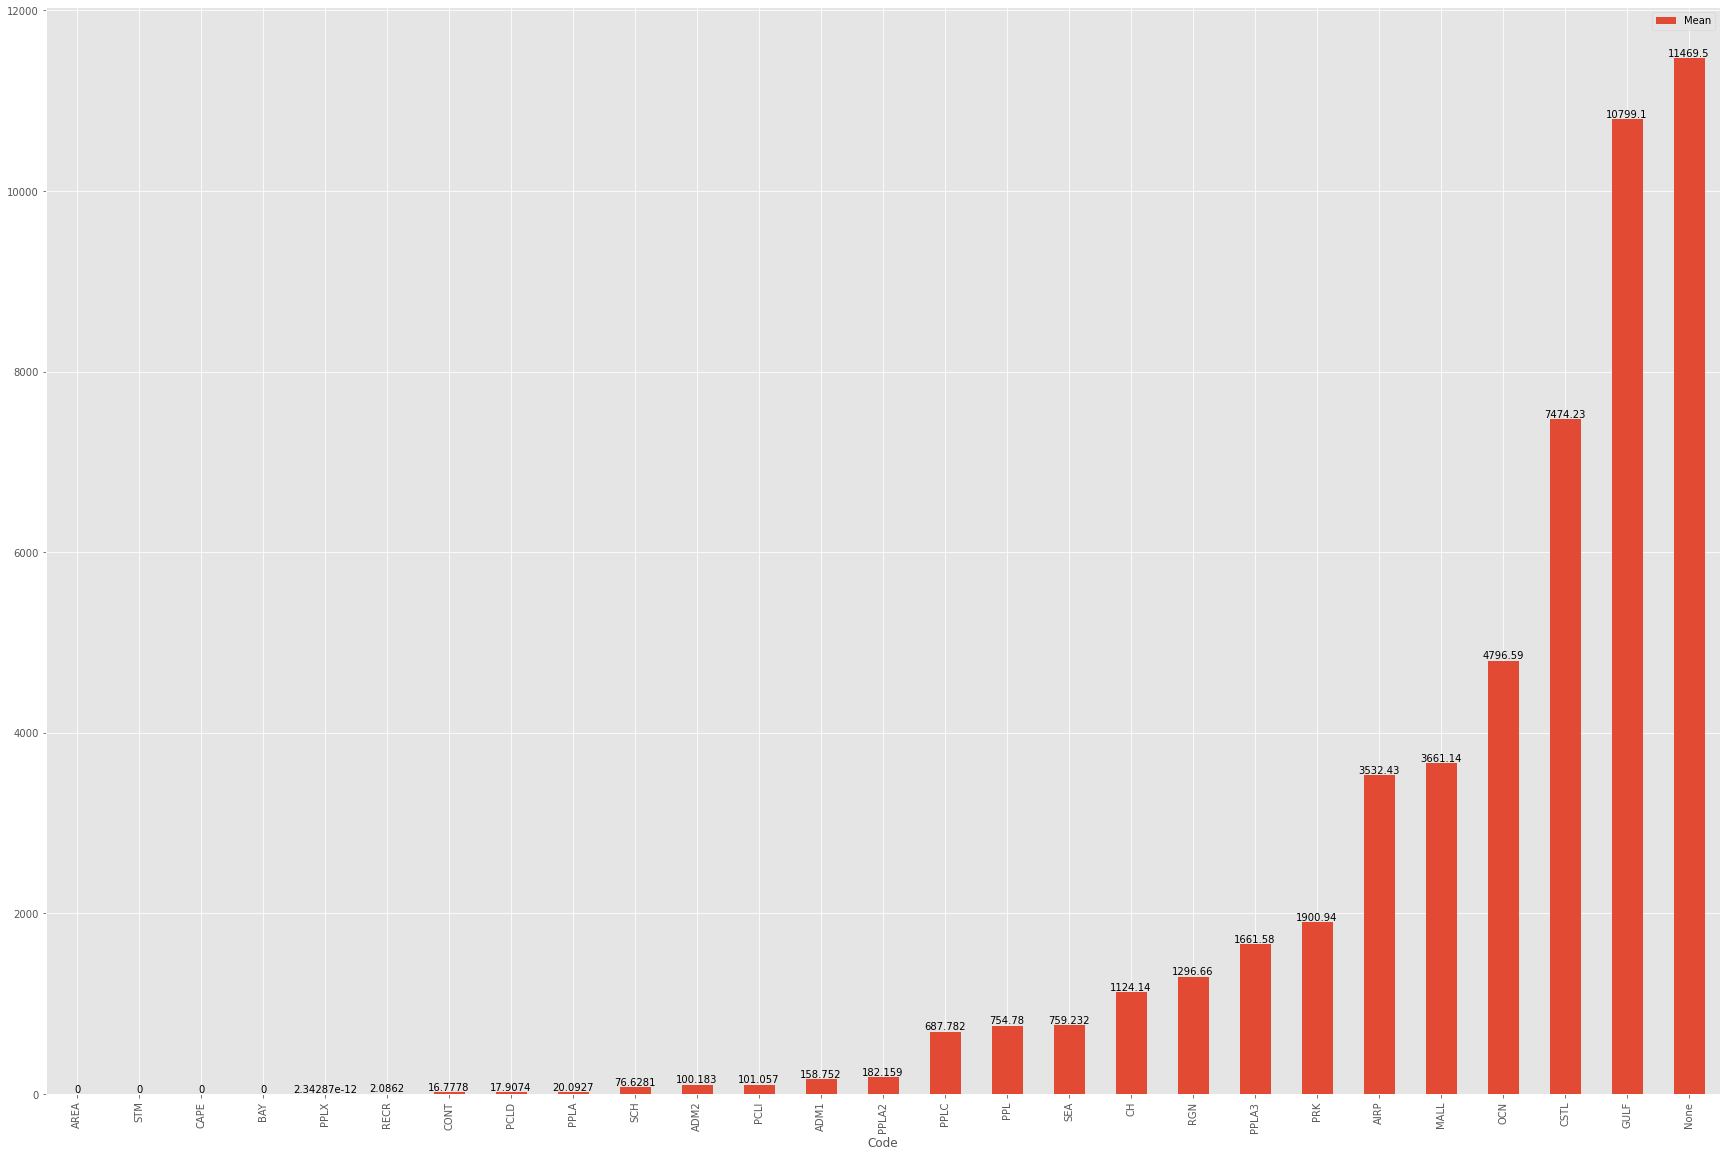

In [44]:
mean_errors_by_code = get_mean_error_by_feature_code(df_geocoded_hgt, False)
ax = pd.DataFrame(mean_errors_by_code.items(), columns=['Code', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Code", y="Mean", figsize=(30,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_code)

#### Erro por Feature Class

{'L': 312.32054770002634, 'A': 113.83240112537489, 'P': 482.2940918518861, 'S': 1527.912338962441, 'H': 4018.897735569676, None: 11469.506286630376, 'T': 0.0}


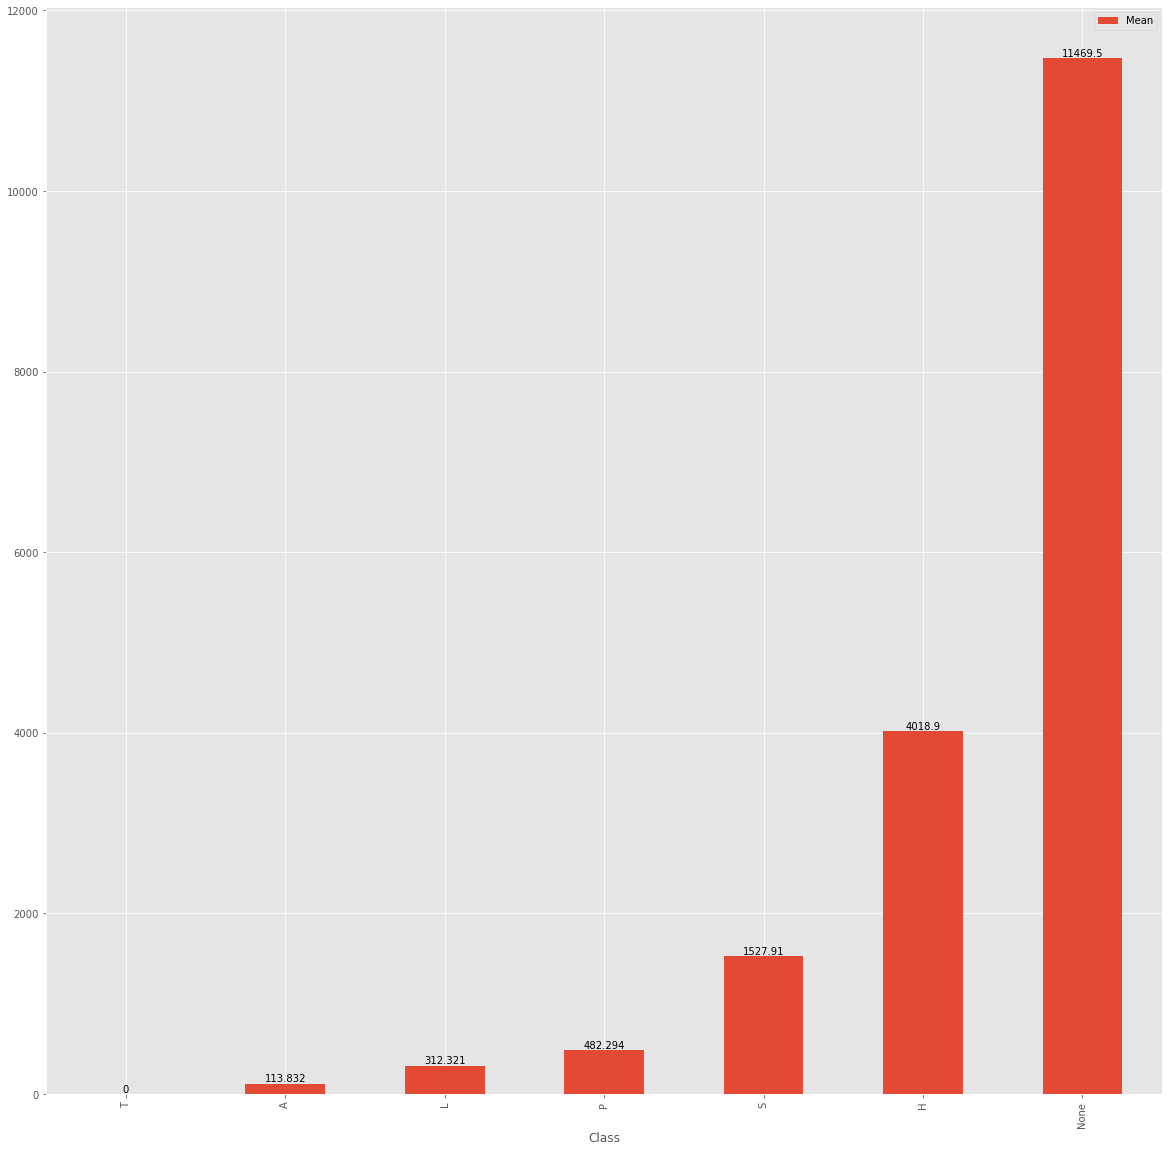

In [45]:
mean_errors_by_class = get_mean_error_by_feature_class(df_geocoded_hgt, False)
ax = pd.DataFrame(mean_errors_by_class.items(), columns=['Class', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Class", y="Mean", figsize=(20,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_class)

#### CLAVIN vs HGT

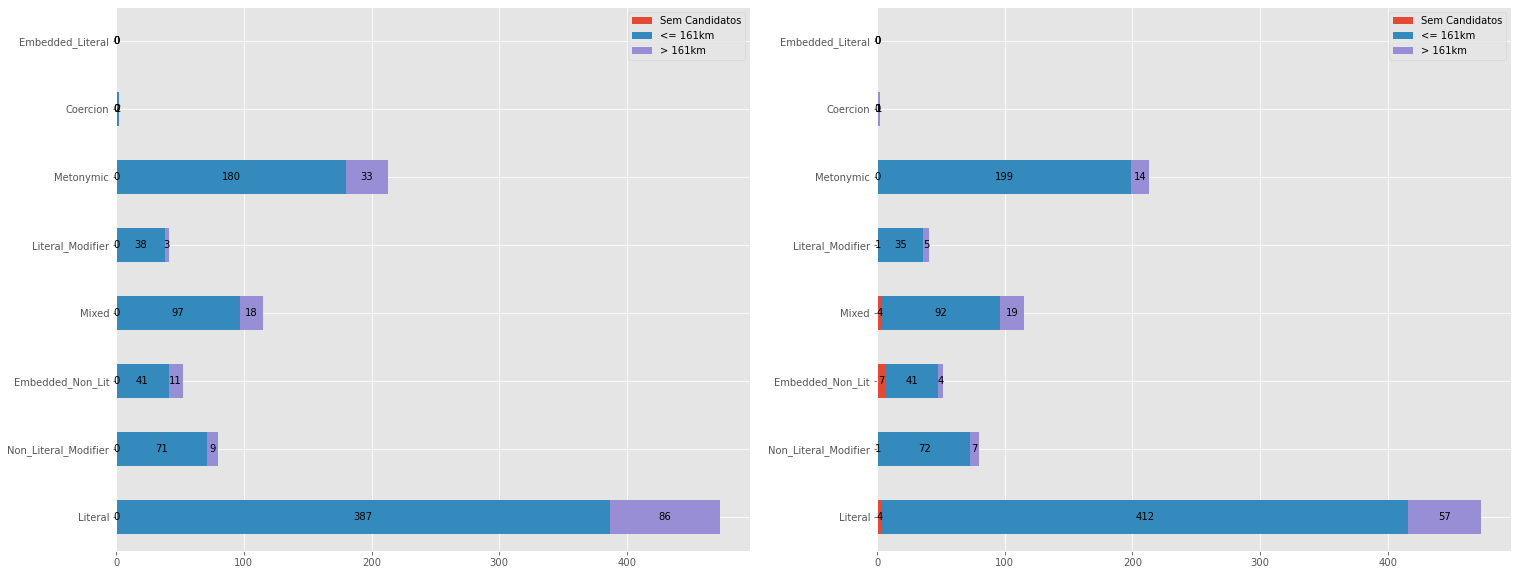

In [46]:
errors_by_type = count_errors_by_type(df_geocoded_hgt)
df_errors_by_type_hgt = pd.DataFrame(
    {key: pd.Series(value) for key, value in errors_by_type.items()})

plot_bars_stacked_diff(df_errors_by_type_clavin, df_errors_by_type_hgt)

### HG-AT

In [47]:
df_geocoded_hgat = df_geowebnews[['file', 'text', 'toponyms']].copy()
df_geocoded_hgat['geocoded'] = df_geocoded_clavin.progress_apply(lambda row: geocode_clavin_results(row.geocoded, geoparser, row.toponyms, exact_matching=True, process_demonyms=True, bounding_box=None, k=5, minimum_score=0, sort_by="population", minimization_classes=["Literal", "Mixed", "Literal_Modifier", "Coercion", "Embedded_Literal"], minimization_strategy="pop_by_mean_dist"), axis=1)

unified_geocoded =  df_geocoded_hgat['geocoded'].apply(lambda x: [t for t in x if t[4] is not None]).tolist()
unified_geocoded = [i for j in unified_geocoded for i in j]
print(len(unified_geocoded))

df_metrics_geocoded = pd.DataFrame(df_geocoded_hgat.apply(lambda row: metrics(row.geocoded, row.toponyms, False, 161), axis=1).tolist(), index=df_geocoded_hgat.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe().apply(lambda s: s.apply('{0:.6f}'.format))

Progress:   0%|          | 0/200 [00:00<?, ?it/s]

959


Geotag Precision Geotag Recall Geotag F1-Score Geocode Mean Distance  \
count       164.000000    199.000000      164.000000            164.000000   
mean          1.000000      0.379099        0.598179            391.895126   
std           0.000000      0.270675        0.210288           1106.020871   
min           1.000000      0.000000        0.076923              0.000000   
25%           1.000000      0.166667        0.444444              0.000000   
50%           1.000000      0.375000        0.600000              1.513375   
75%           1.000000      0.554094        0.736842            144.238401   
max           1.000000      1.000000        1.000000           7474.234564   

       Geocode Within Min Distance     @161 km         AUC Pct predicted  
count                   164.000000  164.000000  172.000000    199.000000  
mean                      0.844054    0.844054    0.108444      0.370443  
std                       0.291196    0.291196    0.173798      0.270004  
min                       0.000000    0.000000   -0.000000      0.000000  
25%                       0.820617    0.820617    0.000000      0.142857  
50%                       1.000000    1.000000    0.012802      0.350000  
75%                       1.000000    1.000000    0.140768      0.541958  
max                       1.000000    1.000000    0.762271      1.000000

#### Erro por Feature Code

{'PRK': 1900.9359395420356, 'PCLI': 101.05732865438333, 'ADM2': 100.18280764930927, 'PPLA': 20.092672018963675, 'PPL': 754.7797003937727, 'ADM1': 158.75230235885522, 'CONT': 16.777829437417573, 'PPLX': 2.3428740401539363e-12, 'SCH': 76.62807622363269, 'CH': 1124.1376141932856, 'PPLC': 687.7822144660324, 'SEA': 759.2320849145984, 'PPLA2': 182.1594730187299, 'PCLD': 17.90742246993344, 'RGN': 1296.6632126308448, 'PPLA3': 1661.5759973550535, 'AIRP': 3532.433475060221, 'AREA': 0.0, 'BAY': 0.0, 'OCN': 4796.588480626311, 'RECR': 2.0861995020818895, 'CSTL': 7474.23456395642, 'STM': 0.0, 'GULF': 10799.11705745284, None: 11469.506286630376, 'CAPE': 0.0, 'MALL': 3661.1385451740703}


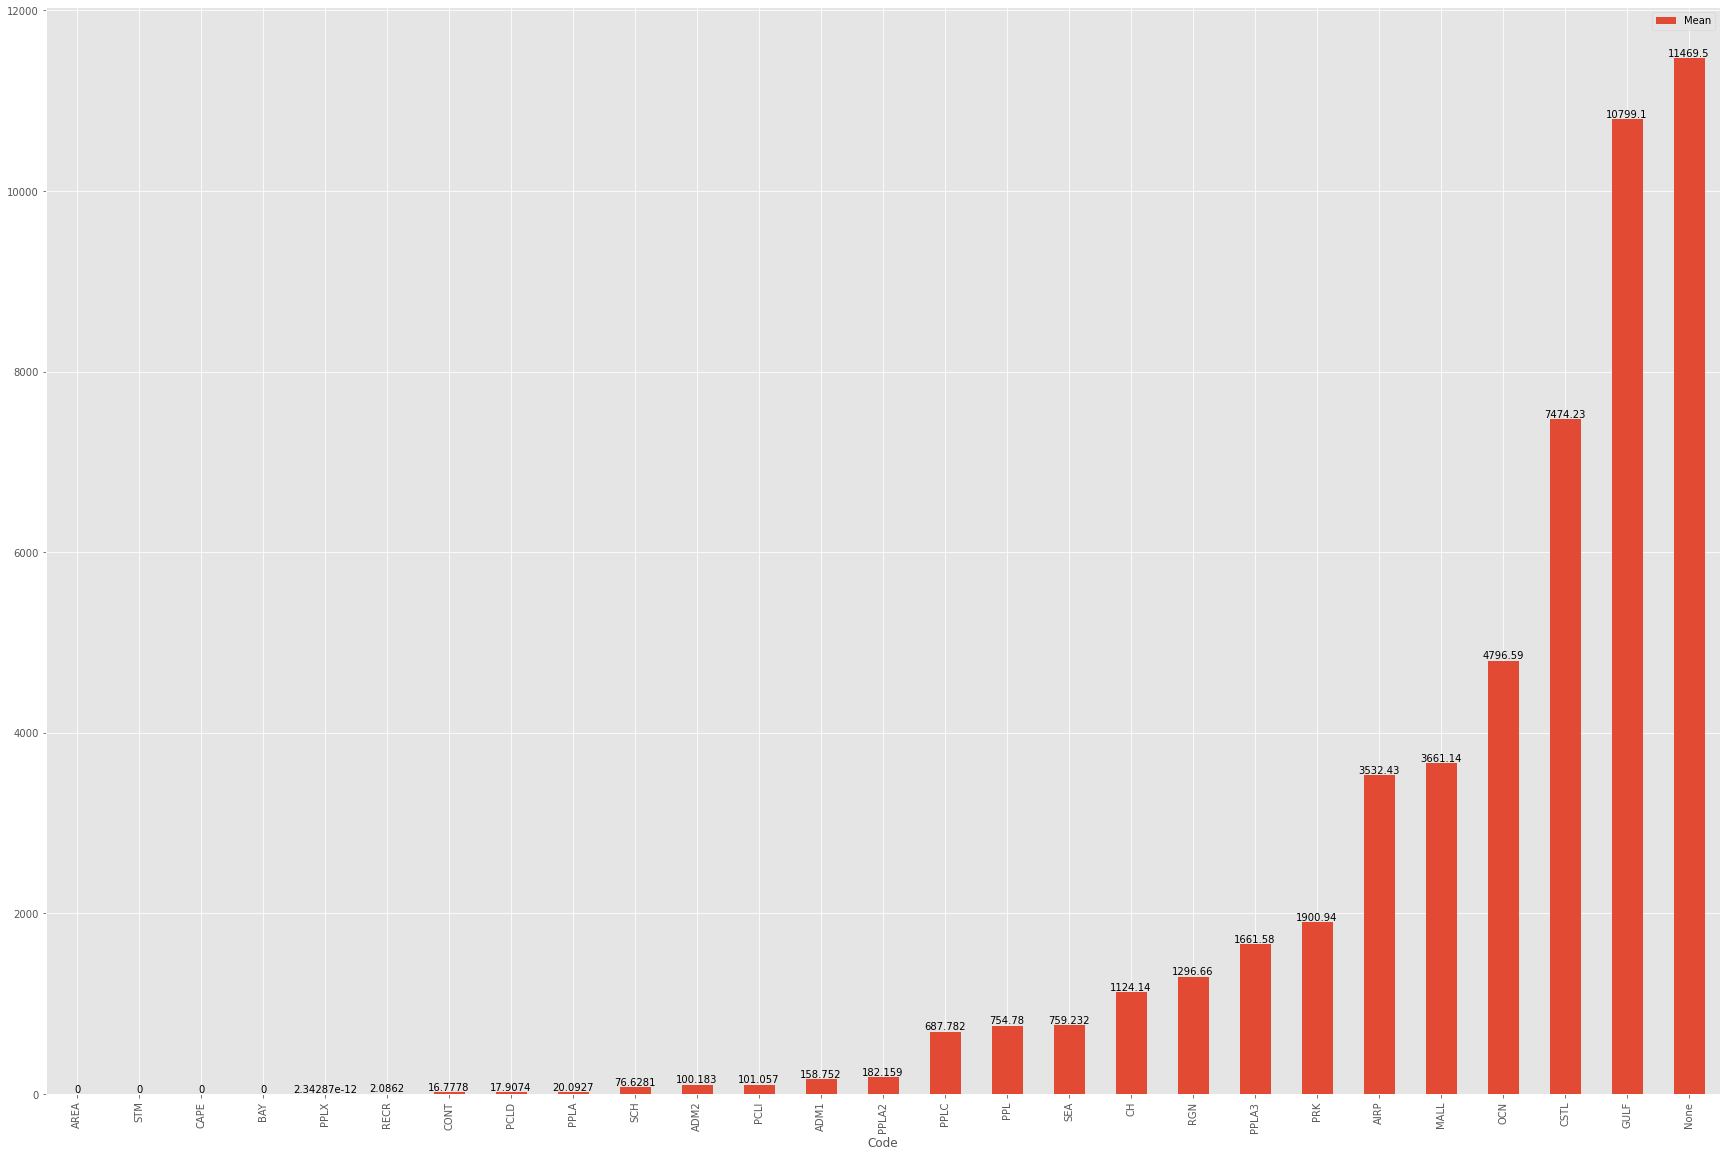

In [48]:
mean_errors_by_code = get_mean_error_by_feature_code(df_geocoded_hgat, False)
ax = pd.DataFrame(mean_errors_by_code.items(), columns=['Code', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Code", y="Mean", figsize=(30,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_code)

#### Erro por Feature Class

{'L': 312.32054770002634, 'A': 113.83240112537489, 'P': 482.2940918518861, 'S': 1527.912338962441, 'H': 4018.897735569676, None: 11469.506286630376, 'T': 0.0}


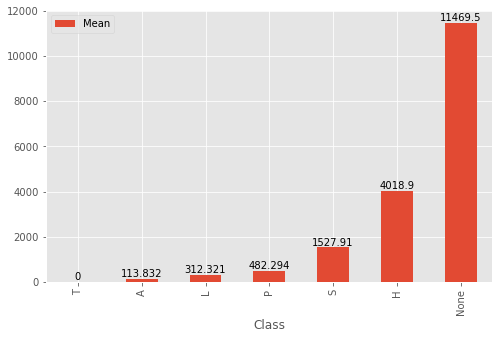

In [49]:
mean_errors_by_class = get_mean_error_by_feature_class(df_geocoded_hgat, False)
ax = pd.DataFrame(mean_errors_by_class.items(), columns=['Class', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Class", y="Mean", figsize=(8,5))
ax.bar_label(ax.containers[0])
print(mean_errors_by_class)

#### CLAVIN vs HGAT

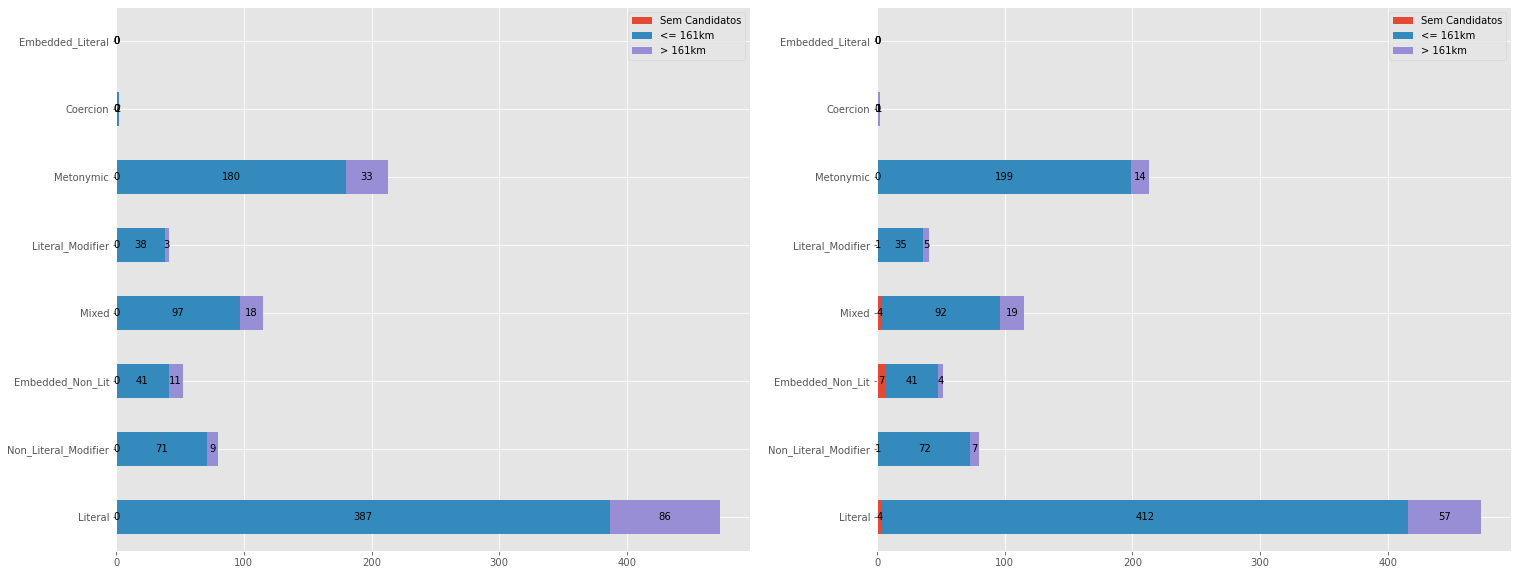

<Figure size 432x288 with 0 Axes>

In [50]:
errors_by_type = count_errors_by_type(df_geocoded_hgat)
df_errors_by_type_hgat = pd.DataFrame(
    {key: pd.Series(value) for key, value in errors_by_type.items()})

plot_bars_stacked_diff(df_errors_by_type_clavin, df_errors_by_type_hgat)
plt.savefig('result_geowebnews_clavin_demonyms.pdf', bbox_inches='tight')  

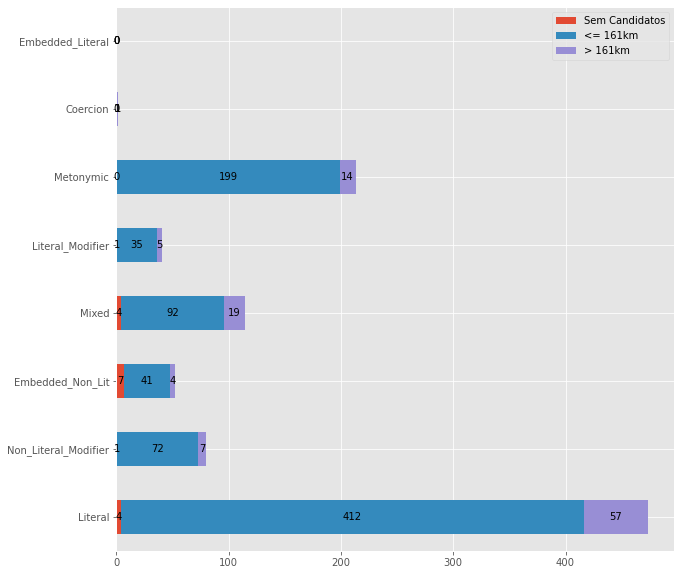

In [51]:
plot_bars_stacked(df_errors_by_type_hgat)

<AxesSubplot:>

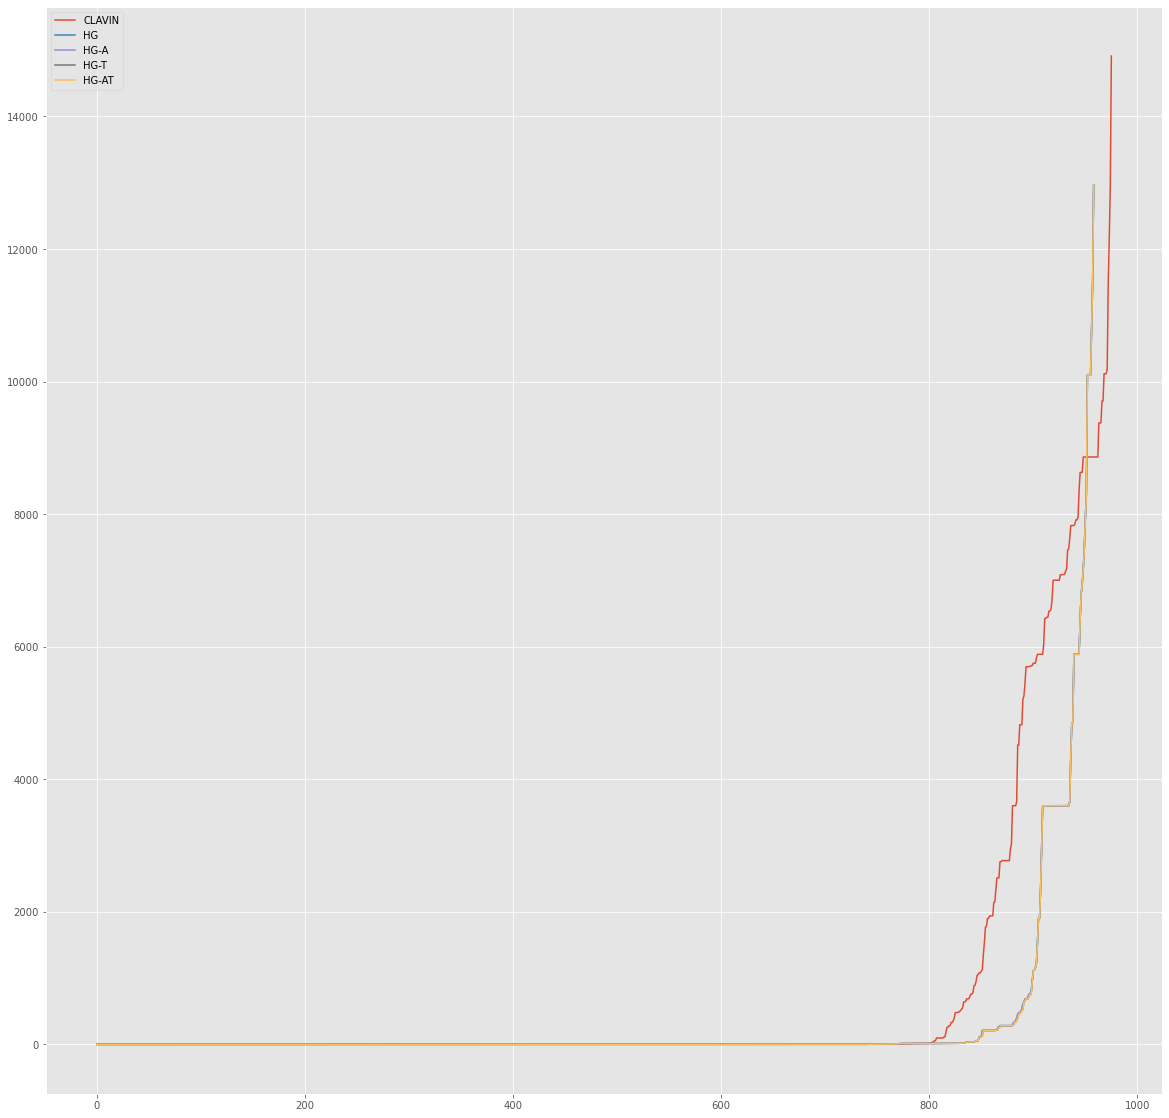

In [52]:
distances_clavin = sorted([i for j in df_geocoded_clavin.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms, False), axis=1).tolist() for i in j])
distances_hg = sorted([i for j in df_geocoded_hg.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms, False), axis=1).tolist() for i in j])
distances_hga = sorted([i for j in df_geocoded_hga.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms, False), axis=1).tolist() for i in j])
distances_hgt = sorted([i for j in df_geocoded_hgt.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms, False), axis=1).tolist() for i in j])
distances_hgat = sorted([i for j in df_geocoded_hgat.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms, False), axis=1).tolist() for i in j])
distances_dict = { "CLAVIN": distances_clavin, "HG": distances_hg, "HG-A": distances_hga, "HG-T": distances_hgt, "HG-AT": distances_hgat}
df_errors = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in distances_dict.items() ]))
df_errors[["CLAVIN", "HG", "HG-A", "HG-T", "HG-AT"]].plot(figsize=(20,20))

In [53]:
for c in df_geocoded_clavin[df_geocoded_clavin["file"] == 104].iloc[0].geocoded:
    print(c)
    for t in df_geocoded_hgat[df_geocoded_hgat["file"] == 104].iloc[0].geocoded:
        if t[0] == c[0]:
            print(t)
    print()

(102, 113, 'Connecticut', '', (4831725, 'Connecticut', 41.66704, -72.66648, 'A', 3527249, 1.0))
(102, 113, 'Connecticut', 'Metonymic', (4831725, 'Connecticut', 41.66704, -72.66648, 'A', 3527249, 3.0))

(221, 229, 'Columbus', '', (4509177, 'Columbus', 39.96118, -82.99879, 'P', 850106, 1.0))
(221, 229, 'Columbus', 'Literal', (4509177, 'Columbus', 39.96118, -82.99879, 'P', 850106, 3.0))

(231, 235, 'Ohio', '', (5165418, 'Ohio', 40.25034, -83.00018, 'A', 11467123, 1.0))
(231, 235, 'Ohio', 'Literal', (5165418, 'Ohio', 40.25034, -83.00018, 'A', 11467123, 3.0))

(293, 297, 'Ohio', '', (5165418, 'Ohio', 40.25034, -83.00018, 'A', 11467123, 1.0))
(293, 297, 'Ohio', 'Mixed', (5165418, 'Ohio', 40.25034, -83.00018, 'A', 11467123, 3.0))

(631, 641, 'Louisville', '', (5161347, 'Louisville', 40.83728, -81.25955, 'P', 9126, 1.0))
(631, 641, 'Louisville', 'Metonymic', (4299276, 'Louisville', 38.25424, -85.75941, 'P', 243639, 3.0))

(1827, 1837, 'Louisville', '', (4299276, 'Louisville', 38.25424, -85.759

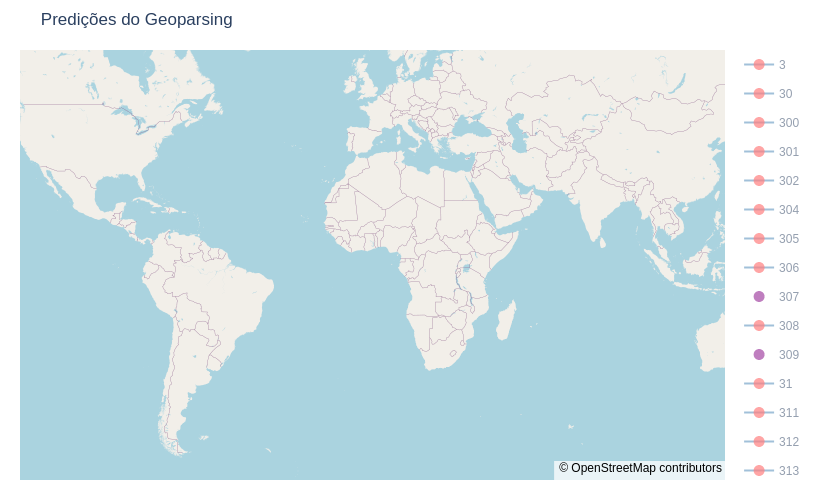

In [54]:
fig = go.Figure()

# 244

df_geocoded_hgat[180:200][['toponyms', 'geocoded', 'file']].apply(lambda row: plot_toponyms_predictions(
    row[0], row[1], fig, filename=row[2], visible='legendonly'), axis=1)

fig.update_layout(mapbox_style="open-street-map", height=500)
fig.update_layout(margin={"r": 10, "t": 50, "l": 20,
                  "b": 20}, title="Predições do Geoparsing")
fig.show()


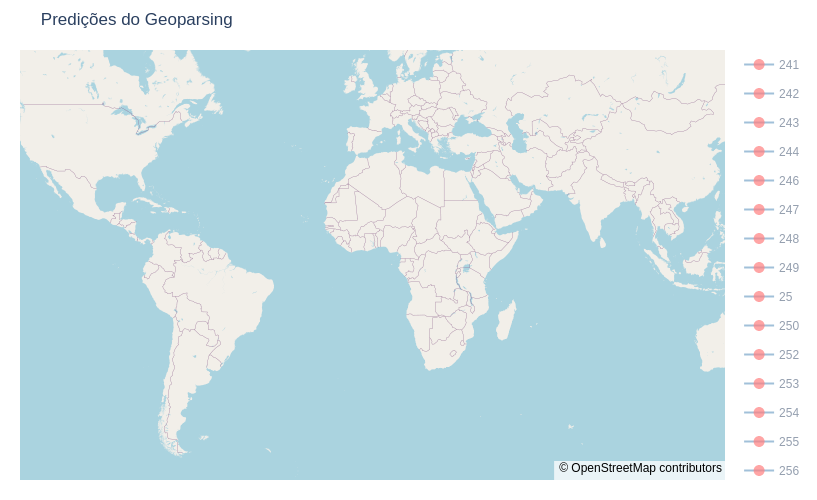

In [55]:
fig = go.Figure()

df_geocoded_clavin[120:140][['toponyms', 'geocoded', 'file']].apply(lambda row: plot_toponyms_predictions(
    row[0], row[1], fig, filename=row[2], visible='legendonly'), axis=1)

fig.update_layout(mapbox_style="open-street-map", height=500)
fig.update_layout(margin={"r": 10, "t": 50, "l": 20,
                  "b": 20}, title="Predições do Geoparsing")
fig.show()


### Mesmos Topônimos

In [56]:
toponyms_in = []
for (i, toponyms), (j, geocoded_hg), (k, geocoded_hga), (l, geocoded_hgt), (m, geocoded_hgat), (n, geocoded_cl) in zip(df_geowebnews[['toponyms']].iterrows(), df_geocoded_hg[["geocoded"]].iterrows(), df_geocoded_hga[["geocoded"]].iterrows(), df_geocoded_hgt[["geocoded"]].iterrows(), df_geocoded_hgat[["geocoded"]].iterrows(), df_geocoded_clavin[["geocoded"]].iterrows()):
    found_hg = []
    truth = toponyms[0].copy()
    for pred in geocoded_hg[0]:
        for _, gt in enumerate(truth[:]):
            if ner_equal(pred, gt, exact_match=False) and pred[4] is not None:
                found_hg.append(gt)
                del truth[_]
                break
                
    found_hga = []
    truth = toponyms[0].copy()
    for pred in geocoded_hga[0]:
        for _, gt in enumerate(truth[:]):
            if ner_equal(pred, gt, exact_match=False) and pred[4] is not None:
                found_hga.append(gt)
                del truth[_]
                break
                
    found_hgt = []
    truth = toponyms[0].copy()
    for pred in geocoded_hgt[0]:
        for _, gt in enumerate(truth[:]):
            if ner_equal(pred, gt, exact_match=False) and pred[4] is not None:
                found_hgt.append(gt)
                del truth[_]
                break
                
    found_hgat = []
    truth = toponyms[0].copy()
    for pred in geocoded_hgat[0]:
        for _, gt in enumerate(truth[:]):
            if ner_equal(pred, gt, exact_match=False) and pred[4] is not None:
                found_hgat.append(gt)
                del truth[_]
                break
                
    found_cl = []
    truth = toponyms[0].copy()
    for pred in geocoded_cl[0]:
        for _, gt in enumerate(truth[:]):
            if ner_equal(pred, gt, exact_match=False) and pred[4] is not None:
                found_cl.append(gt)
                del truth[_]
                break
    
    found_in = set.intersection(*map(set, [found_hg, found_hga, found_hgt, found_hgat, found_cl]))
    toponyms_in.append(list(found_in))    

toponyms_in = pd.DataFrame({"toponyms_in": toponyms_in})

In [57]:
unified_geocoded =  toponyms_in["toponyms_in"].tolist()
unified_geocoded = [i for j in unified_geocoded for i in j]
print(len(unified_geocoded))

959


#### HG

In [58]:
df_geocoded_hg["toponyms_in"] = toponyms_in
df_metrics_geocoded = pd.DataFrame(df_geocoded_hg.apply(lambda row: metrics(row.geocoded, row.toponyms_in, False, 161), axis=1).tolist(), index=df_geocoded_hg.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe().apply(lambda s: s.apply('{0:.6f}'.format))

Geotag Precision Geotag Recall Geotag F1-Score Geocode Mean Distance  \
count       164.000000    164.000000      164.000000            164.000000   
mean          0.974467      1.000000        0.983639            392.850569   
std           0.099846      0.000000        0.068695           1105.984496   
min           0.333333      1.000000        0.500000              0.000000   
25%           1.000000      1.000000        1.000000              0.000000   
50%           1.000000      1.000000        1.000000              1.481109   
75%           1.000000      1.000000        1.000000            144.238401   
max           1.000000      1.000000        1.000000           7474.234564   

       Geocode Within Min Distance     @161 km         AUC Pct predicted  
count                   164.000000  164.000000  172.000000    164.000000  
mean                      0.843183    0.843183    0.108625      1.000000  
std                       0.291370    0.291370    0.173859      0.000000  
min                       0.000000    0.000000   -0.000000      1.000000  
25%                       0.813636    0.813636    0.000000      1.000000  
50%                       1.000000    1.000000    0.013542      1.000000  
75%                       1.000000    1.000000    0.140768      1.000000  
max                       1.000000    1.000000    0.762271      1.000000

#### HG-A

In [59]:
df_geocoded_hga["toponyms_in"] = toponyms_in
df_metrics_geocoded = pd.DataFrame(df_geocoded_hga.apply(lambda row: metrics(row.geocoded, row.toponyms_in, False, 161), axis=1).tolist(), index=df_geocoded_hga.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe().apply(lambda s: s.apply('{0:.6f}'.format))

Geotag Precision Geotag Recall Geotag F1-Score Geocode Mean Distance  \
count       164.000000    164.000000      164.000000            164.000000   
mean          0.974467      1.000000        0.983639            392.850569   
std           0.099846      0.000000        0.068695           1105.984496   
min           0.333333      1.000000        0.500000              0.000000   
25%           1.000000      1.000000        1.000000              0.000000   
50%           1.000000      1.000000        1.000000              1.481109   
75%           1.000000      1.000000        1.000000            144.238401   
max           1.000000      1.000000        1.000000           7474.234564   

       Geocode Within Min Distance     @161 km         AUC Pct predicted  
count                   164.000000  164.000000  172.000000    164.000000  
mean                      0.843183    0.843183    0.108625      1.000000  
std                       0.291370    0.291370    0.173859      0.000000  
min                       0.000000    0.000000   -0.000000      1.000000  
25%                       0.813636    0.813636    0.000000      1.000000  
50%                       1.000000    1.000000    0.013542      1.000000  
75%                       1.000000    1.000000    0.140768      1.000000  
max                       1.000000    1.000000    0.762271      1.000000

#### HG-T

In [60]:
df_geocoded_hgt["toponyms_in"] = toponyms_in
df_metrics_geocoded = pd.DataFrame(df_geocoded_hgt.apply(lambda row: metrics(row.geocoded, row.toponyms_in, False, 161), axis=1).tolist(), index=df_geocoded_hgt.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe().apply(lambda s: s.apply('{0:.6f}'.format))

Geotag Precision Geotag Recall Geotag F1-Score Geocode Mean Distance  \
count       164.000000    164.000000      164.000000            164.000000   
mean          0.974467      1.000000        0.983639            391.895126   
std           0.099846      0.000000        0.068695           1106.020871   
min           0.333333      1.000000        0.500000              0.000000   
25%           1.000000      1.000000        1.000000              0.000000   
50%           1.000000      1.000000        1.000000              1.513375   
75%           1.000000      1.000000        1.000000            144.238401   
max           1.000000      1.000000        1.000000           7474.234564   

       Geocode Within Min Distance     @161 km         AUC Pct predicted  
count                   164.000000  164.000000  172.000000    164.000000  
mean                      0.844054    0.844054    0.108444      1.000000  
std                       0.291196    0.291196    0.173798      0.000000  
min                       0.000000    0.000000   -0.000000      1.000000  
25%                       0.820617    0.820617    0.000000      1.000000  
50%                       1.000000    1.000000    0.012802      1.000000  
75%                       1.000000    1.000000    0.140768      1.000000  
max                       1.000000    1.000000    0.762271      1.000000

#### HG-AT

In [61]:
df_geocoded_hgat["toponyms_in"] = toponyms_in
df_metrics_geocoded = pd.DataFrame(df_geocoded_hgat.apply(lambda row: metrics(row.geocoded, row.toponyms_in, False, 161), axis=1).tolist(), index=df_geocoded_hgat.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe().apply(lambda s: s.apply('{0:.6f}'.format))

Geotag Precision Geotag Recall Geotag F1-Score Geocode Mean Distance  \
count       164.000000    164.000000      164.000000            164.000000   
mean          0.974467      1.000000        0.983639            391.895126   
std           0.099846      0.000000        0.068695           1106.020871   
min           0.333333      1.000000        0.500000              0.000000   
25%           1.000000      1.000000        1.000000              0.000000   
50%           1.000000      1.000000        1.000000              1.513375   
75%           1.000000      1.000000        1.000000            144.238401   
max           1.000000      1.000000        1.000000           7474.234564   

       Geocode Within Min Distance     @161 km         AUC Pct predicted  
count                   164.000000  164.000000  172.000000    164.000000  
mean                      0.844054    0.844054    0.108444      1.000000  
std                       0.291196    0.291196    0.173798      0.000000  
min                       0.000000    0.000000   -0.000000      1.000000  
25%                       0.820617    0.820617    0.000000      1.000000  
50%                       1.000000    1.000000    0.012802      1.000000  
75%                       1.000000    1.000000    0.140768      1.000000  
max                       1.000000    1.000000    0.762271      1.000000

{'L': 312.32054770002634, 'A': 113.83240112537489, 'P': 482.2940918518861, 'S': 1527.912338962441, 'H': 4018.897735569676, None: 11469.506286630376, 'T': 0.0}


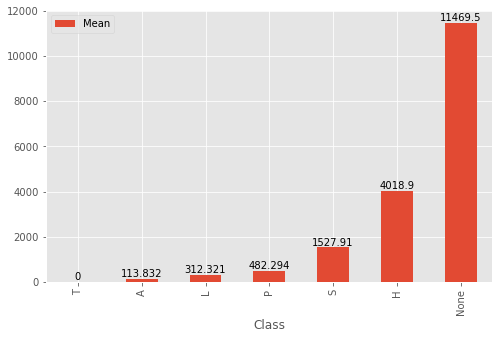

In [62]:
mean_errors_by_class = get_mean_error_by_feature_class_intersection(df_geocoded_hgat, False)
ax = pd.DataFrame(mean_errors_by_class.items(), columns=['Class', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Class", y="Mean", figsize=(8,5))
ax.bar_label(ax.containers[0])
print(mean_errors_by_class)

#### CLAVIN

In [63]:
df_geocoded_clavin["toponyms_in"] = toponyms_in
df_metrics_geocoded = pd.DataFrame(df_geocoded_clavin.apply(lambda row: metrics(row.geocoded, row.toponyms_in, False, 161), axis=1).tolist(), index=df_geocoded_clavin.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe().apply(lambda s: s.apply('{0:.6f}'.format))

Geotag Precision Geotag Recall Geotag F1-Score Geocode Mean Distance  \
count       164.000000    164.000000      164.000000            164.000000   
mean          0.974467      1.000000        0.983639            758.187965   
std           0.099846      0.000000        0.068695           1593.402278   
min           0.333333      1.000000        0.500000              0.000000   
25%           1.000000      1.000000        1.000000              0.000000   
50%           1.000000      1.000000        1.000000              0.000000   
75%           1.000000      1.000000        1.000000            600.251337   
max           1.000000      1.000000        1.000000           7914.618825   

       Geocode Within Min Distance     @161 km         AUC Pct predicted  
count                   164.000000  164.000000  172.000000    164.000000  
mean                      0.812387    0.812387    0.120451      1.000000  
std                       0.319436    0.319436    0.212725      0.000000  
min                       0.000000    0.000000   -0.000000      1.000000  
25%                       0.770833    0.770833    0.000000      1.000000  
50%                       1.000000    1.000000    0.000000      1.000000  
75%                       1.000000    1.000000    0.144583      1.000000  
max                       1.000000    1.000000    0.906229      1.000000

{'L': 961.2778468155409, 'A': 919.5233453794215, 'P': 202.76945420208673, 'S': 1058.3145064282728, 'H': 4224.634589402054, None: 11469.506286630376, 'T': 780.8613354537064}


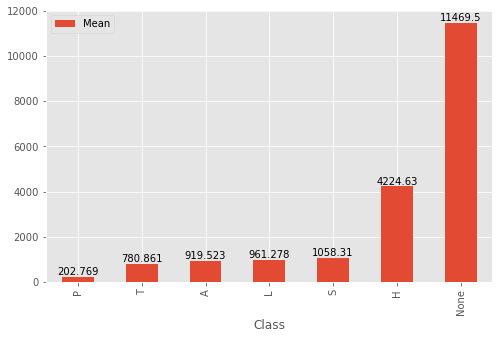

In [64]:
mean_errors_by_class = get_mean_error_by_feature_class_intersection(df_geocoded_clavin, False)
ax = pd.DataFrame(mean_errors_by_class.items(), columns=['Class', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Class", y="Mean", figsize=(8,5))
ax.bar_label(ax.containers[0])
print(mean_errors_by_class)

#### CLAVIN vs HG-AT

<ipython-input-65-3d11dadc9166>:3: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

<ipython-input-65-3d11dadc9166>:7: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



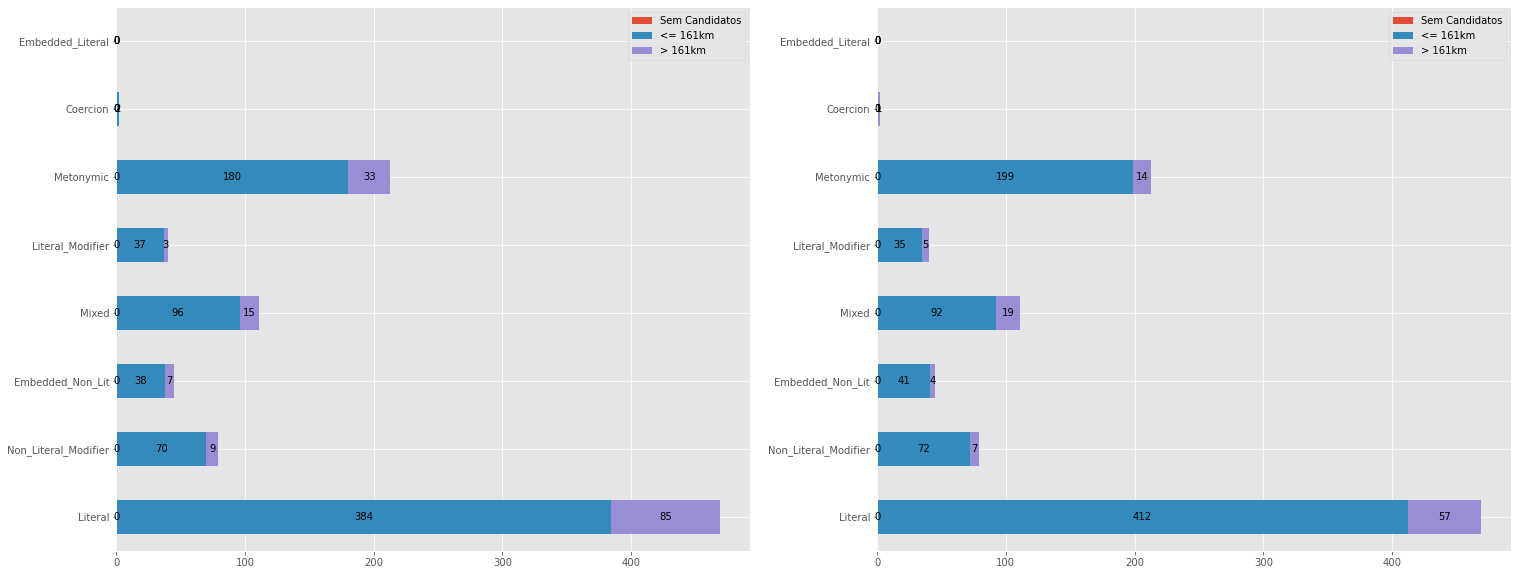

In [65]:
errors_by_type = count_errors_by_type_intersection(df_geocoded_hgat)
df_errors_by_type_hgat_in = pd.DataFrame(
    {key: pd.Series(value) for key, value in errors_by_type.items()})

errors_by_type = count_errors_by_type_intersection(df_geocoded_clavin)
df_errors_by_type_clavin_in = pd.DataFrame(
    {key: pd.Series(value) for key, value in errors_by_type.items()})

plot_bars_stacked_diff(df_errors_by_type_clavin_in, df_errors_by_type_hgat_in)

<AxesSubplot:>

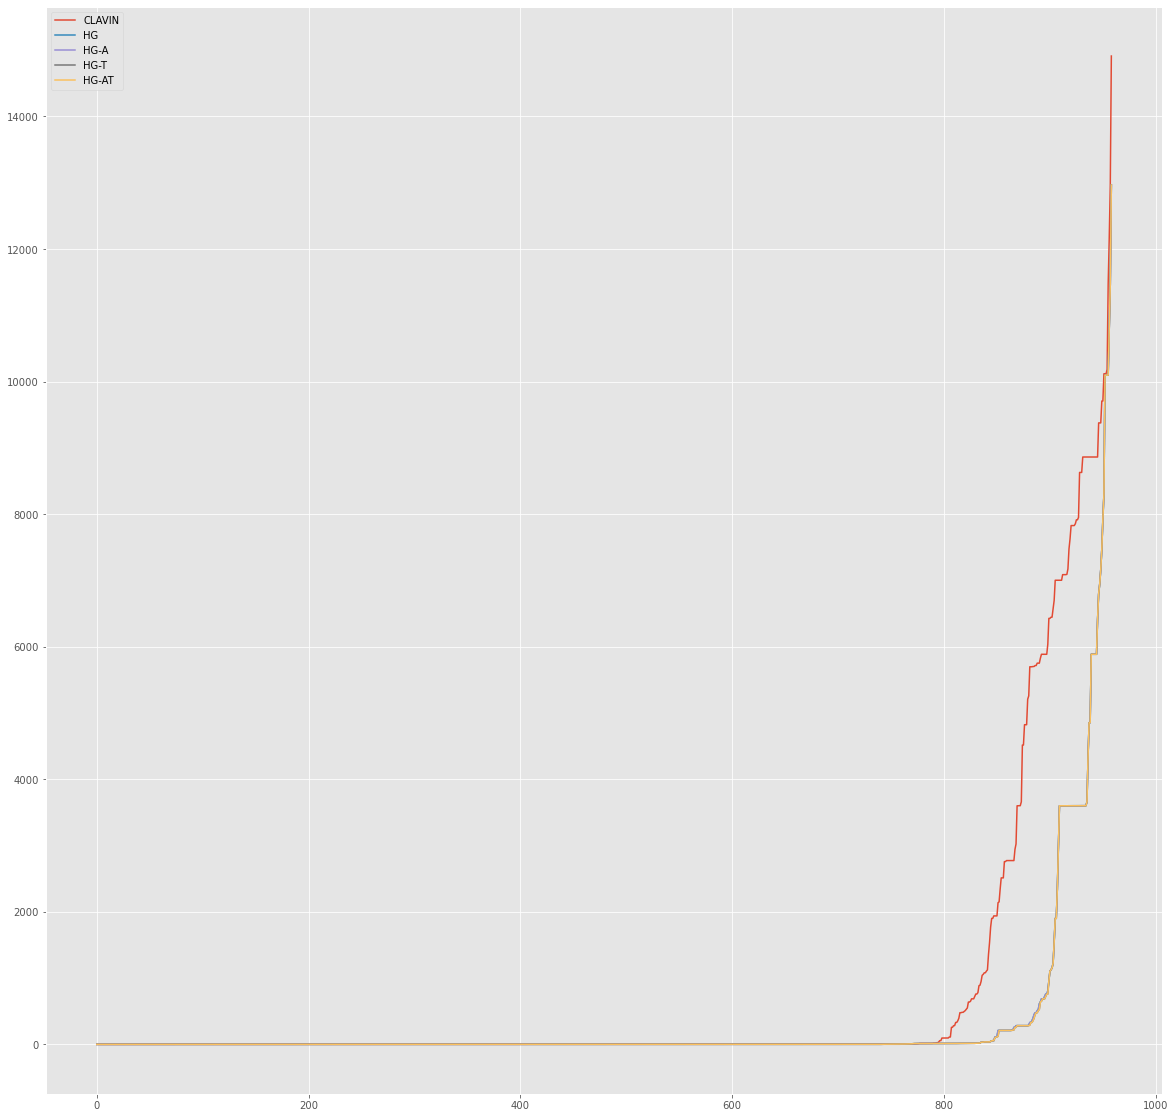

In [66]:
distances_clavin = sorted([i for j in df_geocoded_clavin.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms_in, False), axis=1).tolist() for i in j])
distances_hg = sorted([i for j in df_geocoded_hg.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms_in, False), axis=1).tolist() for i in j])
distances_hga = sorted([i for j in df_geocoded_hga.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms_in, False), axis=1).tolist() for i in j])
distances_hgt = sorted([i for j in df_geocoded_hgt.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms_in, False), axis=1).tolist() for i in j])
distances_hgat = sorted([i for j in df_geocoded_hgat.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms_in, False), axis=1).tolist() for i in j])
distances_dict = { "CLAVIN": distances_clavin, "HG": distances_hg, "HG-A": distances_hga, "HG-T": distances_hgt, "HG-AT": distances_hgat}
df_errors = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in distances_dict.items() ]))
df_errors[["CLAVIN", "HG", "HG-A", "HG-T", "HG-AT"]].plot(figsize=(20,20))

In [67]:
#assert False

## TR-News

In [68]:
#df_trnews = pd.read_csv('../EUPEG-datasets/TR-News.csv')
df_trnews = pd.read_csv('../EUPEG-datasets/TR-News_with_featurecodes.csv')
df_trnews['toponyms'] = df_trnews.apply(
    lambda row: ast.literal_eval(row.toponyms), axis=1)

df_trnews['toponyms'] = df_trnews['toponyms'].apply(
    lambda x: [t for t in x if t[6] is not None])

df_trnews

file                                               link  \
0       0  \n            http://news.nationalpost.com/new...   
1       1  http://www.cnn.com/2015/01/02/us/wv-officers-s...   
2       2  http://www.cnn.com/2015/01/01/us/transgender-q...   
3       3  http://www.cnn.com/2015/01/01/us/mario-cuomo-d...   
4       4  http://www.cnn.com/2013/06/14/us/thanksgiving-...   
..    ...                                                ...   
113   113  http://www.bbc.com/news/world-middle-east-1922...   
114   114  http://www.reuters.com/article/us-iran-blast-s...   
115   115     http://www.nlhnews.co.uk/article.cfm?id=119605   
116   116     http://www.nlhnews.co.uk/article.cfm?id=119700   
117   117     http://www.nlhnews.co.uk/article.cfm?id=119657   

                                                 title  \
0    Policeman shot dead after assassinating Russia...   
1    Slain N.C. couple mourned; bodies found in tru...   
2    The transgender life: What to know, say and un...   
3    Former New York Gov. Mario Cuomo dies at 82; w...   
4                          Thanksgiving Day Fast Facts   
..                                                 ...   
113  Iran earthquakes leave scores dead in Tabriz r...   
114  Starbucks to own 100% of its China stores afte...   
115  Aspiring student from Enfield selected for Chi...   
116  Edmonton man jailed after “vicious assault” wh...   
117  Entrepreneurs of the future pitch healthy prod...   

                                                  text  \
0    A Turkish policeman fatally shot Russia’s amba...   
1    That's how Judy Law of Oxford, North Carolina,...   
2    Ohio sparked an intensely emotional reaction a...   
3    Former New York Gov. Mario Cuomo -- who rose f...   
4    Here's a look at Thanksgiving Day, celebrated ...   
..                                                 ...   
113  Two strong earthquakes have struck north-weste...   
114  LONDON (Reuters) - An explosion in a supermark...   
115  An aspiring 23-year-old graduate from Edmonton...   
116  AN Edmonton man who carried out a “vicious ass...   
117  PRIMARY school youngsters put their culinary s...   

                                              toponyms  
0    [(2, 9, Turkish, Turkey, LOC, None, 298795, 39...  
1    [(31, 45, North Carolina, North Carolina, LOC,...  
2    [(0, 4, Ohio, Ohio, LOC, None, 5165418, 40.250...  
3    [(80, 86, Queens, Queens, LOC, None, 5133273, ...  
4    [(53, 66, United States, United States, LOC, N...  
..                                                 ...  
113  [(155, 161, Tabriz, Tabriz, LOC, None, 113646,...  
114  [(0, 6, LONDON, London, LOC, None, 2643743, 51...  
115  [(38, 46, Edmonton, Edmonton, LOC, None, 26502...  
116  [(3, 11, Edmonton, Edmonton, LOC, None, 265020...  
117  [(103, 111, Edmonton, Edmonton, LOC, None, 265...  

[118 rows x 5 columns]

### CLAVIN

In [69]:
df_geocoded_clavin = df_trnews[['file', 'text', 'toponyms']].copy()
df_geocoded_clavin['geocoded'] = df_geocoded_clavin.progress_apply(
    lambda row: filter_clavin_results(clavin_geoparser.geoparse(row.text), row.toponyms), axis=1)

unified_geocoded =  df_geocoded_clavin['geocoded'].apply(lambda x: [t for t in x if t[4] is not None]).tolist()
unified_geocoded = [i for j in unified_geocoded for i in j]
print(len(unified_geocoded))

df_metrics_geocoded = pd.DataFrame(df_geocoded_clavin.apply(lambda row: metrics(row.geocoded, row.toponyms, False, 161), axis=1).tolist(), index=df_geocoded_clavin.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe().apply(lambda s: s.apply('{0:.6f}'.format))

Progress:   0%|          | 0/118 [00:00<?, ?it/s]

666


Geotag Precision Geotag Recall Geotag F1-Score Geocode Mean Distance  \
count       113.000000    118.000000      113.000000            113.000000   
mean          1.000000      0.534179        0.689677           1570.097288   
std           0.000000      0.245571        0.188722           2685.965745   
min           1.000000      0.000000        0.285714              0.000000   
25%           1.000000      0.363636        0.545455              0.000000   
50%           1.000000      0.500000        0.705882              4.072103   
75%           1.000000      0.726010        0.842105           2470.520365   
max           1.000000      1.000000        1.000000          12229.668540   

       Geocode Within Min Distance     @161 km         AUC Pct predicted  
count                   113.000000  113.000000  107.000000    118.000000  
mean                      0.768716    0.768716    0.188900      0.534179  
std                       0.327460    0.327460    0.258055      0.245571  
min                       0.000000    0.000000    0.000000      0.000000  
25%                       0.666667    0.666667    0.000000      0.363636  
50%                       1.000000    1.000000    0.089330      0.500000  
75%                       1.000000    1.000000    0.268792      0.726010  
max                       1.000000    1.000000    0.950155      1.000000

In [70]:
errors_by_type = count_errors_by_type(df_geocoded_clavin, classes=["LOC"])
df_errors_by_type_clavin = pd.DataFrame(
    {key: pd.Series(value) for key, value in errors_by_type.items()})

#### Erro por Feature Code

{'PCLI': 1913.7760021291454, 'PPLC': 30.416337480719715, 'PPLA': 238.11656190902386, 'ADM1': 365.72817892314595, 'PPLA2': 2541.4750312065667, 'PPL': 3138.213380328605, 'AIRP': 0.0, 'RGN': 1658.90246986906, 'ADM3': 11.362449367980442, 'PPLX': 4069.4400071155624, 'CONT': 807.6898268192876, 'ADMD': 0.0, 'STDM': 326.30685049545326, 'MUS': 3.716243567321293, 'AREA': 64.01643099883837, 'PRK': 6293.8884777714675, 'ADM2': 397.48948118064726, 'MTRO': 0.0, 'STM': 178.66269474833848, 'PCLD': 0.0, 'PCLS': 0.0}


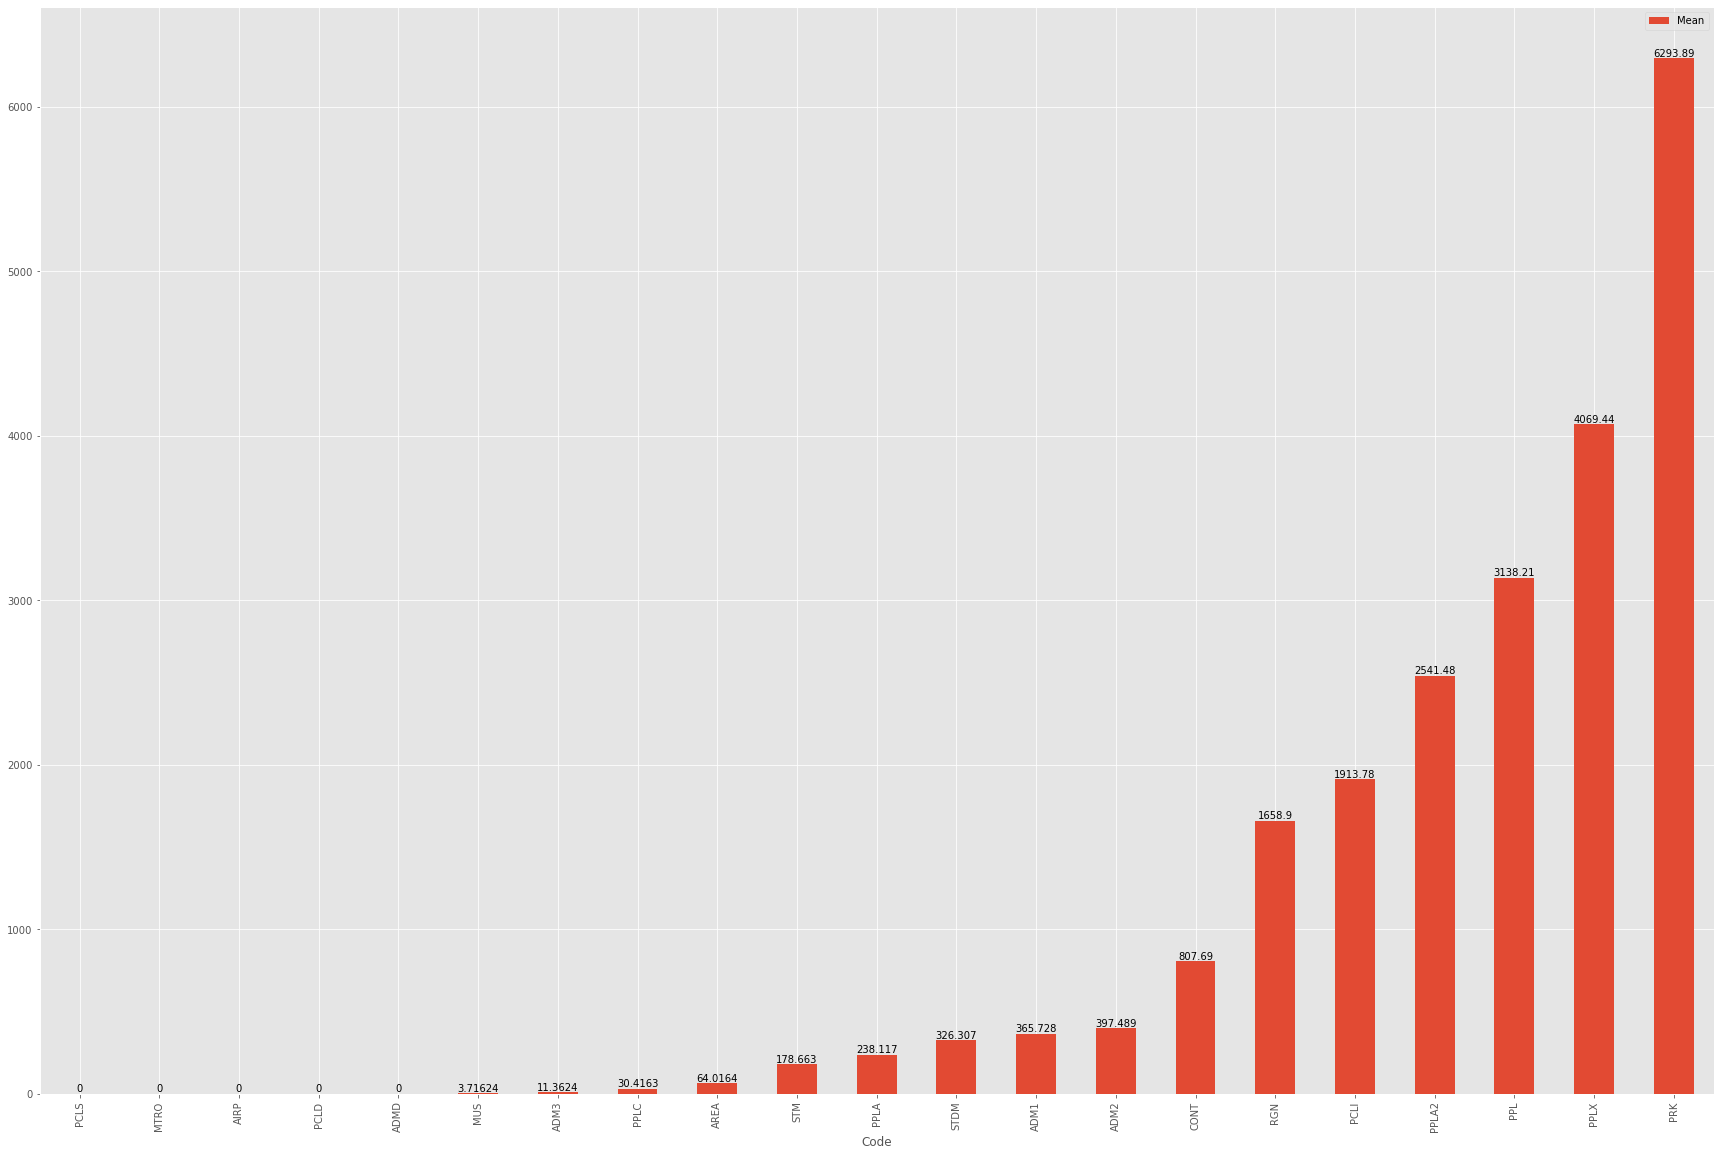

In [71]:
mean_errors_by_code = get_mean_error_by_feature_code(df_geocoded_clavin, False)
ax = pd.DataFrame(mean_errors_by_code.items(), columns=['Code', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Code", y="Mean", figsize=(30,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_code)

#### Erro por Feature Class

{'A': 1139.1275146534958, 'P': 1823.4182087902693, 'S': 47.14615629468208, 'L': 1442.138799365466, 'H': 178.66269474833848}


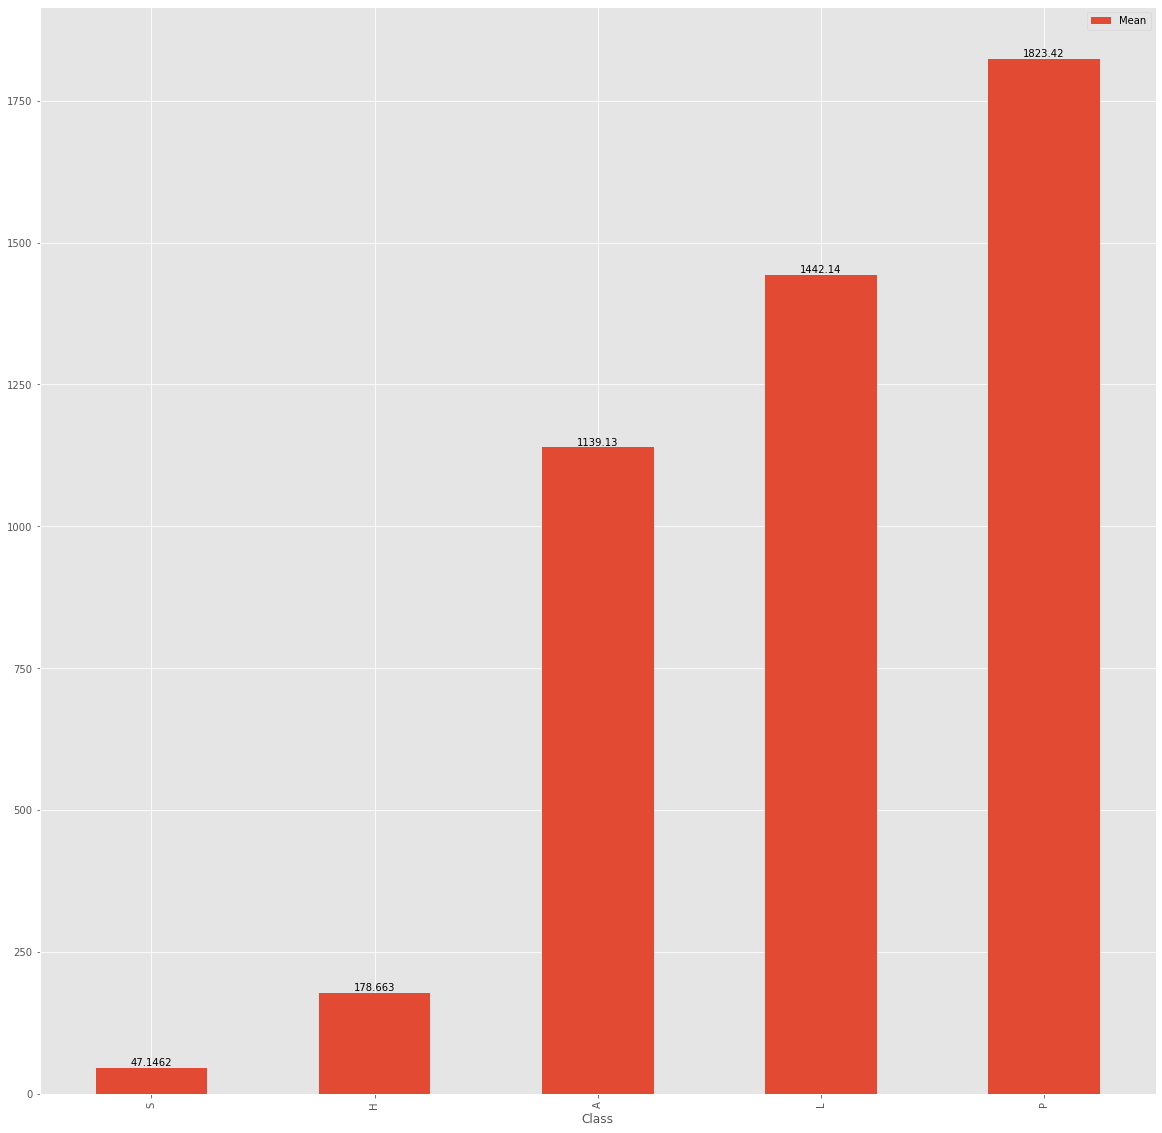

In [72]:
mean_errors_by_class = get_mean_error_by_feature_class(df_geocoded_clavin, False)
ax = pd.DataFrame(mean_errors_by_class.items(), columns=['Class', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Class", y="Mean", figsize=(20,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_class)

### HG

In [73]:
df_geocoded_hg = df_trnews[['file', 'text', 'toponyms']].copy()
df_geocoded_hg['geocoded'] = df_geocoded_clavin.progress_apply(lambda row: geocode_clavin_results(row.geocoded, geoparser, row.toponyms, exact_matching=True, process_demonyms=False, bounding_box=None, k=1, minimum_score=0, sort_by="population", minimization_classes=[], minimization_strategy="sum_dist"), axis=1)

unified_geocoded =  df_geocoded_hg['geocoded'].apply(lambda x: [t for t in x if t[4] is not None]).tolist()
unified_geocoded = [i for j in unified_geocoded for i in j]
print(len(unified_geocoded))

df_metrics_geocoded = pd.DataFrame(df_geocoded_hg.apply(lambda row: metrics(row.geocoded, row.toponyms, False, 161), axis=1).tolist(), index=df_geocoded_hg.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe().apply(lambda s: s.apply('{0:.6f}'.format))

Progress:   0%|          | 0/118 [00:00<?, ?it/s]

649


Geotag Precision Geotag Recall Geotag F1-Score Geocode Mean Distance  \
count       113.000000    118.000000      113.000000            113.000000   
mean          1.000000      0.534179        0.689677           1424.230601   
std           0.000000      0.245571        0.188722           2644.265101   
min           1.000000      0.000000        0.285714              0.000000   
25%           1.000000      0.363636        0.545455              0.000000   
50%           1.000000      0.500000        0.705882             12.735147   
75%           1.000000      0.726010        0.842105           1440.187678   
max           1.000000      1.000000        1.000000          12227.893881   

       Geocode Within Min Distance     @161 km         AUC Pct predicted  
count                   113.000000  113.000000  105.000000    118.000000  
mean                      0.776993    0.776993    0.186386      0.518500  
std                       0.334597    0.334597    0.259160      0.245131  
min                       0.000000    0.000000    0.000000      0.000000  
25%                       0.625000    0.625000    0.000000      0.363636  
50%                       1.000000    1.000000    0.078658      0.500000  
75%                       1.000000    1.000000    0.232887      0.710714  
max                       1.000000    1.000000    0.950141      1.000000

#### Erro por Feature Code

{'PCLI': 39.96177726300765, 'PPLC': 188.85537542507436, 'PPLA': 60.045366233022776, 'ADM1': 60.75071811992031, 'PPLA2': 2328.7909489206586, 'PPL': 3563.022720657134, 'AIRP': 6943.227360274631, 'ADM3': 191.51642855644238, 'PPLX': 6965.393247688258, 'CONT': 4.896859072080526e-13, 'ADMD': 0.0, 'STDM': 326.30685049545326, 'RGN': 1964.9106814949948, 'MUS': 3.716243567321293, 'AREA': 64.01643099883891, 'PRK': 8221.805409342682, 'ADM2': 720.1213004002624, 'MTRO': 0.0, 'STM': 167.99970700709977, 'PCLD': 0.0, 'PCLS': 0.0}


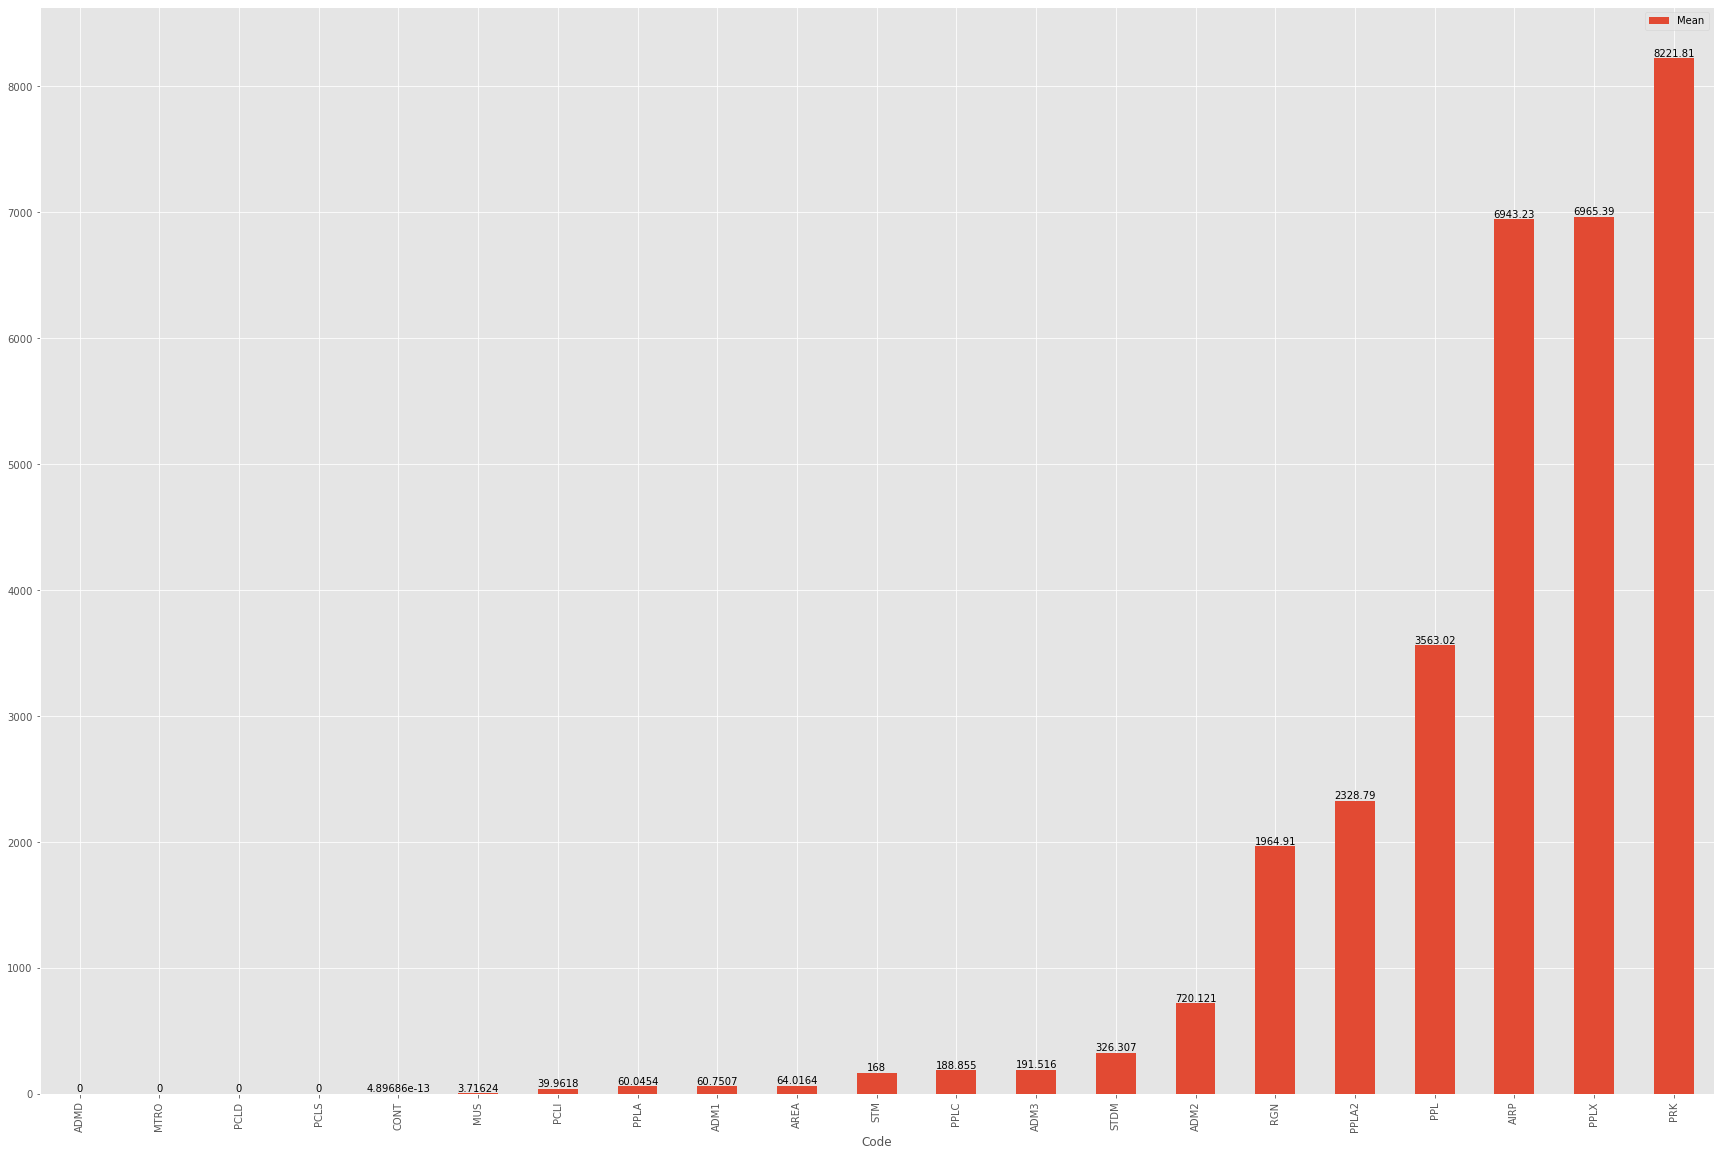

In [74]:
mean_errors_by_code = get_mean_error_by_feature_code(df_geocoded_hg, False)
ax = pd.DataFrame(mean_errors_by_code.items(), columns=['Code', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Code", y="Mean", figsize=(30,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_code)

#### Erro por Feature Class

{'A': 92.5260967465905, 'P': 2077.4384280738414, 'S': 3526.617529147777, 'L': 1199.827140370819, 'H': 167.99970700709977}


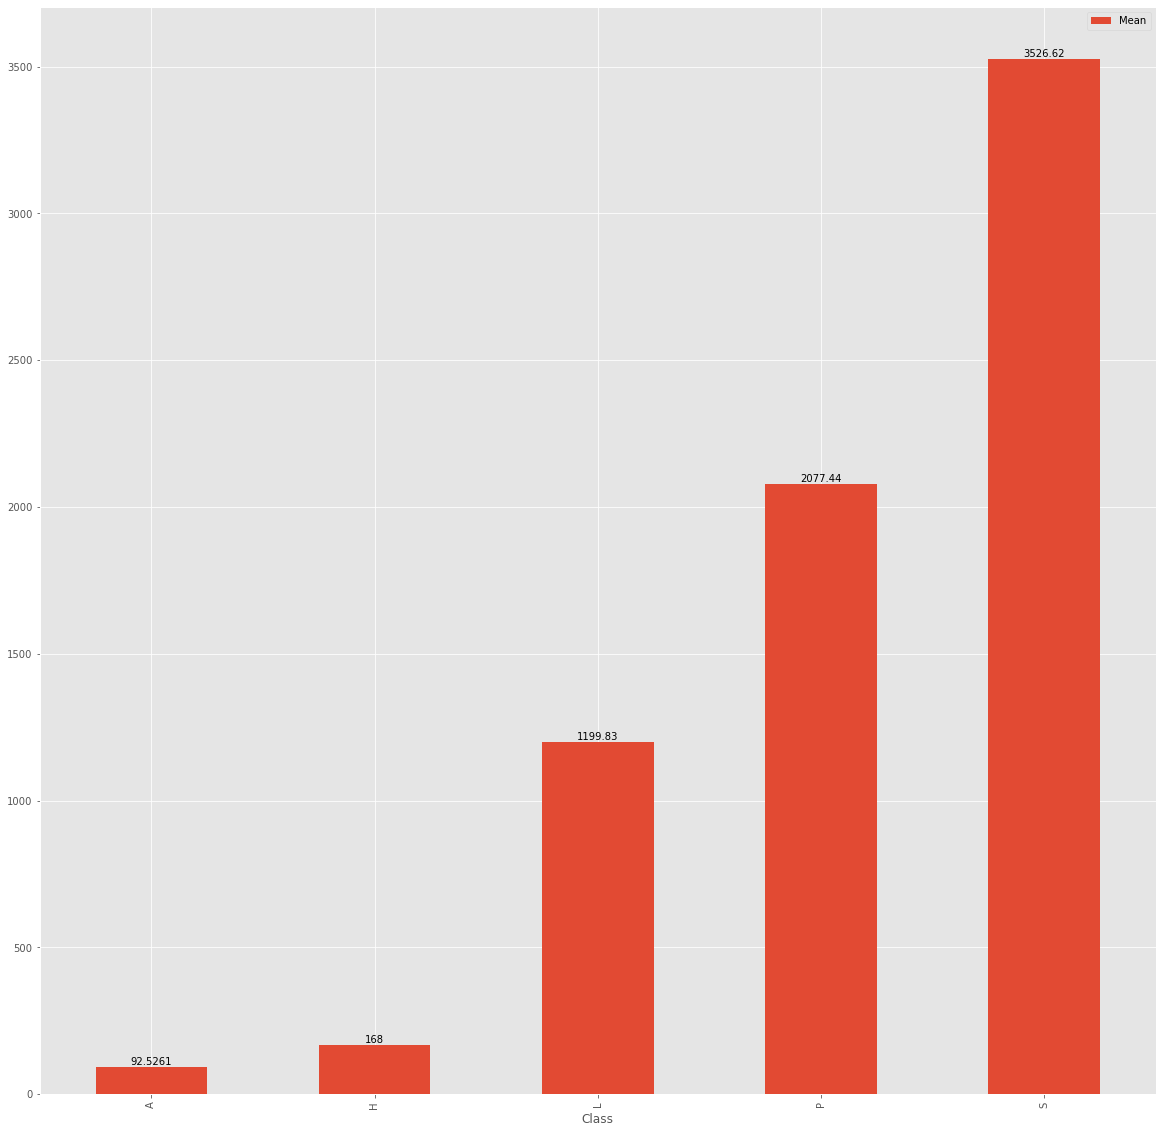

In [75]:
mean_errors_by_class = get_mean_error_by_feature_class(df_geocoded_hg, False)
ax = pd.DataFrame(mean_errors_by_class.items(), columns=['Class', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Class", y="Mean", figsize=(20,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_class)

#### CLAVIN vs HG

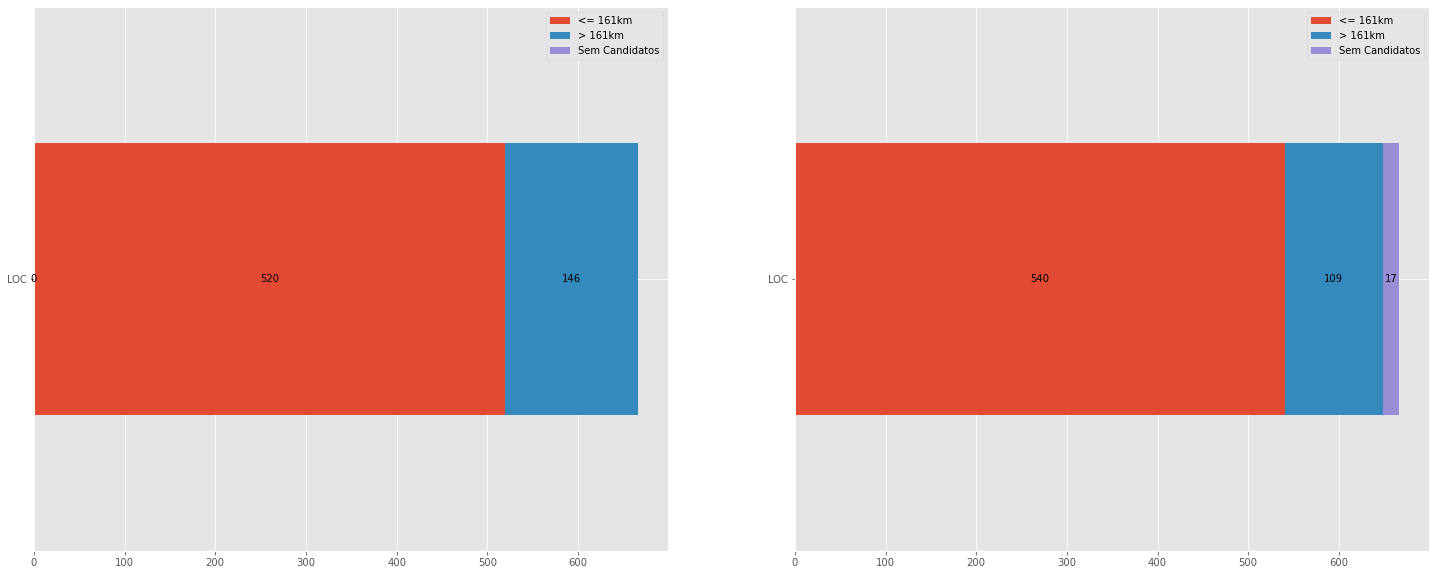

In [76]:
errors_by_type = count_errors_by_type(df_geocoded_hg, classes=["LOC"])
df_errors_by_type_hg = pd.DataFrame(
    {key: pd.Series(value) for key, value in errors_by_type.items()})

plot_bars_stacked_diff(df_errors_by_type_clavin, df_errors_by_type_hg)

### HG-A

In [77]:
df_geocoded_hga = df_trnews[['file', 'text', 'toponyms']].copy()
df_geocoded_hga['geocoded'] = df_geocoded_clavin.progress_apply(lambda row: geocode_clavin_results(row.geocoded, geoparser, row.toponyms, exact_matching=True, process_demonyms=True, bounding_box=None, k=1, minimum_score=0, sort_by="population", minimization_classes=[], minimization_strategy="sum_dist"), axis=1)

unified_geocoded =  df_geocoded_hga['geocoded'].apply(lambda x: [t for t in x if t[4] is not None]).tolist()
unified_geocoded = [i for j in unified_geocoded for i in j]
print(len(unified_geocoded))

df_metrics_geocoded = pd.DataFrame(df_geocoded_hga.apply(lambda row: metrics(row.geocoded, row.toponyms, False, 161), axis=1).tolist(), index=df_geocoded_hga.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe().apply(lambda s: s.apply('{0:.6f}'.format))

Progress:   0%|          | 0/118 [00:00<?, ?it/s]

649


Geotag Precision Geotag Recall Geotag F1-Score Geocode Mean Distance  \
count       113.000000    118.000000      113.000000            113.000000   
mean          1.000000      0.534179        0.689677           1424.230601   
std           0.000000      0.245571        0.188722           2644.265101   
min           1.000000      0.000000        0.285714              0.000000   
25%           1.000000      0.363636        0.545455              0.000000   
50%           1.000000      0.500000        0.705882             12.735147   
75%           1.000000      0.726010        0.842105           1440.187678   
max           1.000000      1.000000        1.000000          12227.893881   

       Geocode Within Min Distance     @161 km         AUC Pct predicted  
count                   113.000000  113.000000  105.000000    118.000000  
mean                      0.776993    0.776993    0.186386      0.518500  
std                       0.334597    0.334597    0.259160      0.245131  
min                       0.000000    0.000000    0.000000      0.000000  
25%                       0.625000    0.625000    0.000000      0.363636  
50%                       1.000000    1.000000    0.078658      0.500000  
75%                       1.000000    1.000000    0.232887      0.710714  
max                       1.000000    1.000000    0.950141      1.000000

#### Erro por Feature Code

{'PCLI': 39.96177726300765, 'PPLC': 188.85537542507436, 'PPLA': 60.045366233022776, 'ADM1': 60.75071811992031, 'PPLA2': 2328.7909489206586, 'PPL': 3563.022720657134, 'AIRP': 6943.227360274631, 'ADM3': 191.51642855644238, 'PPLX': 6965.393247688258, 'CONT': 4.896859072080526e-13, 'ADMD': 0.0, 'STDM': 326.30685049545326, 'RGN': 1964.9106814949948, 'MUS': 3.716243567321293, 'AREA': 64.01643099883891, 'PRK': 8221.805409342682, 'ADM2': 720.1213004002624, 'MTRO': 0.0, 'STM': 167.99970700709977, 'PCLD': 0.0, 'PCLS': 0.0}


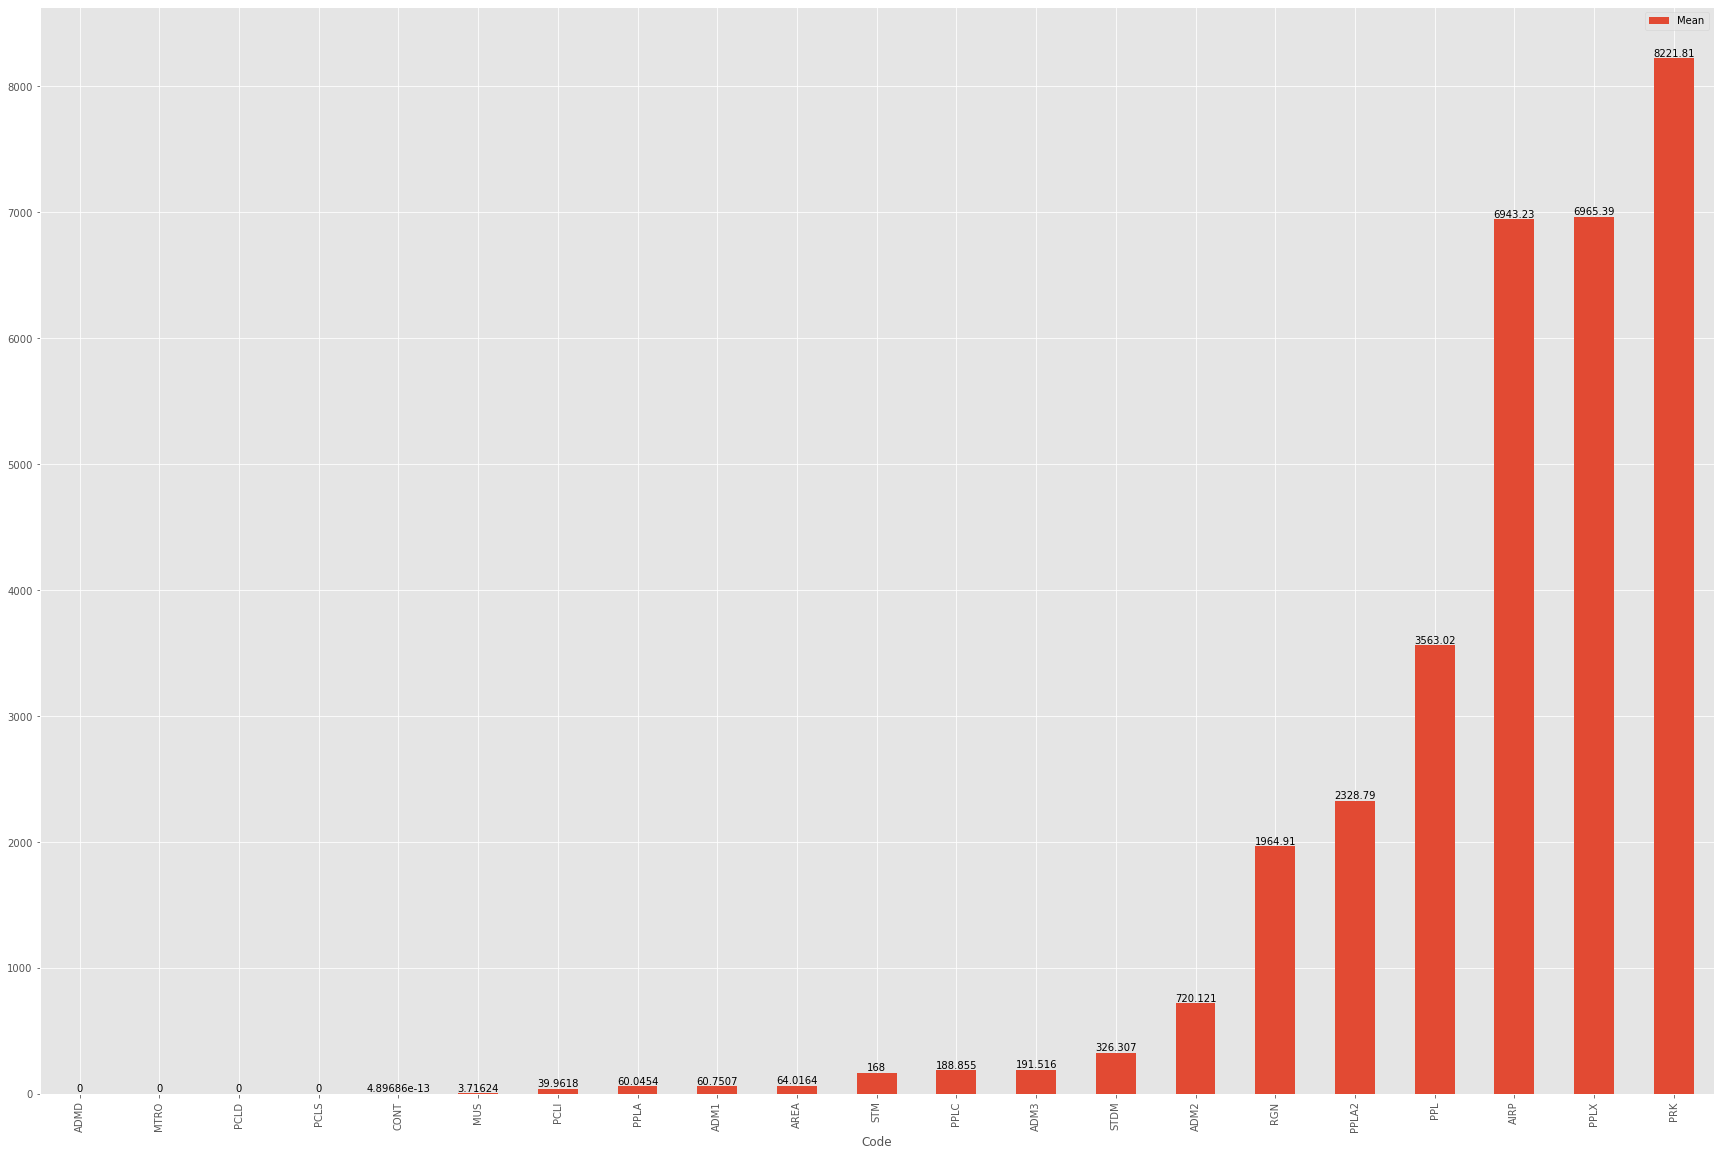

In [78]:
mean_errors_by_code = get_mean_error_by_feature_code(df_geocoded_hga, False)
ax = pd.DataFrame(mean_errors_by_code.items(), columns=['Code', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Code", y="Mean", figsize=(30,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_code)

#### Erro por Feature Class

{'A': 92.5260967465905, 'P': 2077.4384280738414, 'S': 3526.617529147777, 'L': 1199.827140370819, 'H': 167.99970700709977}


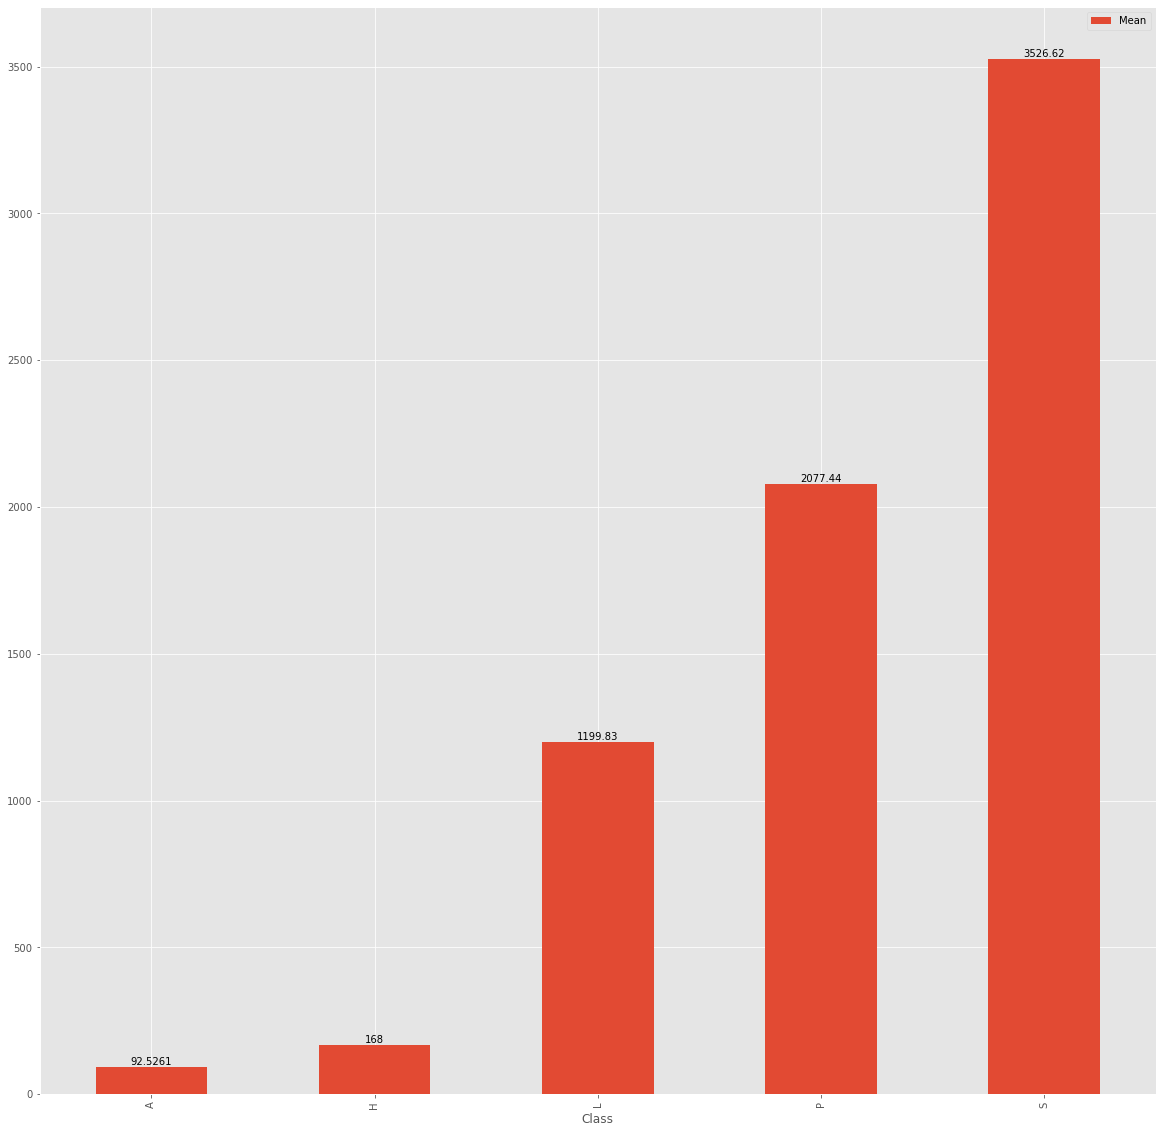

In [79]:
mean_errors_by_class = get_mean_error_by_feature_class(df_geocoded_hga, False)
ax = pd.DataFrame(mean_errors_by_class.items(), columns=['Class', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Class", y="Mean", figsize=(20,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_class)

#### CLAVIN vs HGA

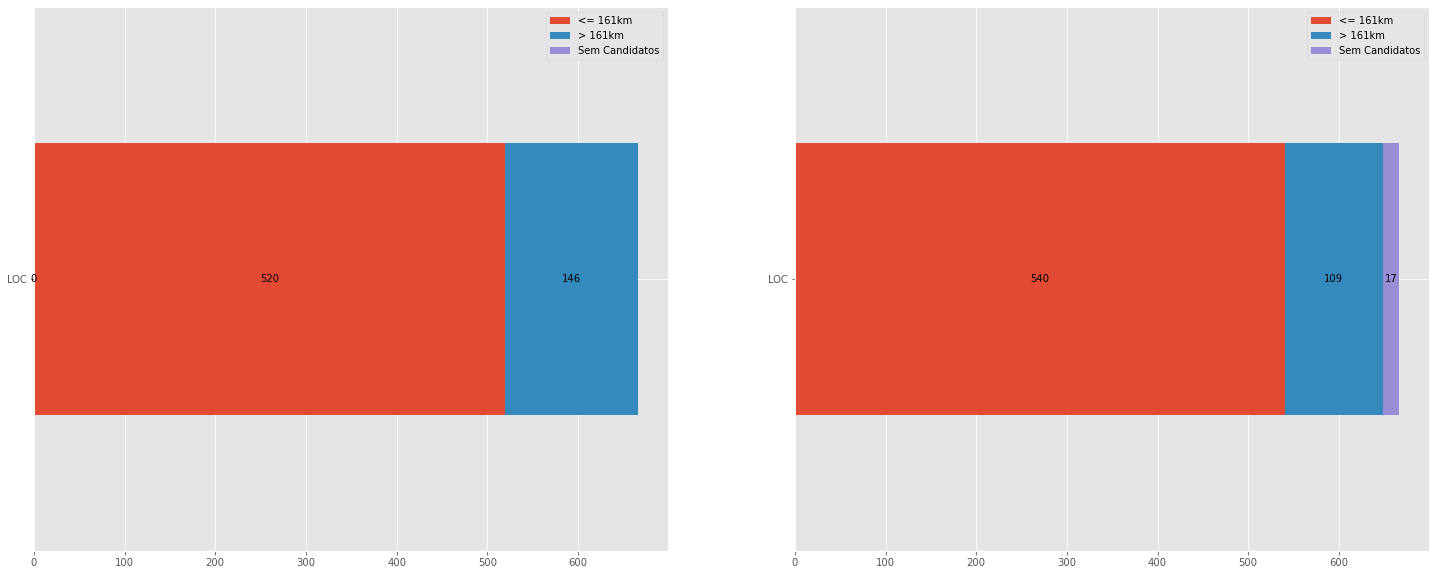

In [80]:
errors_by_type = count_errors_by_type(df_geocoded_hga, classes=["LOC"])
df_errors_by_type_hga = pd.DataFrame(
    {key: pd.Series(value) for key, value in errors_by_type.items()})

plot_bars_stacked_diff(df_errors_by_type_clavin, df_errors_by_type_hga)

### HG-T

In [81]:
df_geocoded_hgt = df_trnews[['file', 'text', 'toponyms']].copy()
df_geocoded_hgt['geocoded'] = df_geocoded_clavin.progress_apply(lambda row: geocode_clavin_results(row.geocoded, geoparser, row.toponyms, exact_matching=True, process_demonyms=False, bounding_box=None, k=5, minimum_score=0, sort_by="population", minimization_classes=["LOC"], minimization_strategy="pop_by_mean_dist"), axis=1)

unified_geocoded =  df_geocoded_hgt['geocoded'].apply(lambda x: [t for t in x if t[4] is not None]).tolist()
unified_geocoded = [i for j in unified_geocoded for i in j]
print(len(unified_geocoded))

df_metrics_geocoded = pd.DataFrame(df_geocoded_hgt.apply(lambda row: metrics(row.geocoded, row.toponyms, False, 161), axis=1).tolist(), index=df_geocoded_hgt.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe().apply(lambda s: s.apply('{0:.6f}'.format))

Progress:   0%|          | 0/118 [00:00<?, ?it/s]

649


Geotag Precision Geotag Recall Geotag F1-Score Geocode Mean Distance  \
count       113.000000    118.000000      113.000000            113.000000   
mean          1.000000      0.534179        0.689677           1409.543667   
std           0.000000      0.245571        0.188722           2630.627251   
min           1.000000      0.000000        0.285714              0.000000   
25%           1.000000      0.363636        0.545455              0.000000   
50%           1.000000      0.500000        0.705882             12.735147   
75%           1.000000      0.726010        0.842105           1440.187678   
max           1.000000      1.000000        1.000000          12227.893881   

       Geocode Within Min Distance     @161 km         AUC Pct predicted  
count                   113.000000  113.000000  105.000000    118.000000  
mean                      0.779558    0.779558    0.184541      0.518500  
std                       0.333606    0.333606    0.258646      0.245131  
min                       0.000000    0.000000    0.000000      0.000000  
25%                       0.666667    0.666667    0.000000      0.363636  
50%                       1.000000    1.000000    0.075740      0.500000  
75%                       1.000000    1.000000    0.237535      0.710714  
max                       1.000000    1.000000    0.950141      1.000000

#### Erro por Feature Code

{'PCLI': 39.96177726300765, 'PPLC': 188.85537542507436, 'PPLA': 61.16521462716582, 'ADM1': 12.736849292926582, 'PPLA2': 2327.153108838499, 'PPL': 3543.1987464429317, 'AIRP': 6943.227360274631, 'ADM3': 191.51642855644238, 'PPLX': 6965.393247688258, 'CONT': 4.896859072080526e-13, 'ADMD': 0.0, 'STDM': 326.30685049545326, 'RGN': 1964.9106814949948, 'MUS': 3.716243567321293, 'AREA': 64.01643099883891, 'PRK': 8221.805409342682, 'ADM2': 720.1213004002624, 'MTRO': 0.0, 'STM': 167.99970700709977, 'PCLD': 0.0, 'PCLS': 0.0}


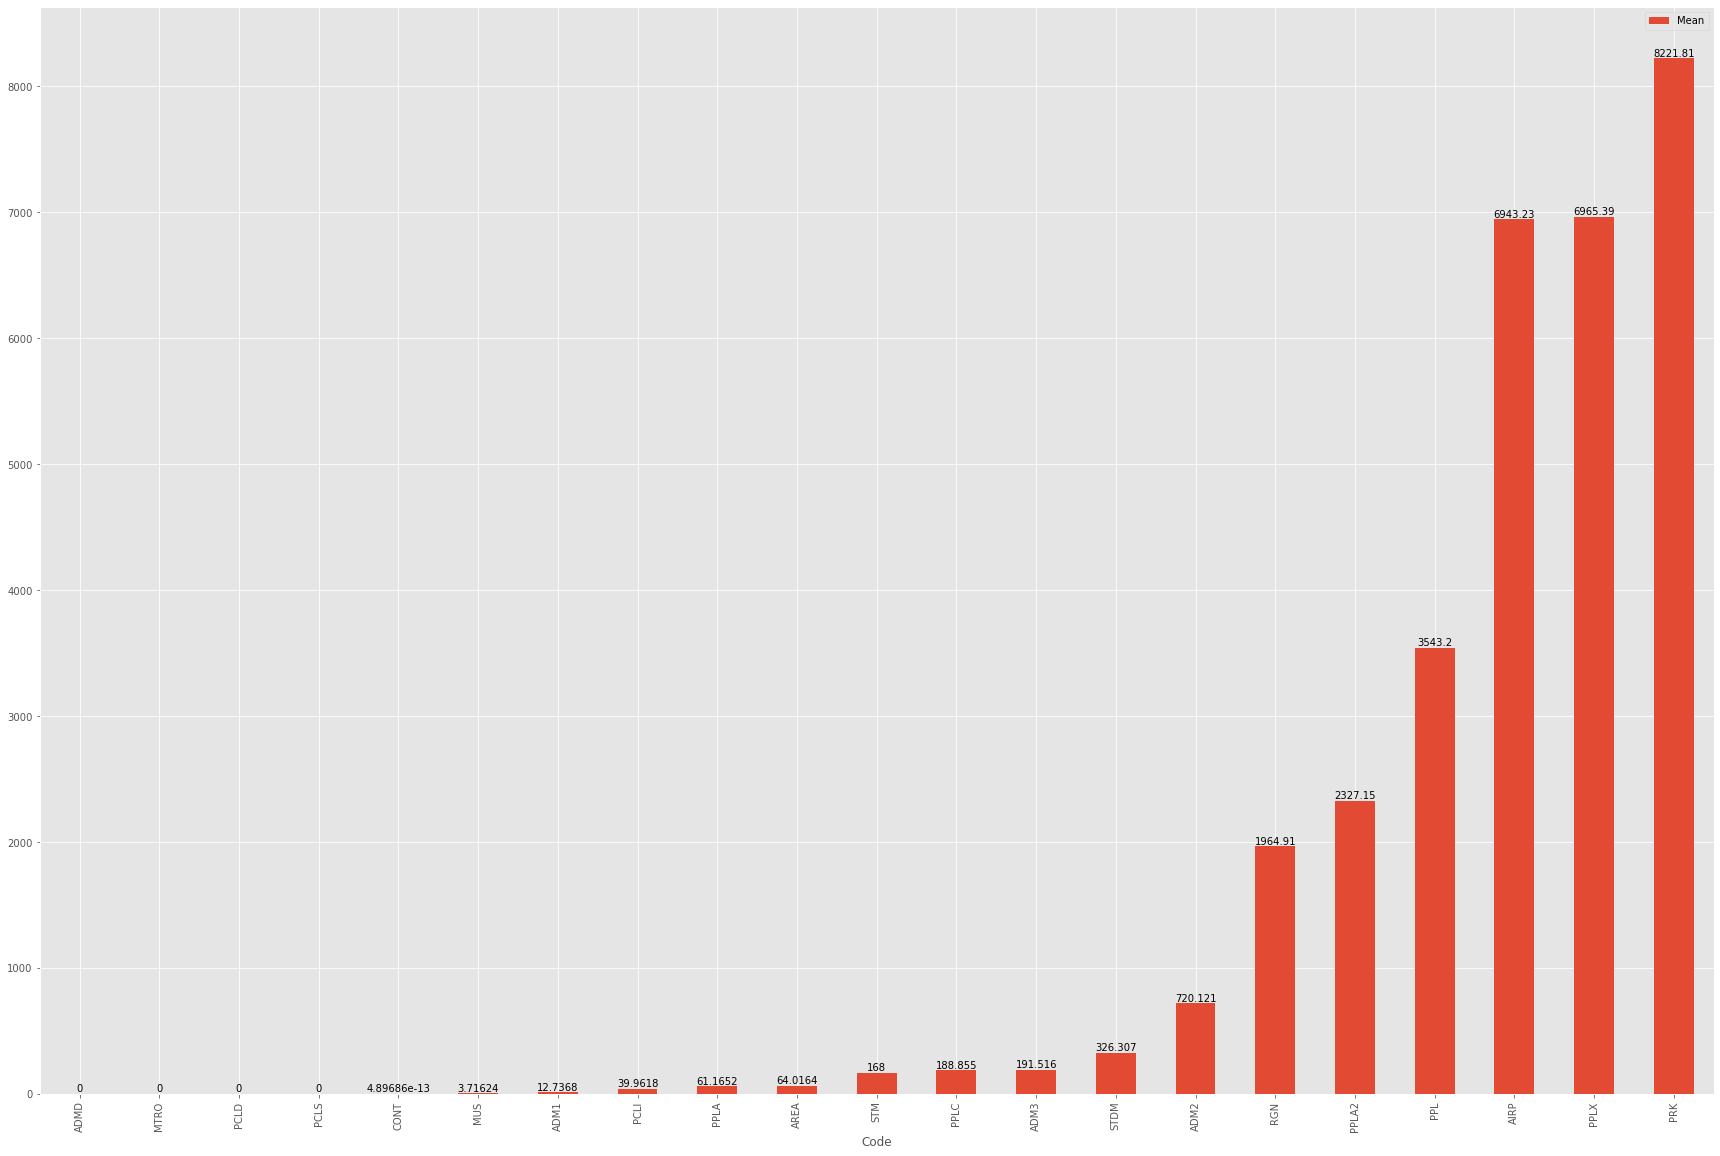

In [82]:
mean_errors_by_code = get_mean_error_by_feature_code(df_geocoded_hgt, False)
ax = pd.DataFrame(mean_errors_by_code.items(), columns=['Code', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Code", y="Mean", figsize=(30,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_code)

#### Erro por Feature Class

{'A': 73.18900436969165, 'P': 2071.5951733304473, 'S': 3526.617529147777, 'L': 1199.827140370819, 'H': 167.99970700709977}


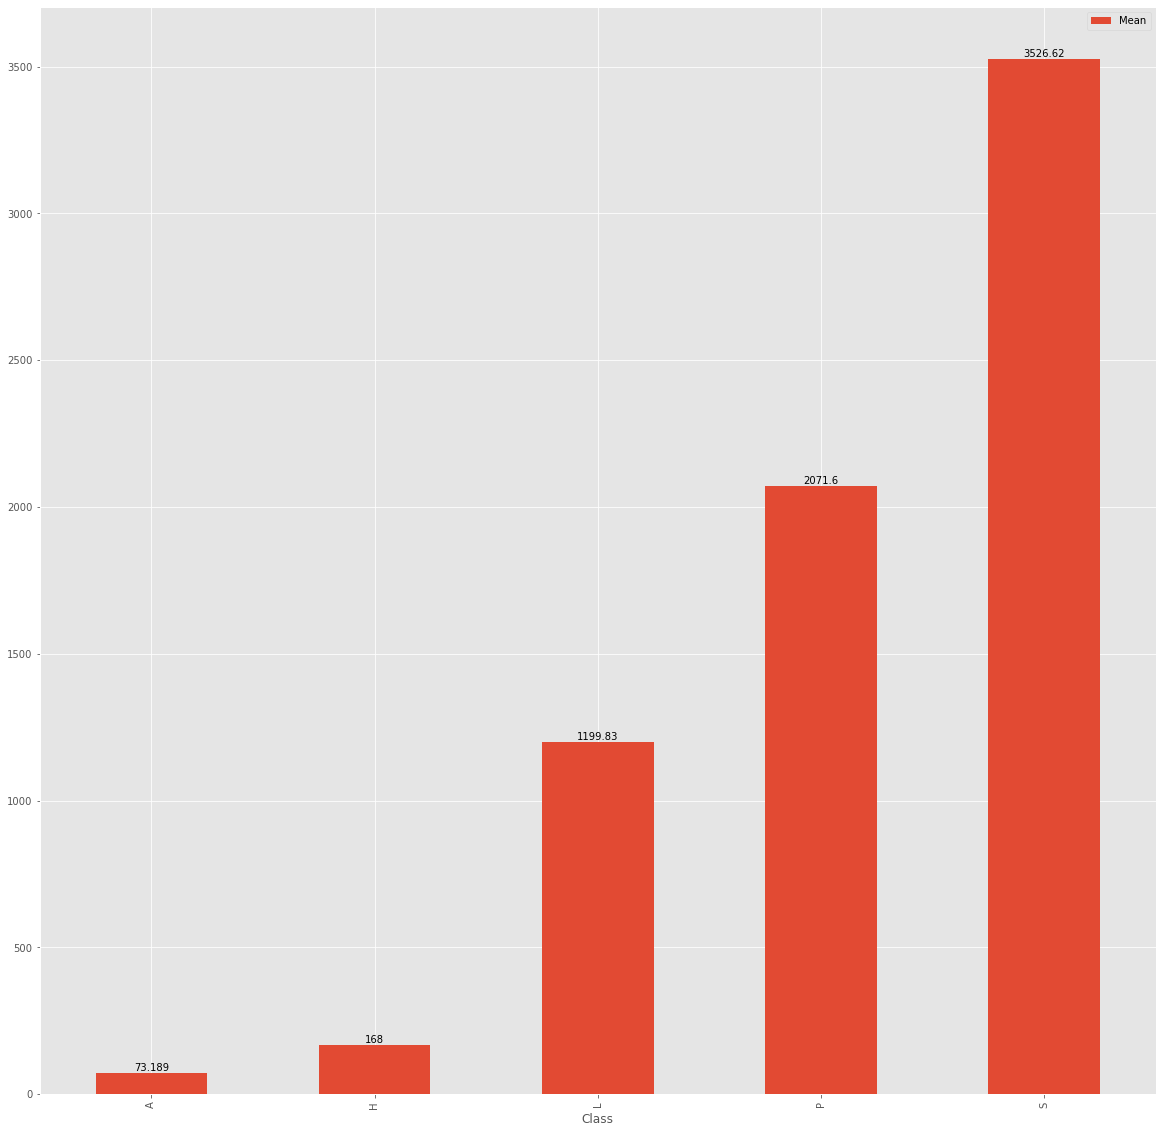

In [83]:
mean_errors_by_class = get_mean_error_by_feature_class(df_geocoded_hgt, False)
ax = pd.DataFrame(mean_errors_by_class.items(), columns=['Class', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Class", y="Mean", figsize=(20,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_class)

#### CLAVIN vs HGT

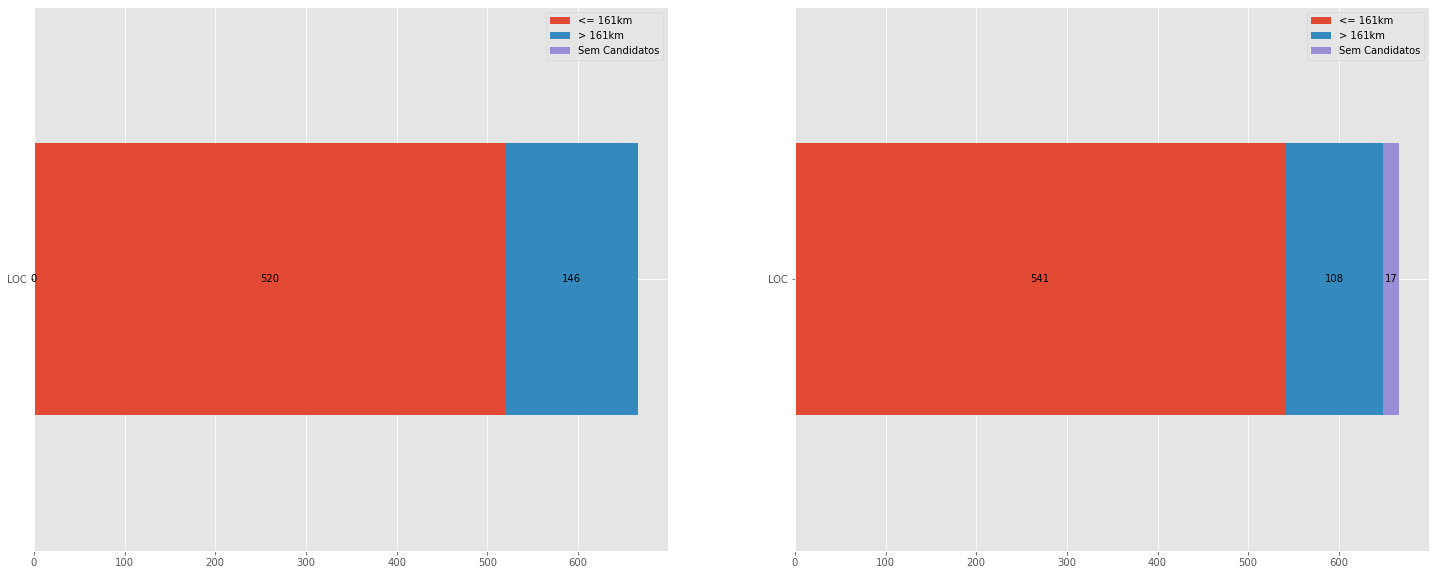

In [84]:
errors_by_type = count_errors_by_type(df_geocoded_hgt, classes=["LOC"])
df_errors_by_type_hgt = pd.DataFrame(
    {key: pd.Series(value) for key, value in errors_by_type.items()})

plot_bars_stacked_diff(df_errors_by_type_clavin, df_errors_by_type_hgt)

### HG-AT

In [85]:
df_geocoded_hgat = df_trnews[['file', 'text', 'toponyms']].copy()
df_geocoded_hgat['geocoded'] = df_geocoded_clavin.progress_apply(lambda row: geocode_clavin_results(row.geocoded, geoparser, row.toponyms, exact_matching=True, process_demonyms=True, bounding_box=None, k=5, minimum_score=0, sort_by="population", minimization_classes=["LOC"], minimization_strategy="pop_by_mean_dist"), axis=1)

unified_geocoded =  df_geocoded_hgat['geocoded'].apply(lambda x: [t for t in x if t[4] is not None]).tolist()
unified_geocoded = [i for j in unified_geocoded for i in j]
print(len(unified_geocoded))

df_metrics_geocoded = pd.DataFrame(df_geocoded_hgat.apply(lambda row: metrics(row.geocoded, row.toponyms, False, 161), axis=1).tolist(), index=df_geocoded_hgat.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe().apply(lambda s: s.apply('{0:.6f}'.format))

Progress:   0%|          | 0/118 [00:00<?, ?it/s]

649


Geotag Precision Geotag Recall Geotag F1-Score Geocode Mean Distance  \
count       113.000000    118.000000      113.000000            113.000000   
mean          1.000000      0.534179        0.689677           1409.543667   
std           0.000000      0.245571        0.188722           2630.627251   
min           1.000000      0.000000        0.285714              0.000000   
25%           1.000000      0.363636        0.545455              0.000000   
50%           1.000000      0.500000        0.705882             12.735147   
75%           1.000000      0.726010        0.842105           1440.187678   
max           1.000000      1.000000        1.000000          12227.893881   

       Geocode Within Min Distance     @161 km         AUC Pct predicted  
count                   113.000000  113.000000  105.000000    118.000000  
mean                      0.779558    0.779558    0.184541      0.518500  
std                       0.333606    0.333606    0.258646      0.245131  
min                       0.000000    0.000000    0.000000      0.000000  
25%                       0.666667    0.666667    0.000000      0.363636  
50%                       1.000000    1.000000    0.075740      0.500000  
75%                       1.000000    1.000000    0.237535      0.710714  
max                       1.000000    1.000000    0.950141      1.000000

#### Erro por Feature Code

{'PCLI': 39.96177726300765, 'PPLC': 188.85537542507436, 'PPLA': 61.16521462716582, 'ADM1': 12.736849292926582, 'PPLA2': 2327.153108838499, 'PPL': 3543.1987464429317, 'AIRP': 6943.227360274631, 'ADM3': 191.51642855644238, 'PPLX': 6965.393247688258, 'CONT': 4.896859072080526e-13, 'ADMD': 0.0, 'STDM': 326.30685049545326, 'RGN': 1964.9106814949948, 'MUS': 3.716243567321293, 'AREA': 64.01643099883891, 'PRK': 8221.805409342682, 'ADM2': 720.1213004002624, 'MTRO': 0.0, 'STM': 167.99970700709977, 'PCLD': 0.0, 'PCLS': 0.0}


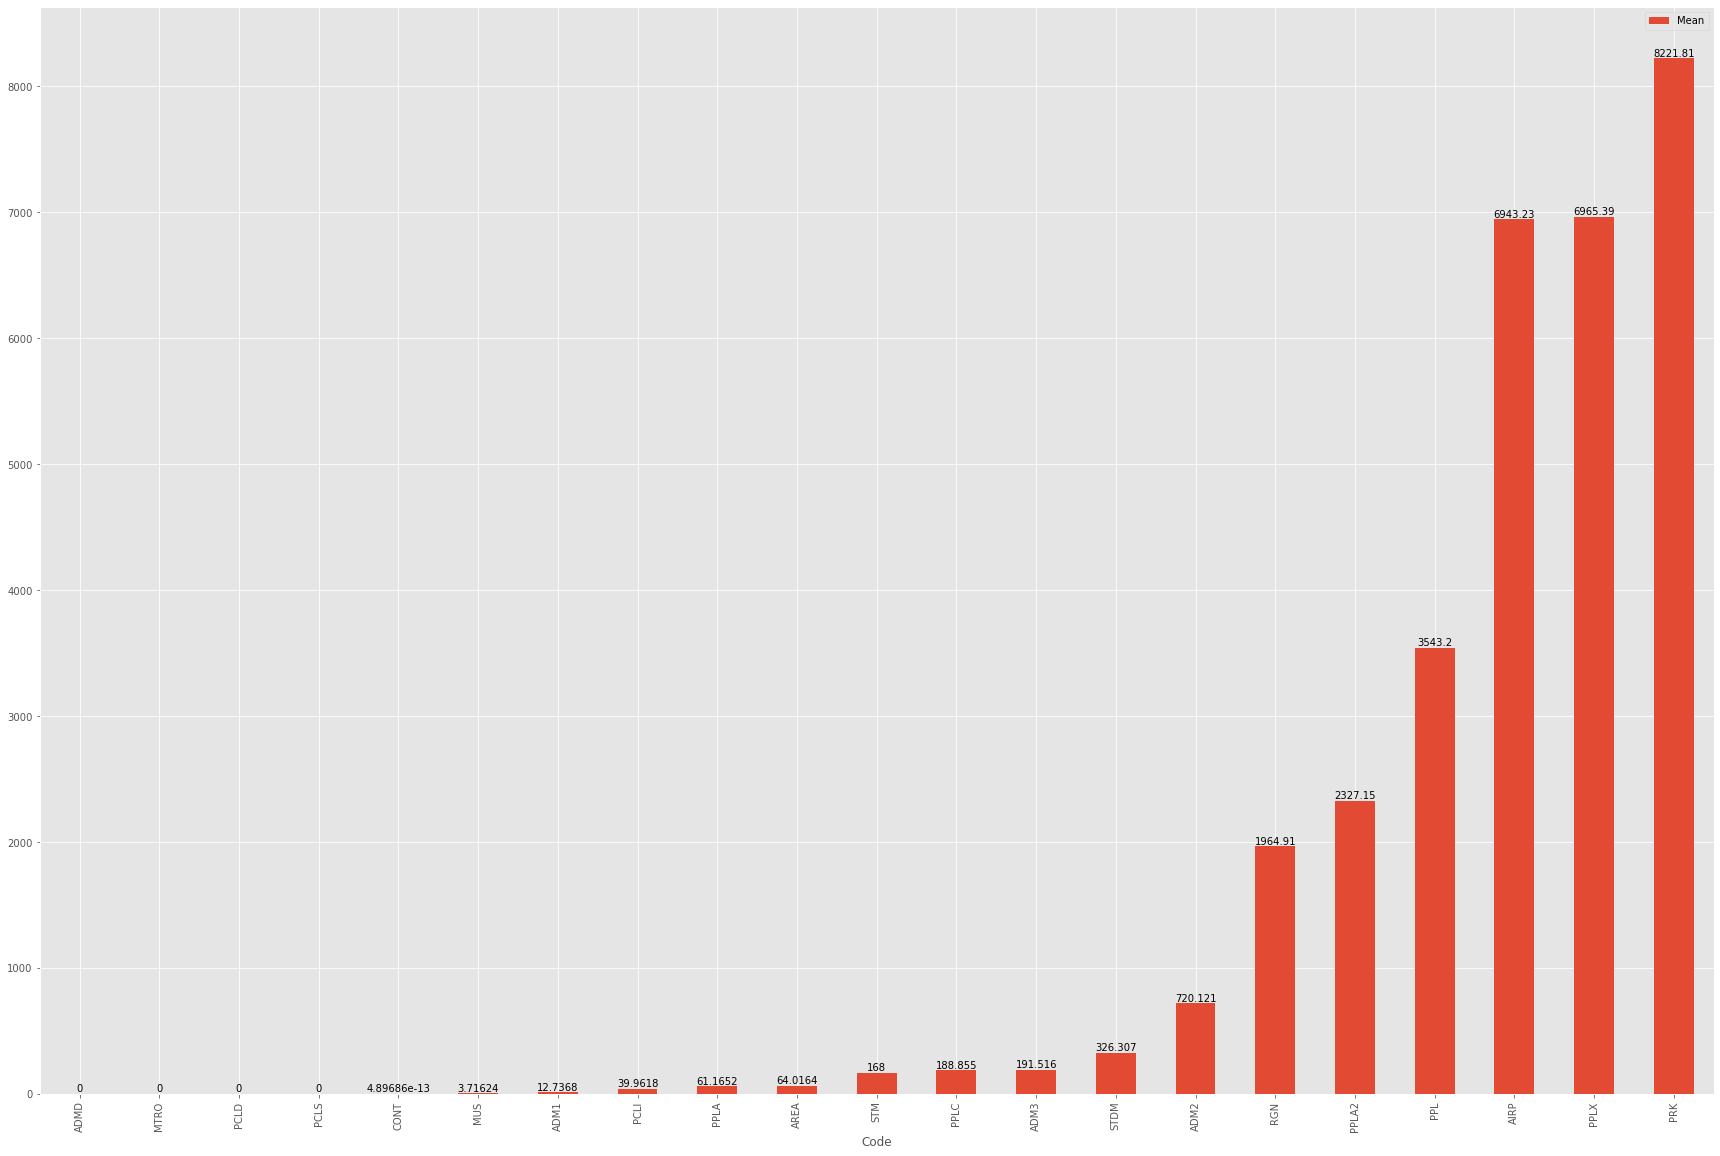

In [86]:
mean_errors_by_code = get_mean_error_by_feature_code(df_geocoded_hgat, False)
ax = pd.DataFrame(mean_errors_by_code.items(), columns=['Code', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Code", y="Mean", figsize=(30,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_code)

#### Erro por Feature Class

{'A': 73.18900436969165, 'P': 2071.5951733304473, 'S': 3526.617529147777, 'L': 1199.827140370819, 'H': 167.99970700709977}


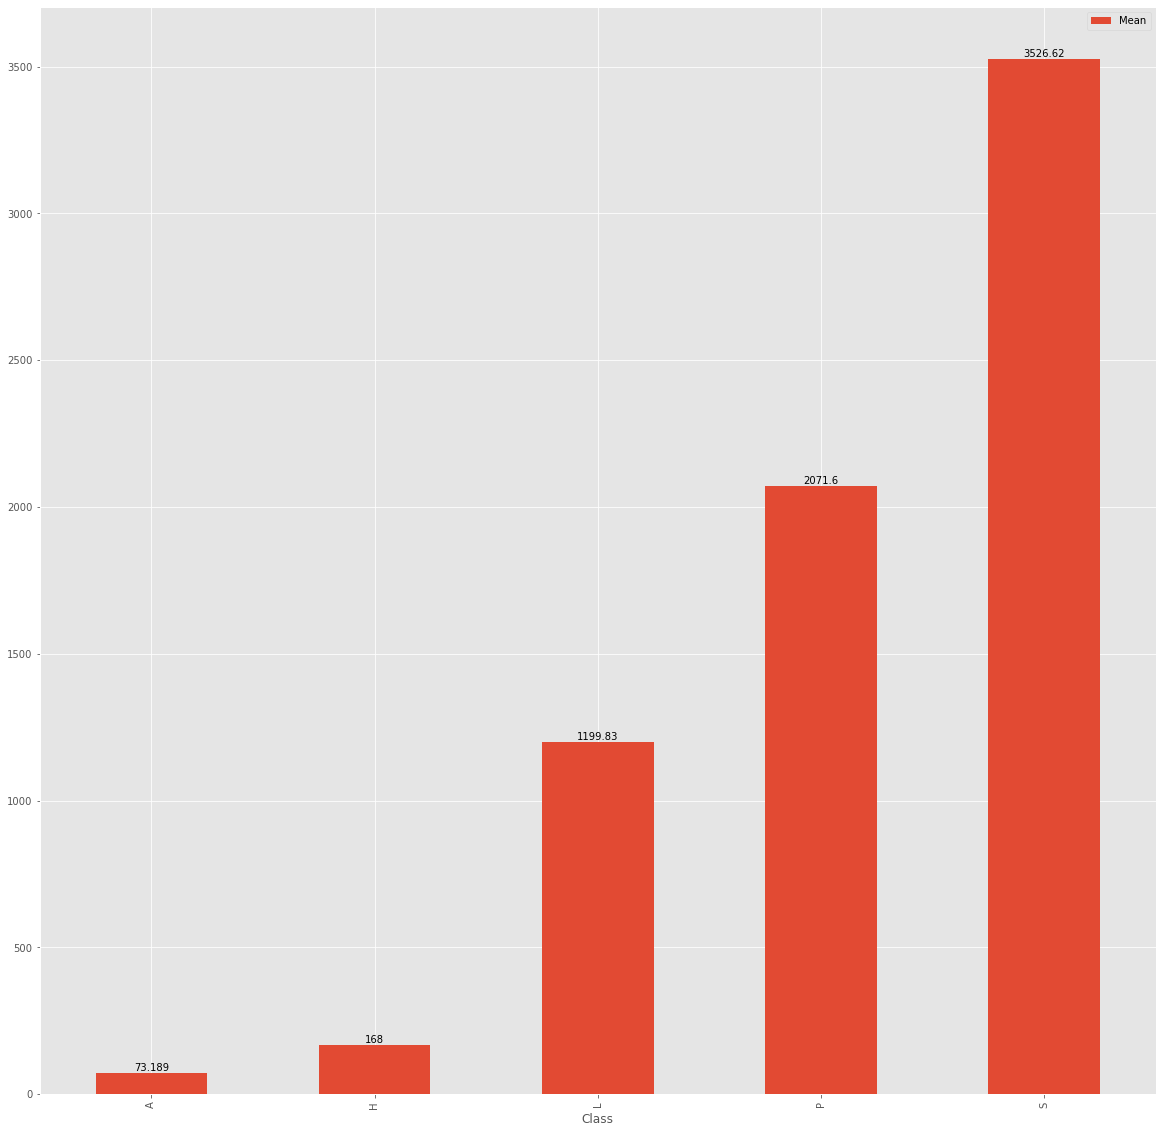

In [87]:
mean_errors_by_class = get_mean_error_by_feature_class(df_geocoded_hgat, False)
ax = pd.DataFrame(mean_errors_by_class.items(), columns=['Class', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Class", y="Mean", figsize=(20,20))
ax.bar_label(ax.containers[0])
print(mean_errors_by_class)

#### CLAVIN vs HGAT

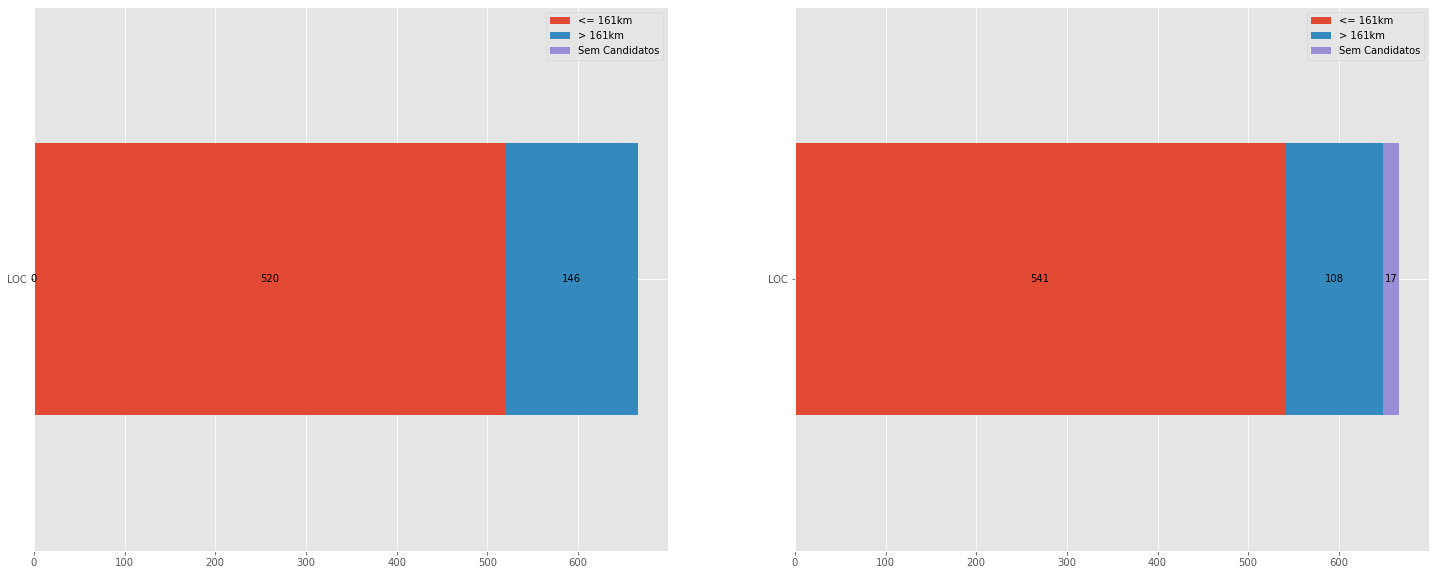

In [88]:
errors_by_type = count_errors_by_type(df_geocoded_hgat, classes=["LOC"])
df_errors_by_type_hgat = pd.DataFrame(
    {key: pd.Series(value) for key, value in errors_by_type.items()})

plot_bars_stacked_diff(df_errors_by_type_clavin, df_errors_by_type_hgat)

<AxesSubplot:>

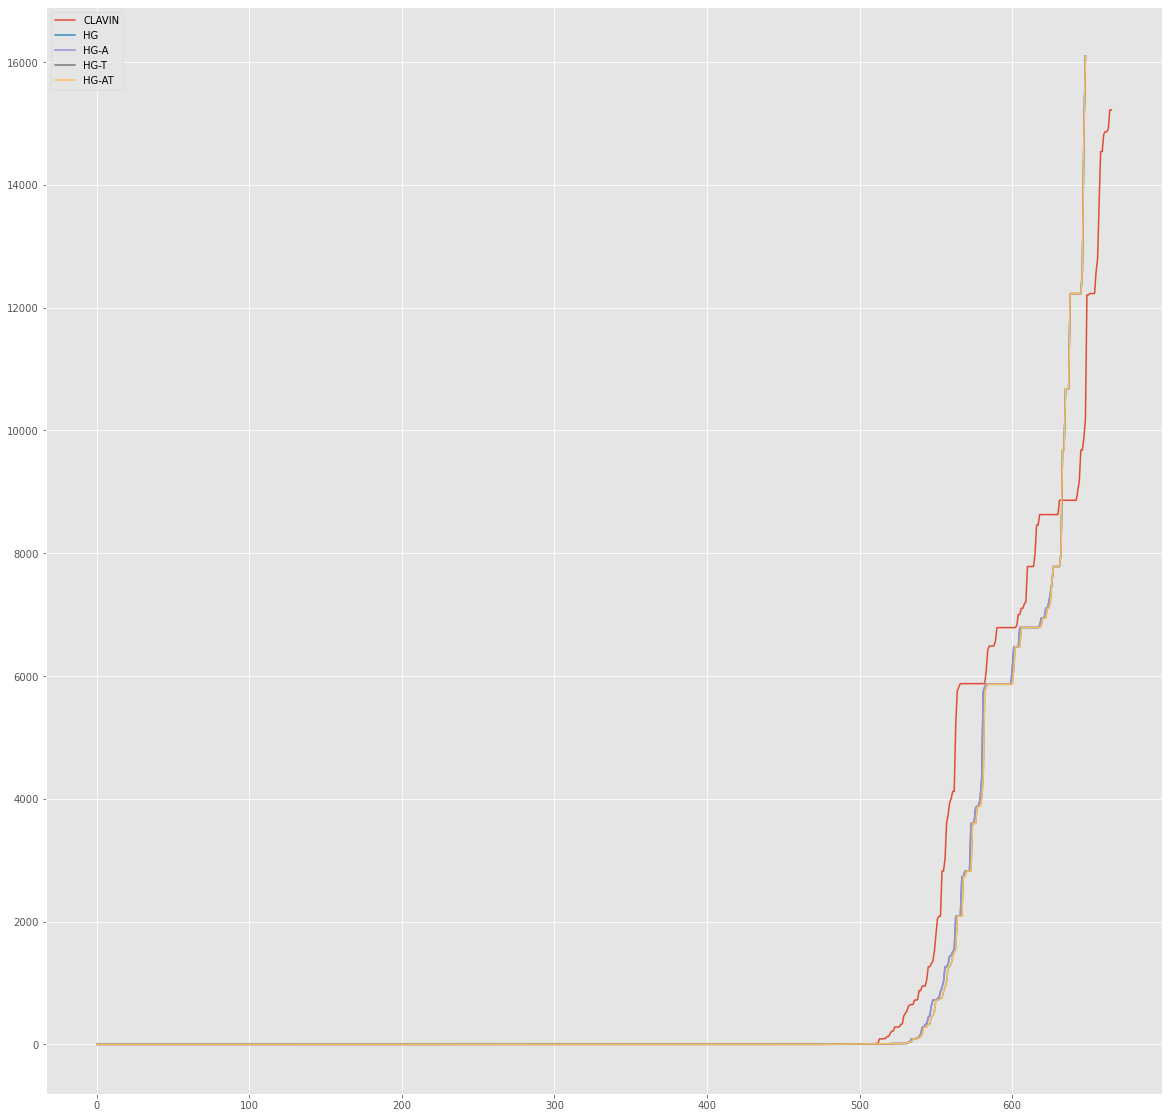

In [89]:
distances_clavin = sorted([i for j in df_geocoded_clavin.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms, False), axis=1).tolist() for i in j])
distances_hg = sorted([i for j in df_geocoded_hg.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms, False), axis=1).tolist() for i in j])
distances_hga = sorted([i for j in df_geocoded_hga.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms, False), axis=1).tolist() for i in j])
distances_hgt = sorted([i for j in df_geocoded_hgt.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms, False), axis=1).tolist() for i in j])
distances_hgat = sorted([i for j in df_geocoded_hgat.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms, False), axis=1).tolist() for i in j])
distances_dict = { "CLAVIN": distances_clavin, "HG": distances_hg, "HG-A": distances_hga, "HG-T": distances_hgt, "HG-AT": distances_hgat}
df_errors = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in distances_dict.items() ]))
df_errors[["CLAVIN", "HG", "HG-A", "HG-T", "HG-AT"]].plot(figsize=(20,20))

### Mesmos Topônimos

In [90]:
toponyms_in = []
for (i, toponyms), (j, geocoded_hg), (k, geocoded_hga), (l, geocoded_hgt), (m, geocoded_hgat), (n, geocoded_cl) in zip(df_trnews[['toponyms']].iterrows(), df_geocoded_hg[["geocoded"]].iterrows(), df_geocoded_hga[["geocoded"]].iterrows(), df_geocoded_hgt[["geocoded"]].iterrows(), df_geocoded_hgat[["geocoded"]].iterrows(), df_geocoded_clavin[["geocoded"]].iterrows()):
    found_hg = []
    truth = toponyms[0].copy()
    for pred in geocoded_hg[0]:
        for _, gt in enumerate(truth[:]):
            if ner_equal(pred, gt, exact_match=False) and pred[4] is not None:
                found_hg.append(gt)
                del truth[_]
                break
                
    found_hga = []
    truth = toponyms[0].copy()
    for pred in geocoded_hga[0]:
        for _, gt in enumerate(truth[:]):
            if ner_equal(pred, gt, exact_match=False) and pred[4] is not None:
                found_hga.append(gt)
                del truth[_]
                break
                
    found_hgt = []
    truth = toponyms[0].copy()
    for pred in geocoded_hgt[0]:
        for _, gt in enumerate(truth[:]):
            if ner_equal(pred, gt, exact_match=False) and pred[4] is not None:
                found_hgt.append(gt)
                del truth[_]
                break
                
    found_hgat = []
    truth = toponyms[0].copy()
    for pred in geocoded_hgat[0]:
        for _, gt in enumerate(truth[:]):
            if ner_equal(pred, gt, exact_match=False) and pred[4] is not None:
                found_hgat.append(gt)
                del truth[_]
                break
                
    found_cl = []
    truth = toponyms[0].copy()
    for pred in geocoded_cl[0]:
        for _, gt in enumerate(truth[:]):
            if ner_equal(pred, gt, exact_match=False) and pred[4] is not None:
                found_cl.append(gt)
                del truth[_]
                break
    
    found_in = set.intersection(*map(set, [found_hg, found_hga, found_hgt, found_hgat, found_cl]))
    toponyms_in.append(list(found_in))    

toponyms_in = pd.DataFrame({"toponyms_in": toponyms_in})

In [91]:
unified_geocoded =  toponyms_in["toponyms_in"].tolist()
unified_geocoded = [i for j in unified_geocoded for i in j]
print(len(unified_geocoded))

649


#### HG

In [92]:
df_geocoded_hg["toponyms_in"] = toponyms_in
df_metrics_geocoded = pd.DataFrame(df_geocoded_hg.apply(lambda row: metrics(row.geocoded, row.toponyms_in, False, 161), axis=1).tolist(), index=df_geocoded_hg.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe().apply(lambda s: s.apply('{0:.6f}'.format))

Geotag Precision Geotag Recall Geotag F1-Score Geocode Mean Distance  \
count       113.000000    113.000000      113.000000            113.000000   
mean          0.968282      1.000000        0.981281           1424.230601   
std           0.091312      0.000000        0.056853           2644.265101   
min           0.500000      1.000000        0.666667              0.000000   
25%           1.000000      1.000000        1.000000              0.000000   
50%           1.000000      1.000000        1.000000             12.735147   
75%           1.000000      1.000000        1.000000           1440.187678   
max           1.000000      1.000000        1.000000          12227.893881   

       Geocode Within Min Distance     @161 km         AUC Pct predicted  
count                   113.000000  113.000000  105.000000    113.000000  
mean                      0.776993    0.776993    0.186386      1.000000  
std                       0.334597    0.334597    0.259160      0.000000  
min                       0.000000    0.000000    0.000000      1.000000  
25%                       0.625000    0.625000    0.000000      1.000000  
50%                       1.000000    1.000000    0.078658      1.000000  
75%                       1.000000    1.000000    0.232887      1.000000  
max                       1.000000    1.000000    0.950141      1.000000

#### HG-A

In [93]:
df_geocoded_hga["toponyms_in"] = toponyms_in
df_metrics_geocoded = pd.DataFrame(df_geocoded_hga.apply(lambda row: metrics(row.geocoded, row.toponyms_in, False, 161), axis=1).tolist(), index=df_geocoded_hga.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe().apply(lambda s: s.apply('{0:.6f}'.format))

Geotag Precision Geotag Recall Geotag F1-Score Geocode Mean Distance  \
count       113.000000    113.000000      113.000000            113.000000   
mean          0.968282      1.000000        0.981281           1424.230601   
std           0.091312      0.000000        0.056853           2644.265101   
min           0.500000      1.000000        0.666667              0.000000   
25%           1.000000      1.000000        1.000000              0.000000   
50%           1.000000      1.000000        1.000000             12.735147   
75%           1.000000      1.000000        1.000000           1440.187678   
max           1.000000      1.000000        1.000000          12227.893881   

       Geocode Within Min Distance     @161 km         AUC Pct predicted  
count                   113.000000  113.000000  105.000000    113.000000  
mean                      0.776993    0.776993    0.186386      1.000000  
std                       0.334597    0.334597    0.259160      0.000000  
min                       0.000000    0.000000    0.000000      1.000000  
25%                       0.625000    0.625000    0.000000      1.000000  
50%                       1.000000    1.000000    0.078658      1.000000  
75%                       1.000000    1.000000    0.232887      1.000000  
max                       1.000000    1.000000    0.950141      1.000000

#### HG-T

In [94]:
df_geocoded_hgt["toponyms_in"] = toponyms_in
df_metrics_geocoded = pd.DataFrame(df_geocoded_hgt.apply(lambda row: metrics(row.geocoded, row.toponyms_in, False, 161), axis=1).tolist(), index=df_geocoded_hgt.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe().apply(lambda s: s.apply('{0:.6f}'.format))

Geotag Precision Geotag Recall Geotag F1-Score Geocode Mean Distance  \
count       113.000000    113.000000      113.000000            113.000000   
mean          0.968282      1.000000        0.981281           1409.543667   
std           0.091312      0.000000        0.056853           2630.627251   
min           0.500000      1.000000        0.666667              0.000000   
25%           1.000000      1.000000        1.000000              0.000000   
50%           1.000000      1.000000        1.000000             12.735147   
75%           1.000000      1.000000        1.000000           1440.187678   
max           1.000000      1.000000        1.000000          12227.893881   

       Geocode Within Min Distance     @161 km         AUC Pct predicted  
count                   113.000000  113.000000  105.000000    113.000000  
mean                      0.779558    0.779558    0.184541      1.000000  
std                       0.333606    0.333606    0.258646      0.000000  
min                       0.000000    0.000000    0.000000      1.000000  
25%                       0.666667    0.666667    0.000000      1.000000  
50%                       1.000000    1.000000    0.075740      1.000000  
75%                       1.000000    1.000000    0.237535      1.000000  
max                       1.000000    1.000000    0.950141      1.000000

#### HG-AT

In [95]:
df_geocoded_hgat["toponyms_in"] = toponyms_in
df_metrics_geocoded = pd.DataFrame(df_geocoded_hgat.apply(lambda row: metrics(row.geocoded, row.toponyms_in, False, 161), axis=1).tolist(), index=df_geocoded_hgat.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe().apply(lambda s: s.apply('{0:.6f}'.format))

Geotag Precision Geotag Recall Geotag F1-Score Geocode Mean Distance  \
count       113.000000    113.000000      113.000000            113.000000   
mean          0.968282      1.000000        0.981281           1409.543667   
std           0.091312      0.000000        0.056853           2630.627251   
min           0.500000      1.000000        0.666667              0.000000   
25%           1.000000      1.000000        1.000000              0.000000   
50%           1.000000      1.000000        1.000000             12.735147   
75%           1.000000      1.000000        1.000000           1440.187678   
max           1.000000      1.000000        1.000000          12227.893881   

       Geocode Within Min Distance     @161 km         AUC Pct predicted  
count                   113.000000  113.000000  105.000000    113.000000  
mean                      0.779558    0.779558    0.184541      1.000000  
std                       0.333606    0.333606    0.258646      0.000000  
min                       0.000000    0.000000    0.000000      1.000000  
25%                       0.666667    0.666667    0.000000      1.000000  
50%                       1.000000    1.000000    0.075740      1.000000  
75%                       1.000000    1.000000    0.237535      1.000000  
max                       1.000000    1.000000    0.950141      1.000000

{'A': 73.18900436969165, 'P': 2071.5951733304473, 'S': 3526.617529147777, 'L': 1199.827140370819, 'H': 167.99970700709977}


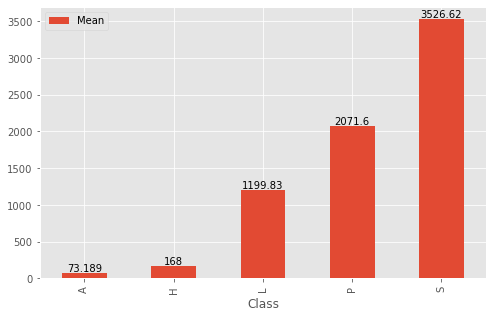

In [96]:
mean_errors_by_class = get_mean_error_by_feature_class_intersection(df_geocoded_hgat, False)
ax = pd.DataFrame(mean_errors_by_class.items(), columns=['Class', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Class", y="Mean", figsize=(8,5))
ax.bar_label(ax.containers[0])
print(mean_errors_by_class)

#### CLAVIN

In [97]:
df_geocoded_clavin["toponyms_in"] = toponyms_in
df_metrics_geocoded = pd.DataFrame(df_geocoded_clavin.apply(lambda row: metrics(row.geocoded, row.toponyms_in, False, 161), axis=1).tolist(), index=df_geocoded_clavin.index, columns=['Geotag Precision', 'Geotag Recall', 'Geotag F1-Score', 'Geocode Mean Distance', ' Geocode Within Min Distance', '@161 km', 'AUC', 'Pct predicted'])
df_metrics_geocoded.describe().apply(lambda s: s.apply('{0:.6f}'.format))

Geotag Precision Geotag Recall Geotag F1-Score Geocode Mean Distance  \
count       113.000000    113.000000      113.000000            113.000000   
mean          0.968282      1.000000        0.981281           1656.949706   
std           0.091312      0.000000        0.056853           2944.170846   
min           0.500000      1.000000        0.666667              0.000000   
25%           1.000000      1.000000        1.000000              0.000000   
50%           1.000000      1.000000        1.000000              3.404067   
75%           1.000000      1.000000        1.000000           2470.520365   
max           1.000000      1.000000        1.000000          14541.391032   

       Geocode Within Min Distance     @161 km         AUC Pct predicted  
count                   113.000000  113.000000  105.000000    113.000000  
mean                      0.755328    0.755328    0.188443      1.000000  
std                       0.347160    0.347160    0.264845      0.000000  
min                       0.000000    0.000000    0.000000      1.000000  
25%                       0.652174    0.652174    0.000000      1.000000  
50%                       1.000000    1.000000    0.078291      1.000000  
75%                       1.000000    1.000000    0.252417      1.000000  
max                       1.000000    1.000000    0.950155      1.000000

{'A': 1141.8105387522594, 'P': 1823.0436916791327, 'S': 55.003849010462424, 'L': 1501.8332260757418, 'H': 178.66269474833848}


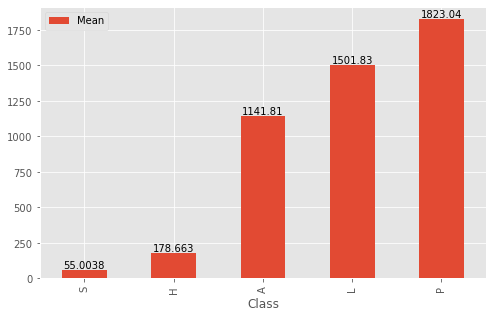

In [98]:
mean_errors_by_class = get_mean_error_by_feature_class_intersection(df_geocoded_clavin, False)
ax = pd.DataFrame(mean_errors_by_class.items(), columns=['Class', 'Mean']).sort_values(by=['Mean']).plot.bar(x="Class", y="Mean", figsize=(8,5))
ax.bar_label(ax.containers[0])
print(mean_errors_by_class)

#### CLAVIN vs HG-AT

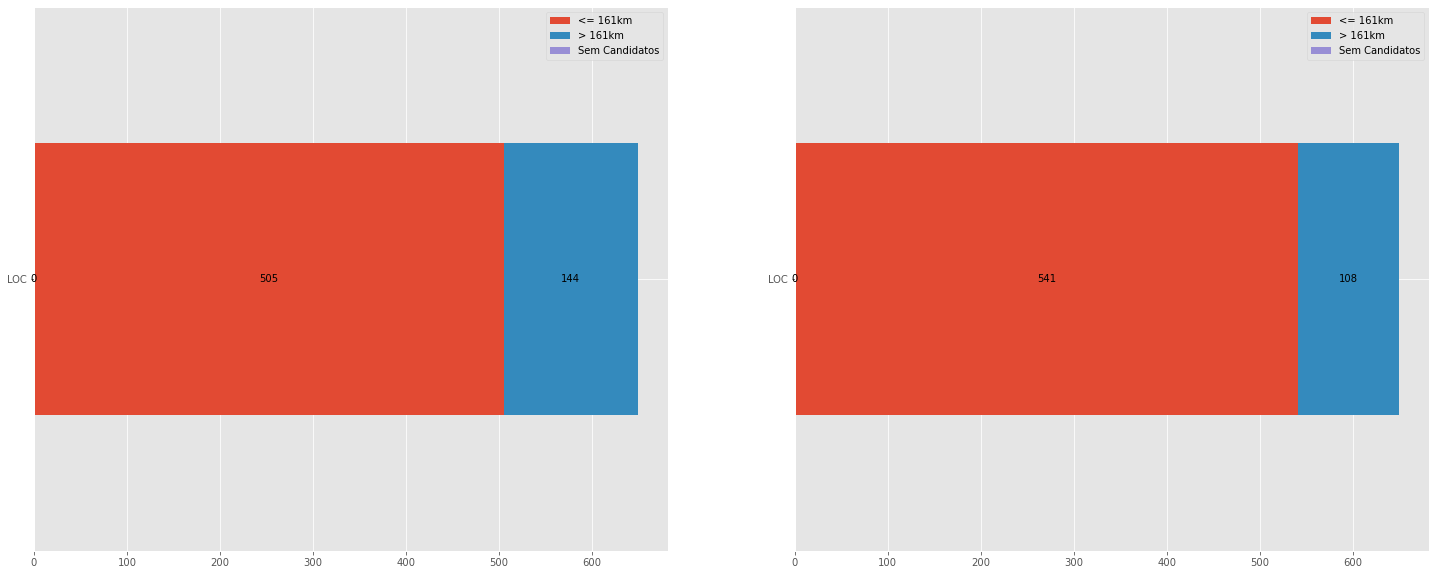

In [99]:
errors_by_type = count_errors_by_type_intersection(df_geocoded_hgat, classes=["LOC"])
df_errors_by_type_hgat_in = pd.DataFrame(
    {key: pd.Series(value) for key, value in errors_by_type.items()})

errors_by_type = count_errors_by_type_intersection(df_geocoded_clavin, classes=["LOC"])
df_errors_by_type_clavin_in = pd.DataFrame(
    {key: pd.Series(value) for key, value in errors_by_type.items()})

plot_bars_stacked_diff(df_errors_by_type_clavin_in, df_errors_by_type_hgat_in)

<AxesSubplot:>

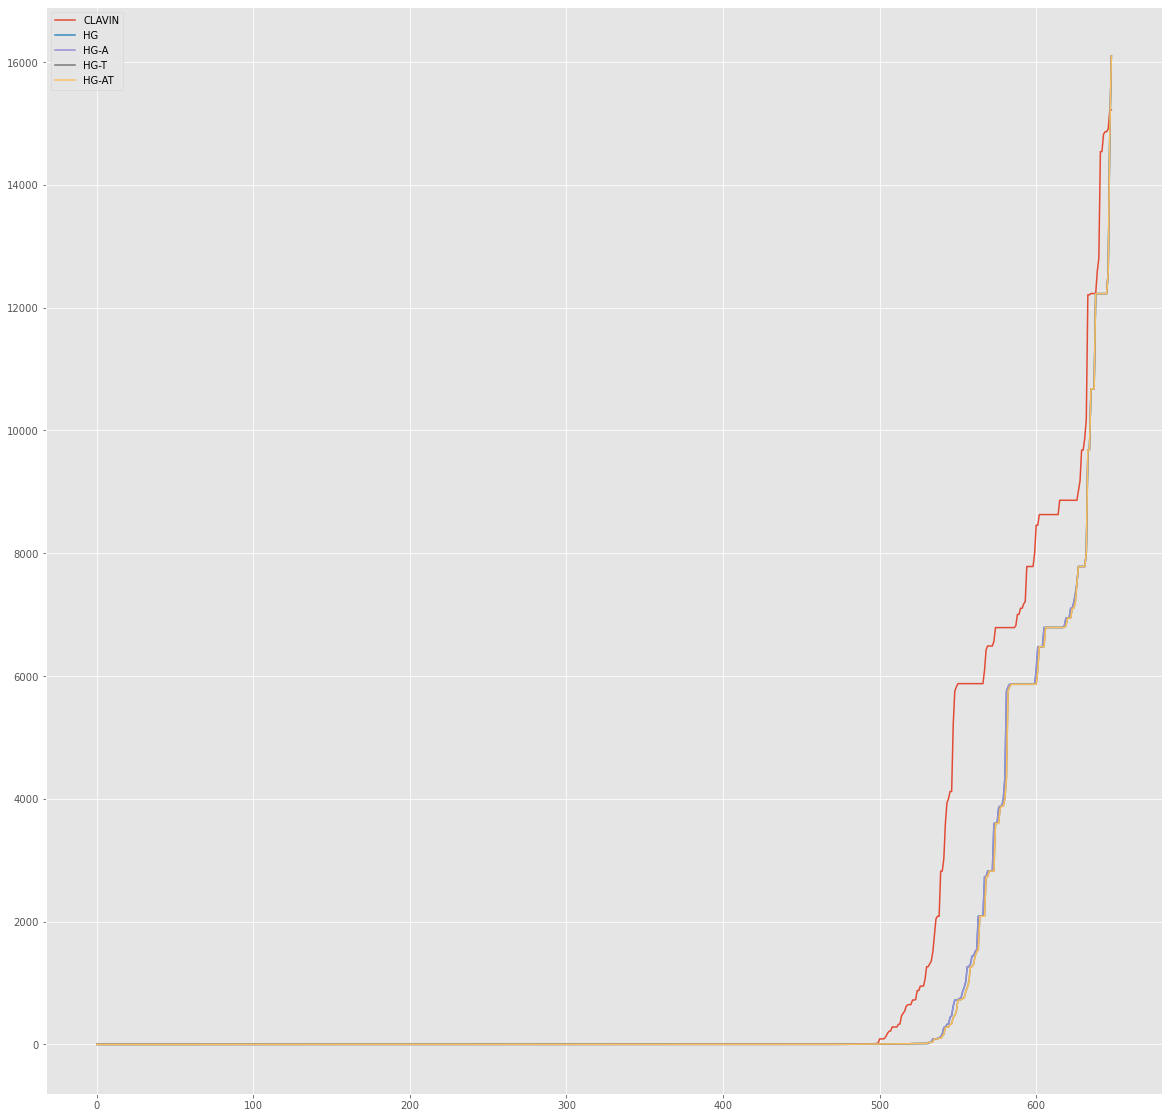

In [100]:
distances_clavin = sorted([i for j in df_geocoded_clavin.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms_in, False), axis=1).tolist() for i in j])
distances_hg = sorted([i for j in df_geocoded_hg.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms_in, False), axis=1).tolist() for i in j])
distances_hga = sorted([i for j in df_geocoded_hga.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms_in, False), axis=1).tolist() for i in j])
distances_hgt = sorted([i for j in df_geocoded_hgt.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms_in, False), axis=1).tolist() for i in j])
distances_hgat = sorted([i for j in df_geocoded_hgat.apply(lambda row: get_prediction_errors(row.geocoded, row.toponyms_in, False), axis=1).tolist() for i in j])
distances_dict = { "CLAVIN": distances_clavin, "HG": distances_hg, "HG-A": distances_hga, "HG-T": distances_hgt, "HG-AT": distances_hgat}
df_errors = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in distances_dict.items() ]))
df_errors[["CLAVIN", "HG", "HG-A", "HG-T", "HG-AT"]].plot(figsize=(20,20))